# Analyse Isolated Star Sources

 work with Weakly_2024_07
- use jupyter kernel LSST


- author : Sylvie Dagoret-Campagne
- affiliation : IJCLab
- creation date : 2024/02/25
- update : 2024/02/28


In [1]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
from mpl_toolkits.axes_grid1 import make_axes_locatable
from matplotlib.colors import LogNorm,SymLogNorm


import matplotlib.ticker                         # here's where the formatter is
from matplotlib.ticker import (MultipleLocator, FormatStrFormatter,
                               AutoMinorLocator)
from astropy.visualization import (MinMaxInterval, SqrtStretch,ZScaleInterval,PercentileInterval,
                                   ImageNormalize,imshow_norm)
from astropy.visualization.stretch import SinhStretch, LinearStretch,AsinhStretch,LogStretch
from astropy.io import fits
import astropy.coordinates as coord
import astropy.units as u
import pandas as pd

from astropy.time import Time
from datetime import datetime, timedelta

import matplotlib.ticker                         # here's where the formatter is
import os
import re
import pandas as pd

plt.rcParams["figure.figsize"] = (4,3)
plt.rcParams["axes.labelsize"] = 'xx-large'
plt.rcParams['axes.titlesize'] = 'xx-large'
plt.rcParams['xtick.labelsize']= 'xx-large'
plt.rcParams['ytick.labelsize']= 'xx-large'

In [2]:
#filesource_in="preSourceTable_202312.csv"
filesource_in="../data/202402/isolated_star_sources_202402.csv"

In [3]:
df = pd.read_csv(filesource_in,index_col=0)
df.dropna(axis=1, how='all',inplace =True)
df = df.rename(columns={"visit": "visitId"})
df["nightObs"] =df.apply(lambda x: x['visitId']//100_000, axis=1)
df["seq"] = df["visitId"] - df["nightObs"]*100_000
col_df = df.columns.tolist()
df.sort_values(by="visitId",inplace=True)

In [4]:
df

index            sourceId        visitId  detector          ra  \
5945      113  171629648369680498  2023051100262         0  239.943846   
14739      54  171629648369680439  2023051100262         0  239.951945   
6356      149  171629648369680534  2023051100262         0  239.954058   
12725     109  171629648369680494  2023051100262         0  239.972020   
18521      49  171629648369680434  2023051100262         0  239.933255   
...       ...                 ...            ...       ...         ...   
103915    250  180918223816884475  2024013000170         0  122.495359   
94392     279  180918223816884504  2024013000170         0  122.513226   
47010     240  180918223816884465  2024013000170         0  122.550632   
141015    180  180918223816884405  2024013000170         0  122.466880   
109742     13  180918223816884238  2024013000170         0  122.462780   

              dec   physical_filter band  apFlux_35_0_instFlux  \
5945   -24.037483  SDSSr_65mm~empty    r          11682.545864   
14739  -24.082878  SDSSr_65mm~empty    r          14537.218953   
6356   -24.003433  SDSSr_65mm~empty    r           7552.498704   
12725  -24.025800  SDSSr_65mm~empty    r           6433.296870   
18521  -24.097553  SDSSr_65mm~empty    r           8727.490829   
...           ...               ...  ...                   ...   
103915 -36.129911  empty~SDSSy_65mm    y         265711.720542   
94392  -36.118635  empty~SDSSy_65mm    y          12362.190091   
47010  -36.134154  empty~SDSSy_65mm    y          14355.896120   
141015 -36.153396  empty~SDSSy_65mm    y          24758.107206   
109742 -36.214441  empty~SDSSy_65mm    y          25000.667033   

        apFlux_35_0_instFluxErr  ...  apFlux_50_0_instFlux  \
5945                 566.986849  ...          11784.500412   
14739                646.144172  ...          15559.992986   
6356                 548.550678  ...           7233.976218   
12725                554.620789  ...           6772.211148   
18521                673.469980  ...           9406.176961   
...                         ...  ...                   ...   
103915               772.168701  ...         279452.084387   
94392                605.785863  ...          12064.848342   
47010                580.365493  ...          13844.159811   
141015               609.047006  ...          26682.300053   
109742               618.832771  ...          26223.500075   

        apFlux_50_0_instFluxErr  apFlux_50_0_flag  localBackground_instFlux  \
5945                 802.841733             False                  0.078950   
14739                913.481314             False                  0.186437   
6356                 778.778434             False                  0.036289   
12725                788.454307             False                 -0.050780   
18521                957.945823             False                  0.069934   
...                         ...               ...                       ...   
103915               983.669819             False                 -0.028821   
94392                858.821268             False                 -0.015053   
47010                821.046709             False                 -0.213675   
141015               856.993268             False                  0.046971   
109742               872.029538             False                  0.171632   

        localBackground_flag  source_row  obj_index  tract  nightObs  seq  
5945                   False         113         39   5615  20230511  262  
14739                  False          54        160   5615  20230511  262  
6356                   False         149         43   5615  20230511  262  
12725                  False         109        120   5615  20230511  262  
18521                  False          49        287   5615  20230511  262  
...                      ...         ...        ...    ...       ...  ...  
103915                 False         250        367   3864  20240130  170  
94392                  F

In [5]:
col_df

['index',
 'sourceId',
 'visitId',
 'detector',
 'ra',
 'dec',
 'physical_filter',
 'band',
 'apFlux_35_0_instFlux',
 'apFlux_35_0_instFluxErr',
 'x',
 'y',
 'apFlux_50_0_instFlux',
 'apFlux_50_0_instFluxErr',
 'apFlux_50_0_flag',
 'localBackground_instFlux',
 'localBackground_flag',
 'source_row',
 'obj_index',
 'tract',
 'nightObs',
 'seq']

In [6]:
def convert_fluxtomag(x) :
    """
    The object and source catalogs store only fluxes. There are hundreds of flux-related columns, 
    and to store them also as magnitudes would be redundant, and a waste of space.
    All flux units are nanojanskys. The AB Magnitudes Wikipedia page provides a concise resource 
    for users unfamiliar with AB magnitudes and jansky fluxes. To convert to AB magnitudes use:
    As demonstrated in Section 2.3.2, to add columns of magnitudes after retrieving columns of flux, users can do this:
    results_table['r_calibMag'] = -2.50 * numpy.log10(results_table['r_calibFlux']) + 31.4
    results_table['r_cModelMag'] = -2.50 * numpy.log10(results_table['r_cModelFlux']) + 31.4
    (from DP0 tutorial)
    """
    return -2.50 * np.log10(x) + 31.4

In [7]:
df["apFlux_35_0_instMag"] =  df['apFlux_35_0_instFlux'].map(convert_fluxtomag)
df["apFlux_50_0_instMag"] =  df['apFlux_50_0_instFlux'].map(convert_fluxtomag)

/tmp/ipykernel_41933/4088867659.py:12: RuntimeWarning: invalid value encountered in log10
  return -2.50 * np.log10(x) + 31.4


/tmp/ipykernel_41933/710608077.py:3: UserWarning: To output multiple subplots, the figure containing the passed axes is being cleared.
  axes = df.hist(column= column_names,by="band",bins=20,ax=ax,xrot=0,range=(16,23),legend=True)


Text(0.5, 0.98, "['apFlux_35_0_instMag', 'apFlux_50_0_instMag']")

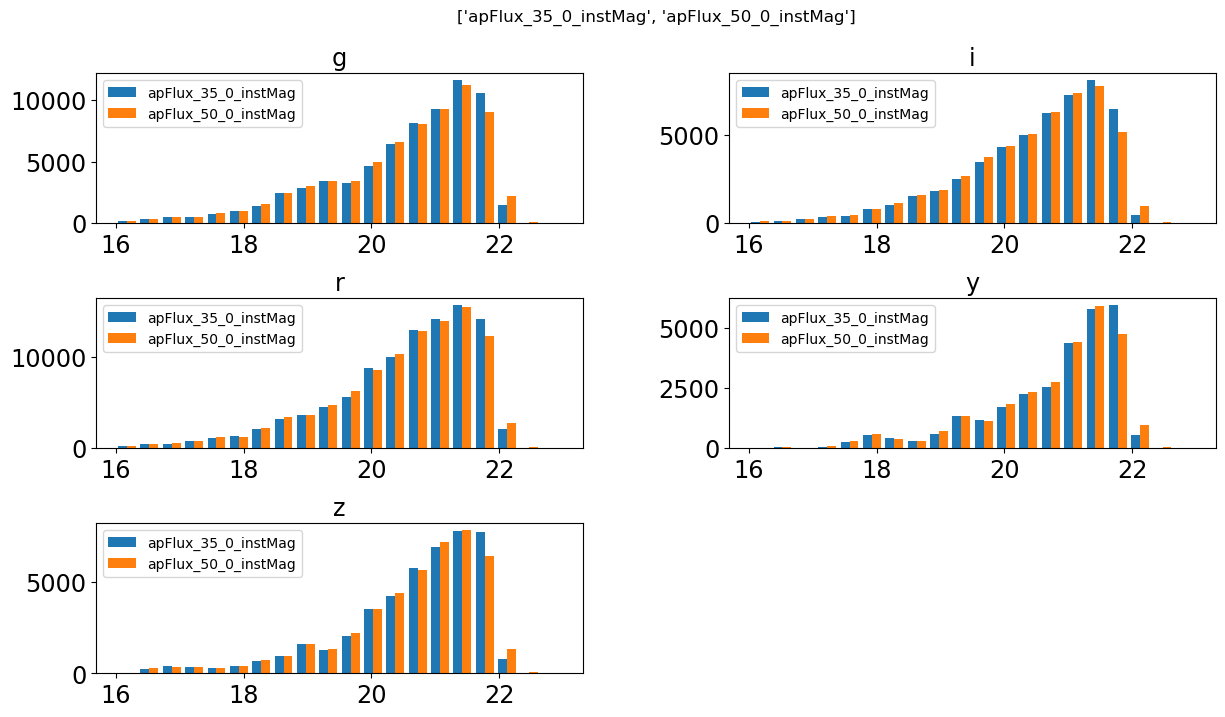

In [8]:
column_names = ["apFlux_35_0_instMag","apFlux_50_0_instMag"]
fig,ax = plt.subplots(figsize=(14,8))
axes = df.hist(column= column_names,by="band",bins=20,ax=ax,xrot=0,range=(16,23),legend=True)
plt.suptitle(column_names)

In [9]:
np.sort(df["nightObs"].unique())

array([20230511, 20230523, 20230524, 20230704, 20230705, 20230706,
       20230718, 20230720, 20230801, 20230802, 20230803, 20230815,
       20230816, 20230817, 20230829, 20230914, 20230927, 20230928,
       20231010, 20231011, 20231107, 20231108, 20231113, 20231114,
       20231115, 20231116, 20231120, 20231121, 20231127, 20231128,
       20231129, 20231130, 20231204, 20231205, 20231206, 20231211,
       20231212, 20231214, 20231215, 20231219, 20231220, 20231221,
       20231222, 20240129, 20240130])

# Statistics per nights

In [10]:
df_stat = df.groupby(by=["nightObs","band","tract"]).count()["index"]

In [11]:
df_stat

nightObs  band  tract
20230511  g     5614     1861
                5615     1991
          i     5614     2355
                5615     3113
          r     5614     2079
                         ... 
20240129  z     3864      327
20240130  g     3864     1081
          r     3864     1499
          y     3864     1069
          z     3864     1679
Name: index, Length: 248, dtype: int64

In [12]:
type(df_stat)

pandas.core.series.Series

In [13]:
df_stat_pertract = df.groupby(by=["nightObs","tract"]).count()["index"]

In [14]:
df_stat_pertract

nightObs  tract
20230511  5614     6295
          5615     7999
20230523  5615     1020
          5634      972
20230524  5615     1833
                   ... 
20231220  3864     9115
20231221  3864     8651
20231222  3864     7708
20240129  3864     1249
20240130  3864     5328
Name: index, Length: 78, dtype: int64

# Handle pandas series with composite index
https://stackoverflow.com/questions/25386870/pandas-plotting-with-multi-index

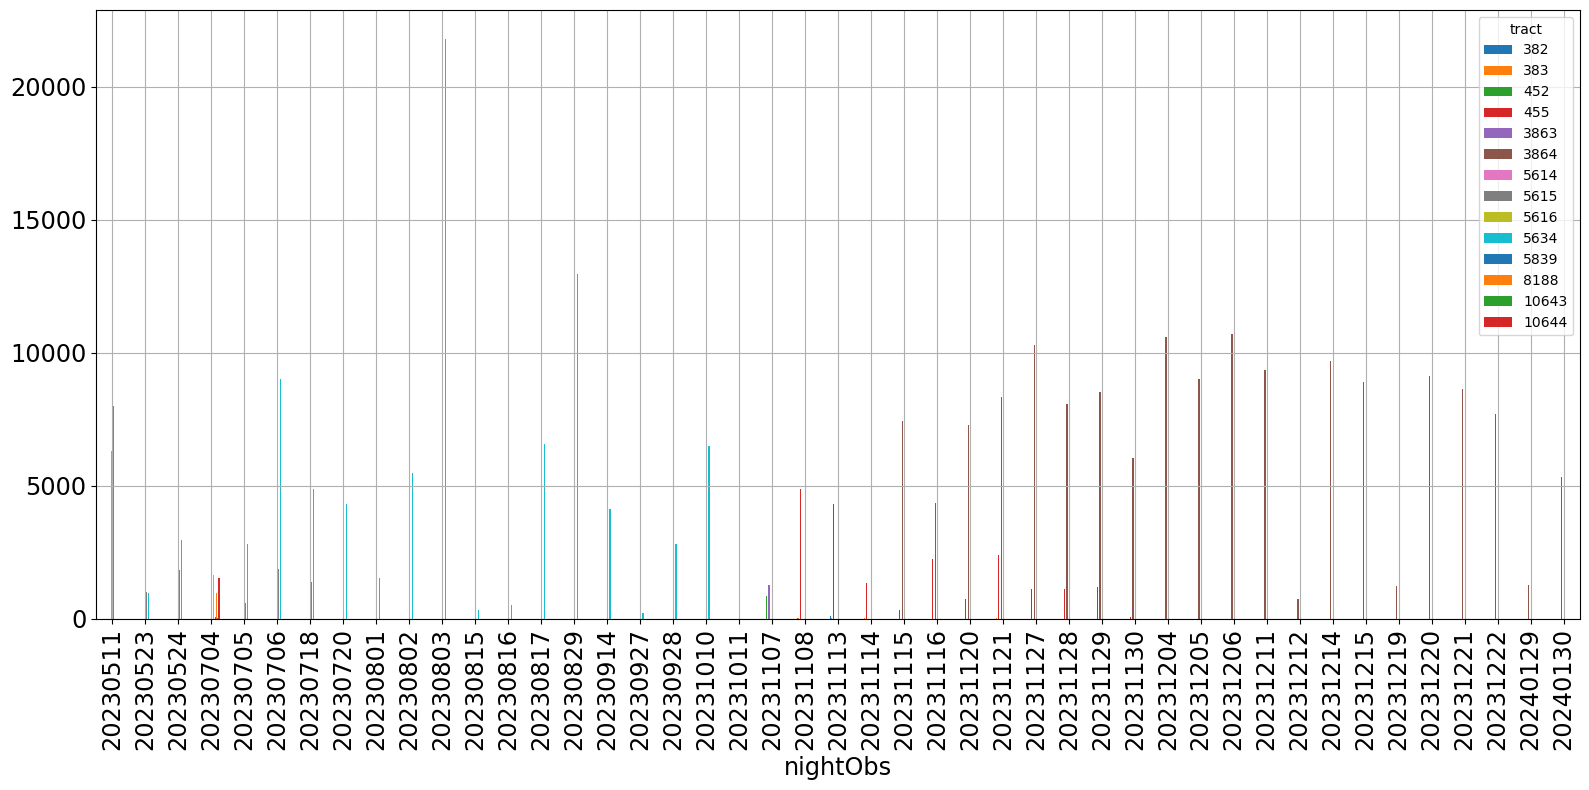

In [15]:
ax = df_stat_pertract.unstack(level=1).plot(kind='bar', subplots=False, rot=90,figsize=(16,8),grid=True)
plt.tight_layout()

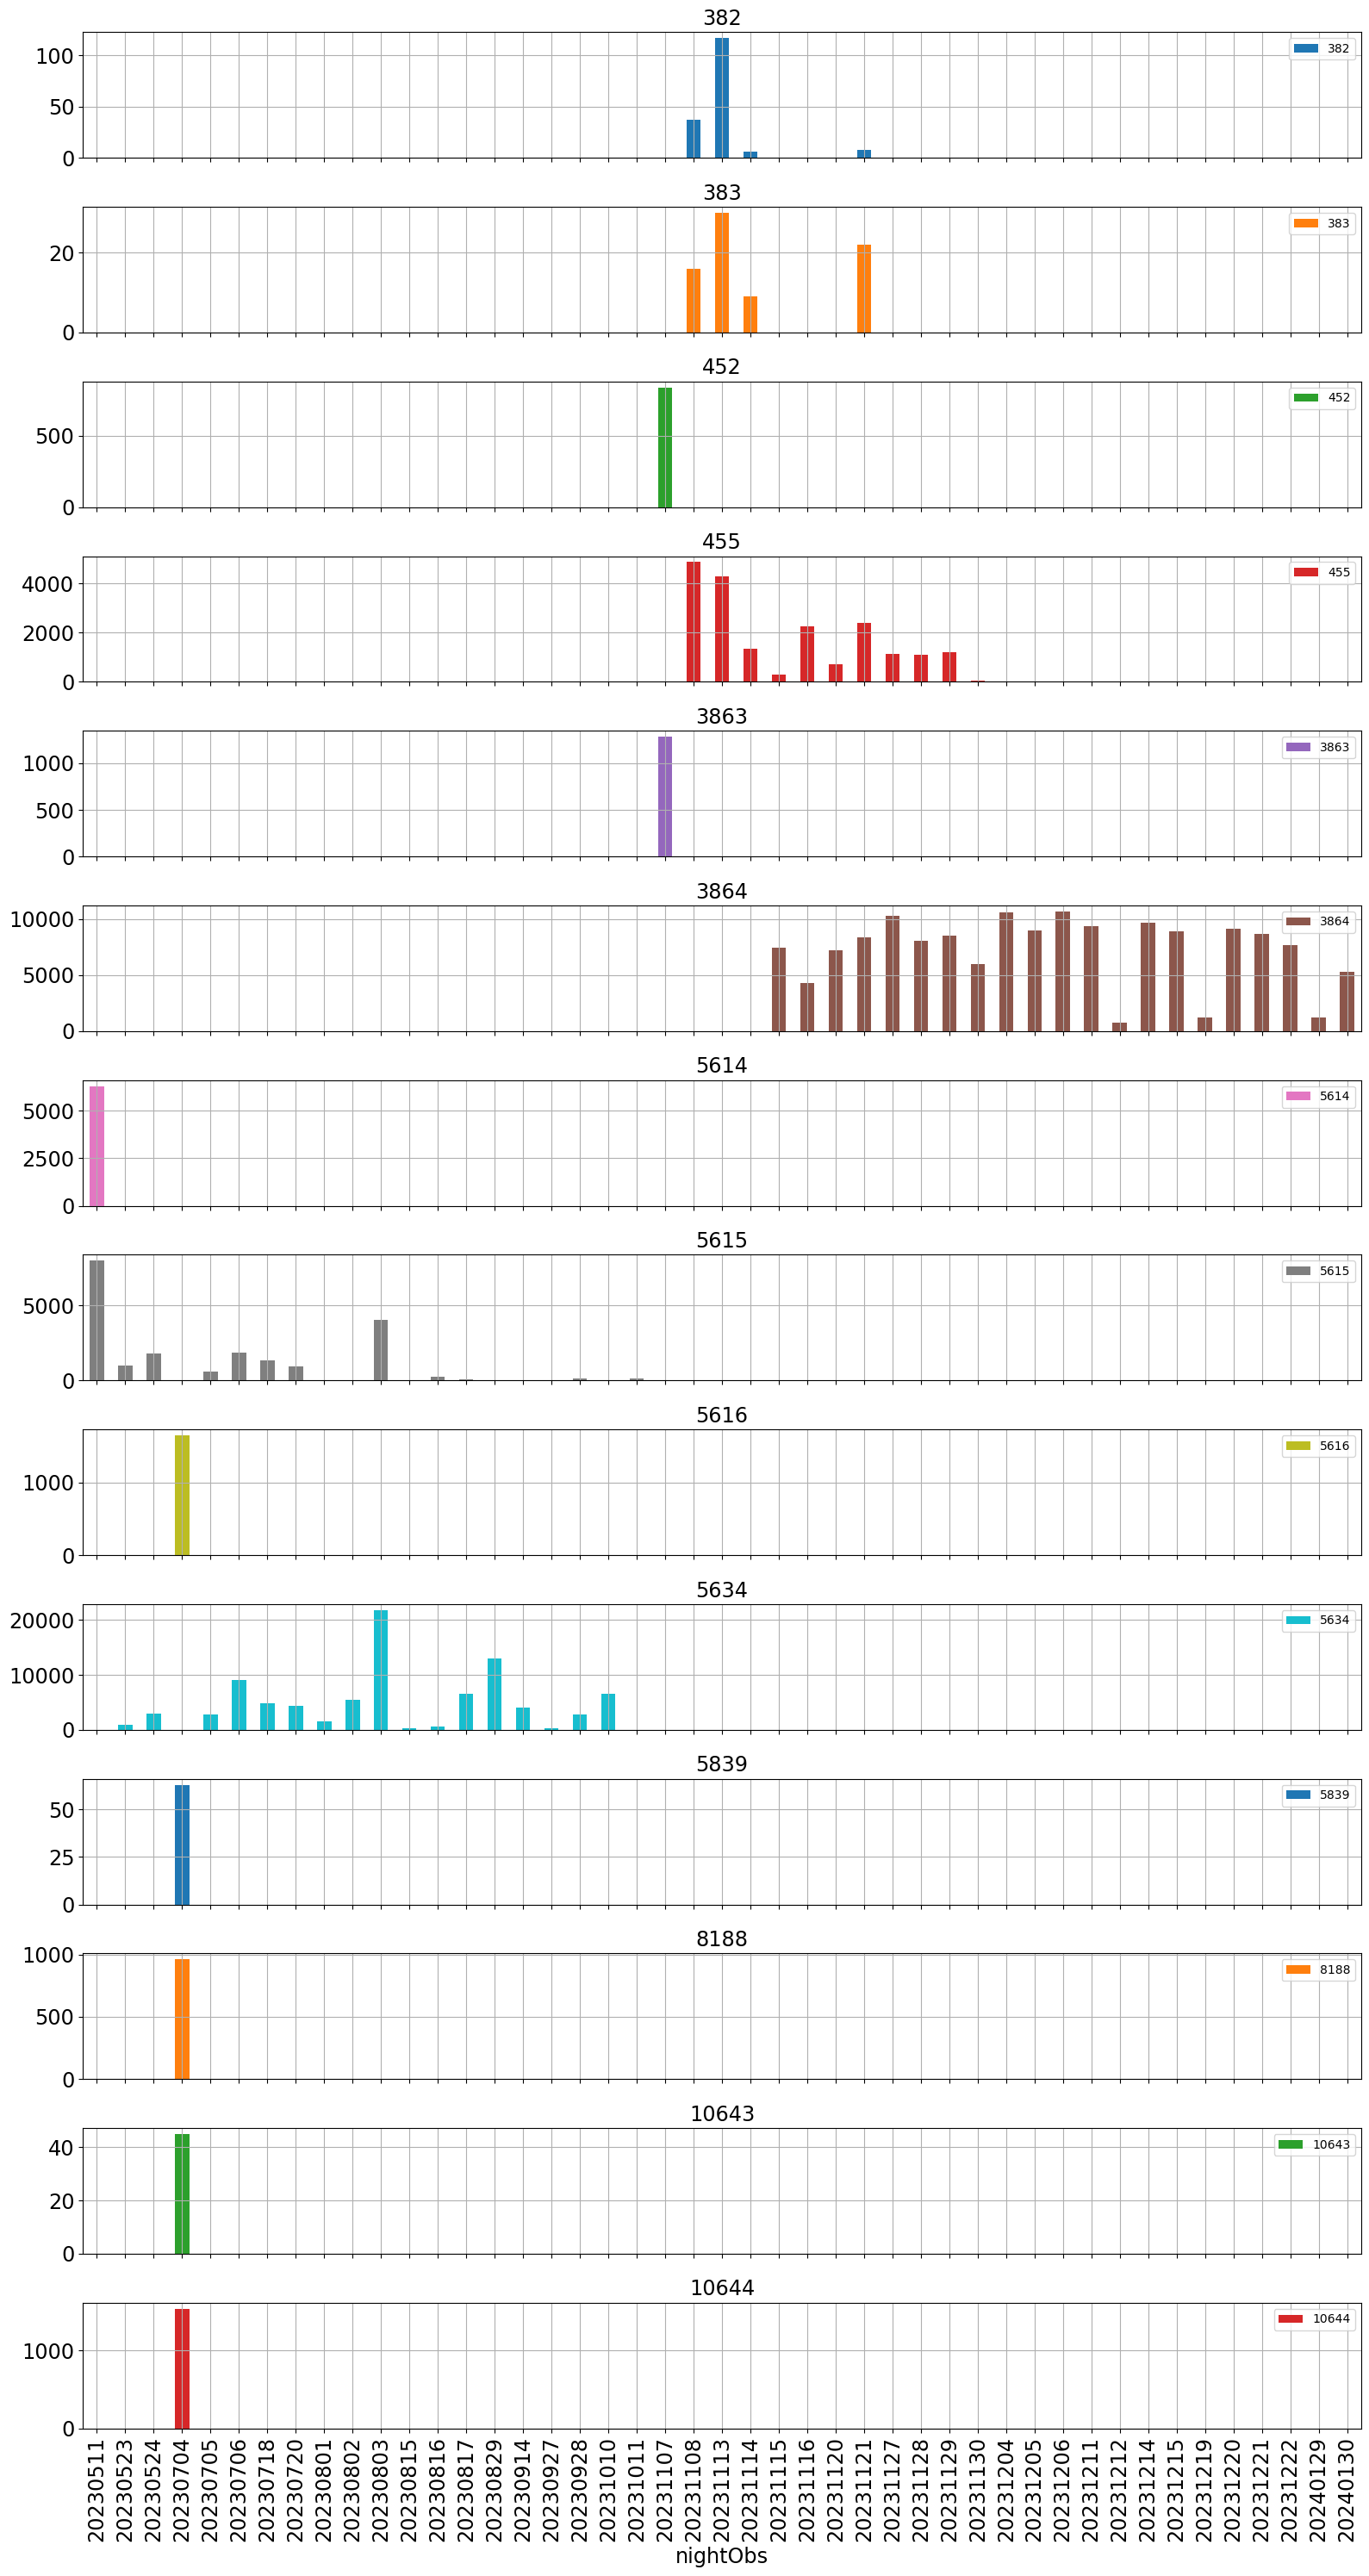

In [16]:
ax = df_stat_pertract.unstack(level=1).plot(kind='bar', subplots=True, rot=90,figsize=(16,30),grid=True)
plt.tight_layout()

## Select the tracts

In [17]:
TRACT_SEL = 3864

In [18]:
df_stat = df[df["tract"] == TRACT_SEL ].groupby(by=["nightObs","band"]).count()["index"]

In [19]:
df_stat

nightObs  band
20231115  g       1903
          i       3141
          r       2377
20231116  g        945
          i       1929
                  ... 
20240129  z        327
20240130  g       1081
          r       1499
          y       1069
          z       1679
Name: index, Length: 81, dtype: int64

In [20]:
df_stat.unstack(level=1)[["g","r","i","z"]]

band           g       r       i       z
nightObs                                
20231115  1903.0  2377.0  3141.0     NaN
20231116   945.0  1463.0  1929.0     NaN
20231120  1804.0  2391.0  3067.0     NaN
20231121  1680.0  2302.0     NaN  2724.0
20231127  1985.0  2797.0     NaN  3436.0
20231128  1588.0  2246.0     NaN  2607.0
20231129  1741.0  2395.0     NaN  2694.0
20231130  1224.0  1687.0     NaN  1917.0
20231204  2267.0  2927.0     NaN  3338.0
20231205  1854.0  2378.0     NaN  2965.0
20231206  2293.0  2919.0     NaN  3430.0
20231211  1969.0  2638.0     NaN  2938.0
20231212   123.0   210.0     NaN   283.0
20231214  2040.0  2598.0     NaN  3112.0
20231215  1789.0  2512.0     NaN  2904.0
20231219   205.0   335.0     NaN   433.0
20231220  1944.0  2524.0     NaN  2925.0
20231221  1803.0  2284.0     NaN  2783.0
20231222  1740.0  2121.0     NaN  2374.0
20240129   299.0   347.0     NaN   327.0
20240130  1081.0  1499.0     NaN  1679.0

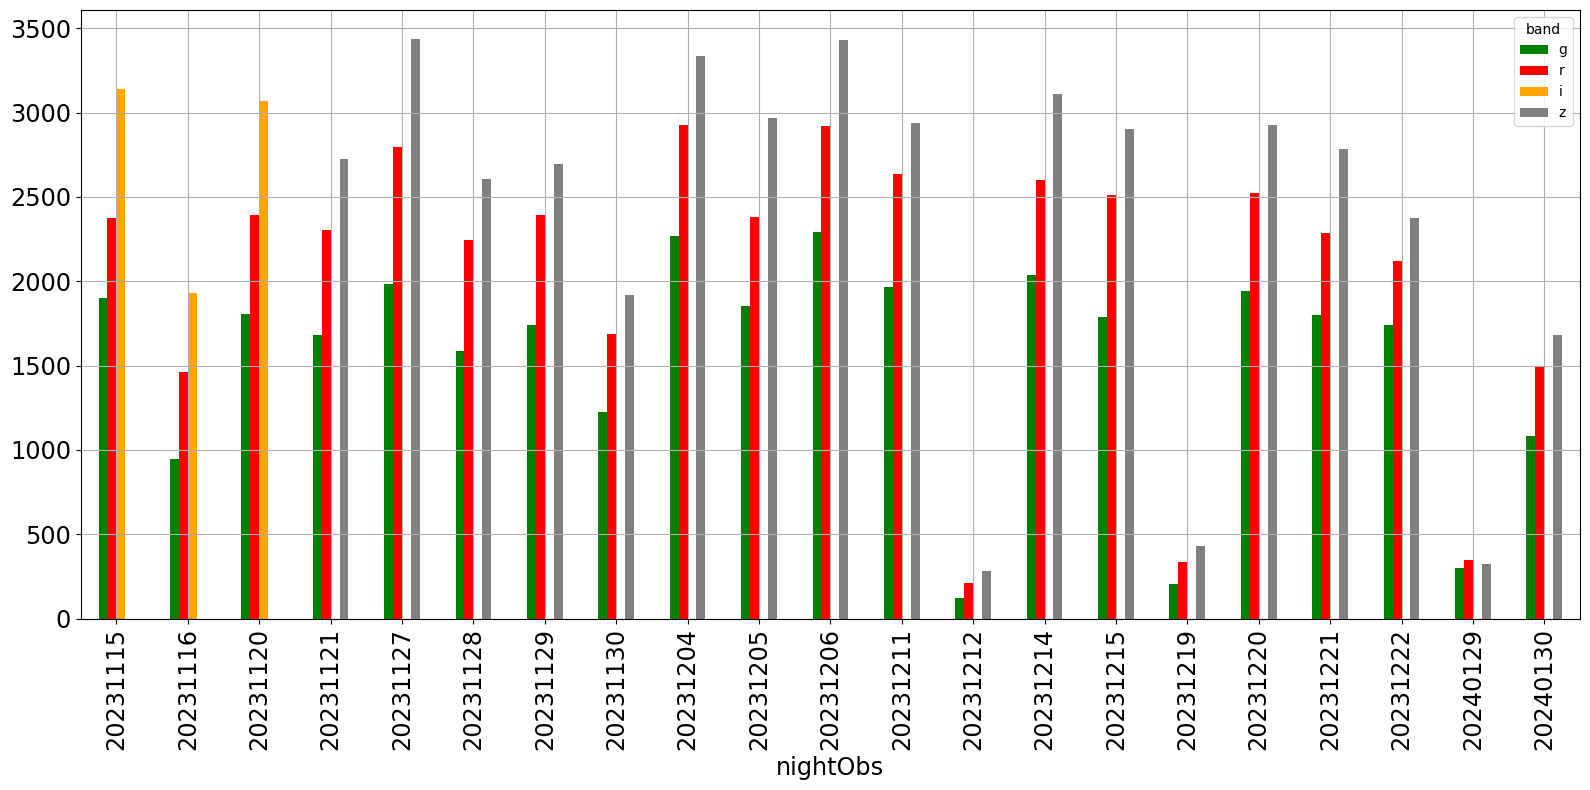

In [21]:
ax = df_stat.unstack(level=1)[["g","r","i","z"]].plot(kind='bar', subplots=False, rot=90,figsize=(16,8),grid=True,color=["g","r","orange","grey","k"])
plt.tight_layout()

In [22]:
df_stat_unstack = df_stat.unstack(level=1)[["g","r","i","z"]]

In [23]:
def convertNumToDatestr(num):
    year = num//10_000
    month= (num-year*10_000)//100
    day = (num-year*10_000-month*100)

    year_str = str(year).zfill(4)
    month_str = str(month).zfill(2)
    day_str = str(day).zfill(2)
    
    datestr = f"{year_str}-{month_str}-{day_str}"
    return pd.to_datetime(datestr)

In [24]:
all_datetimes = [convertNumToDatestr(num) for num in df_stat_unstack.index ]
df_stat_unstack["datetimes"] = all_datetimes
df_stat_unstack = df_stat_unstack.set_index("datetimes")

In [25]:
df_stat_unstack.index

DatetimeIndex(['2023-11-15', '2023-11-16', '2023-11-20', '2023-11-21',
               '2023-11-27', '2023-11-28', '2023-11-29', '2023-11-30',
               '2023-12-04', '2023-12-05', '2023-12-06', '2023-12-11',
               '2023-12-12', '2023-12-14', '2023-12-15', '2023-12-19',
               '2023-12-20', '2023-12-21', '2023-12-22', '2024-01-29',
               '2024-01-30'],
              dtype='datetime64[ns]', name='datetimes', freq=None)

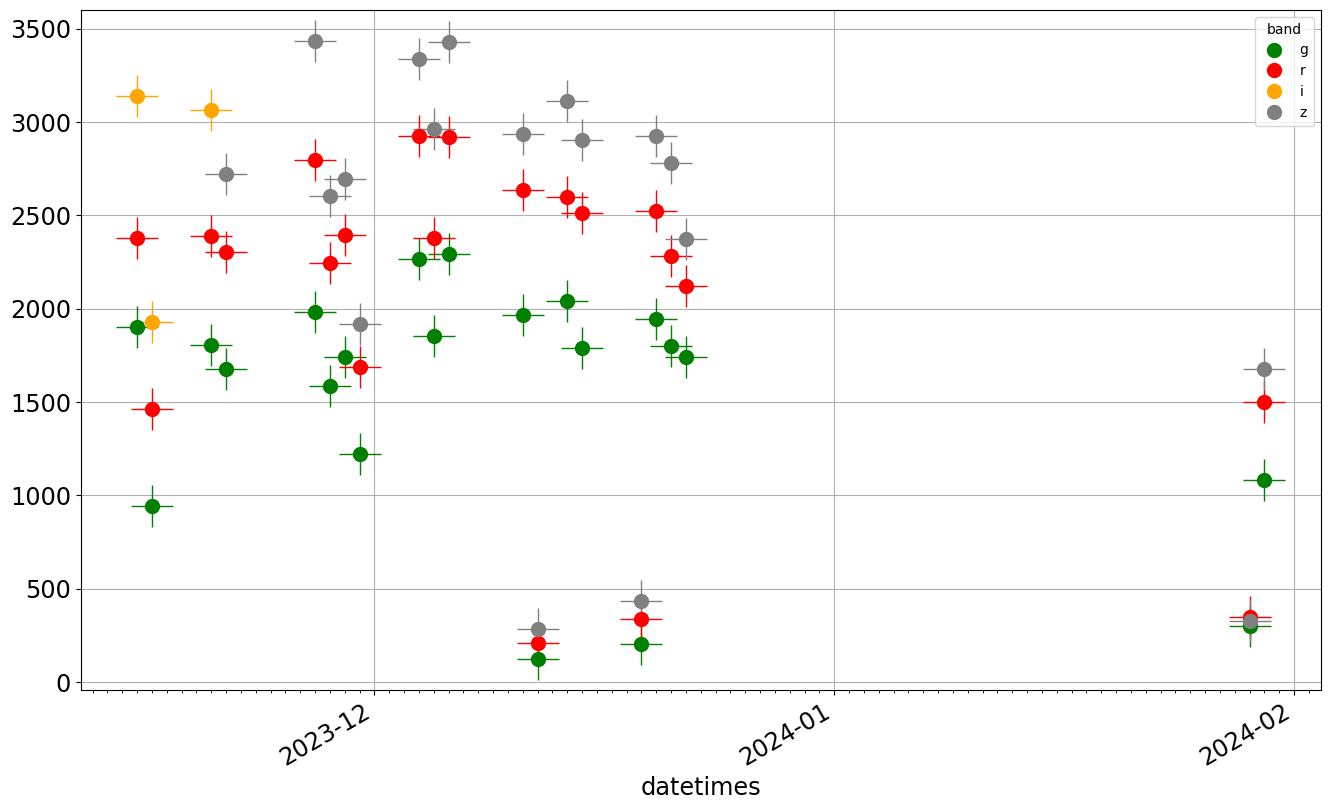

In [26]:
import matplotlib.dates as mdates
month_locator = mdates.MonthLocator(interval=1)
day_locator = mdates.DayLocator(interval=1)
year_month_formatter = mdates.DateFormatter("%Y-%m") 
fig, ax = plt.subplots(1,1,figsize=(16, 10))



# fit 1
#df_stat_unstack.plot( kind='bar', rot=0,ax=ax)
df_stat_unstack.plot( marker="+",markersize=30,lw=0,color=["g","r","orange","grey","k"],ax=ax,legend=False)
df_stat_unstack.plot( marker="o",markersize=10,lw=0,color=["g","r","orange","grey","k"],ax=ax)
#df_stat_unstack.plot( kind="bar",x=df_stat_unstack.index,color=["g","r","orange","grey","k"],ax=ax)

#ax.set_xticks(ax.get_xticks(), ax.get_xticklabels(), rotation=45, ha='right')
#ax.set_xticklabels(labels=df_stat_unstack.index, rotation=70, rotation_mode="anchor", ha="right");
ax.xaxis.set_major_locator(month_locator) # Locator for major axis only.
ax.xaxis.set_minor_locator(day_locator)
ax.xaxis.set_major_formatter(year_month_formatter)
ax.grid()
#plt.tight_layout()

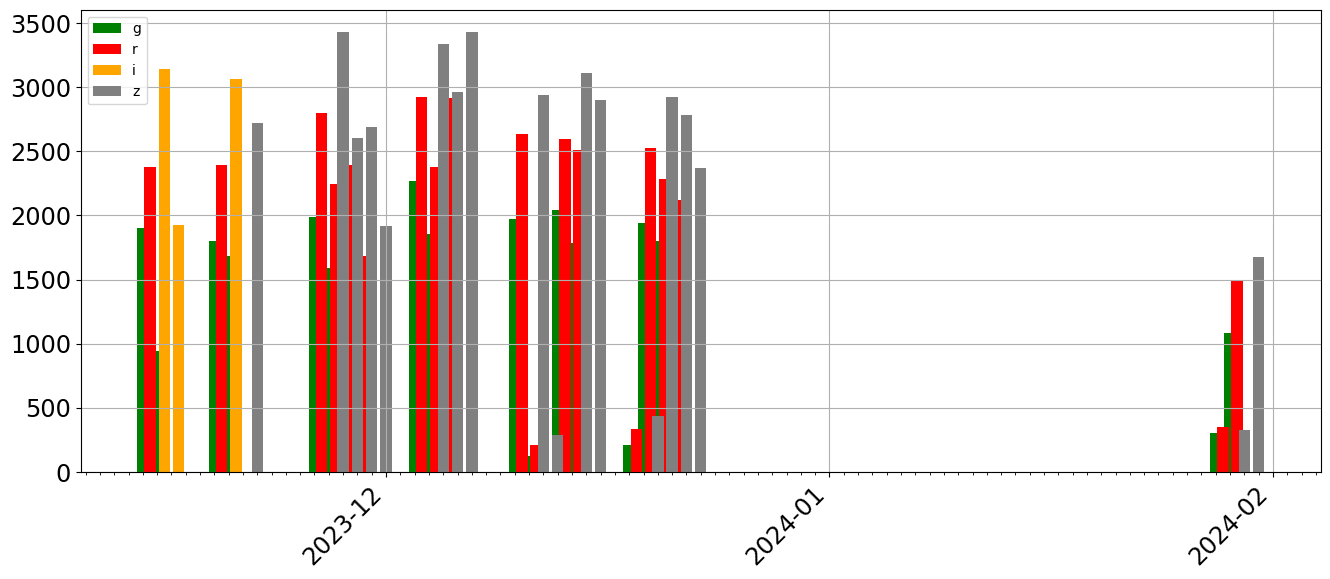

In [27]:
import matplotlib.dates as mdates
month_locator = mdates.MonthLocator(interval=1)
day_locator = mdates.DayLocator(interval=1)
year_month_formatter = mdates.DateFormatter("%Y-%m") 
dt = timedelta(hours=12)
fig, ax = plt.subplots(1,1,figsize=(16, 6))

ax.bar(df_stat_unstack.index-2*dt,df_stat_unstack["g"],color="g",label="g")
ax.bar(df_stat_unstack.index-dt,df_stat_unstack["r"],color="r",label="r")
ax.bar(df_stat_unstack.index+dt,df_stat_unstack["i"],color="orange",label="i")
ax.bar(df_stat_unstack.index+2*dt,df_stat_unstack["z"],color="grey",label="z")
ax.legend()

ax.xaxis.set_major_locator(month_locator) # Locator for major axis only.
ax.xaxis.set_minor_locator(day_locator)
ax.xaxis.set_major_formatter(year_month_formatter)
ax.set_xticks(ax.get_xticks(), ax.get_xticklabels(), rotation=45, ha='right')
ax.grid()
#plt.tight_layout()

## Select a date

In [28]:
DATEOBS =  20240130
cut = (df["nightObs"] == DATEOBS)
df = df[cut]

In [29]:
all_visits = df["visitId"].unique()

In [30]:
cmap = matplotlib.cm.inferno
cmap_reversed = matplotlib.cm.get_cmap('inferno_r')

/tmp/ipykernel_41933/99408613.py:2: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap_reversed = matplotlib.cm.get_cmap('inferno_r')


/tmp/ipykernel_41933/2000110147.py:10: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  fig, axs = plt.subplots(ncols=4,nrows=1,figsize=(16,4))


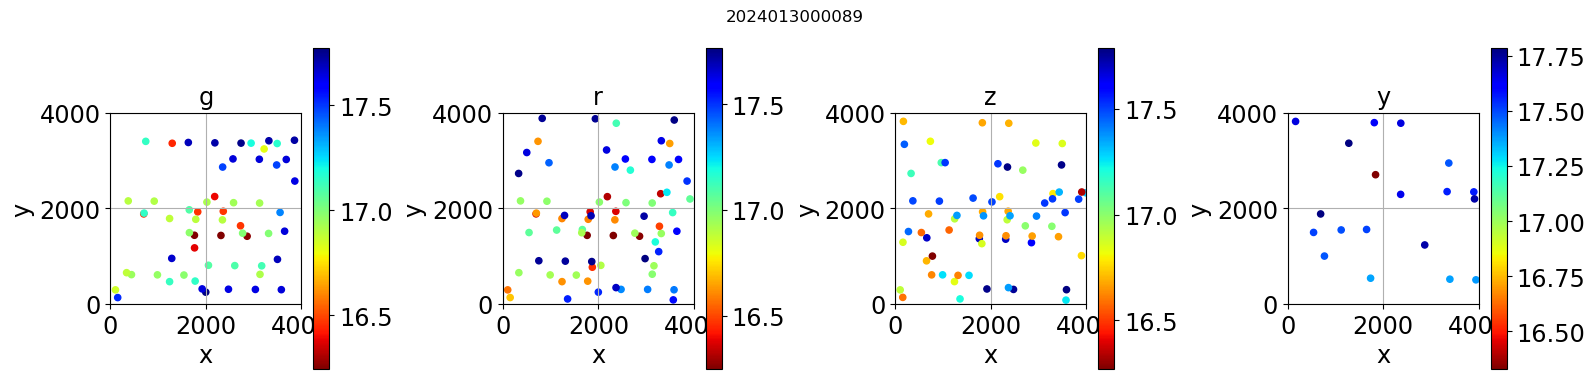

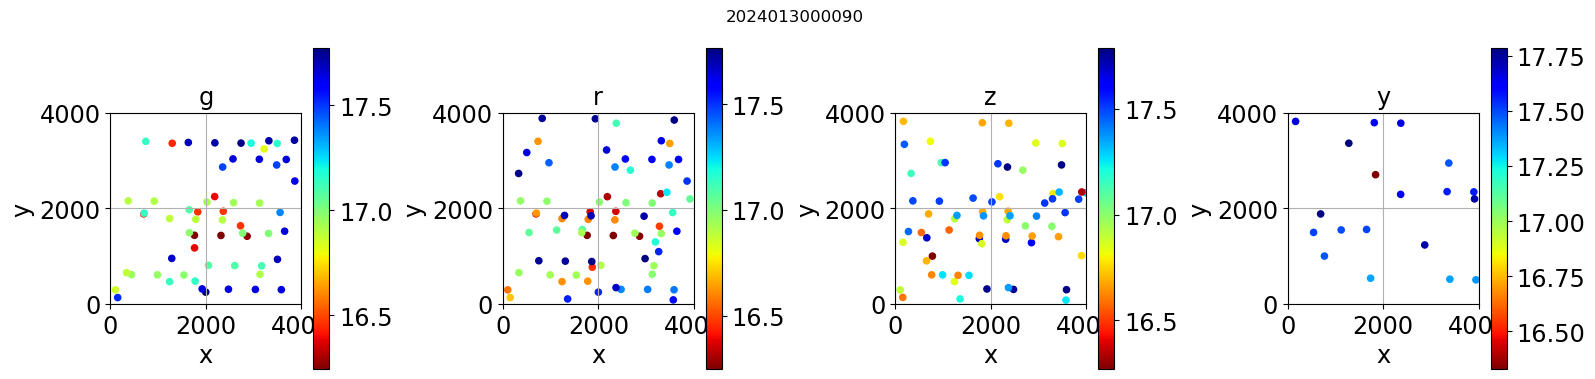

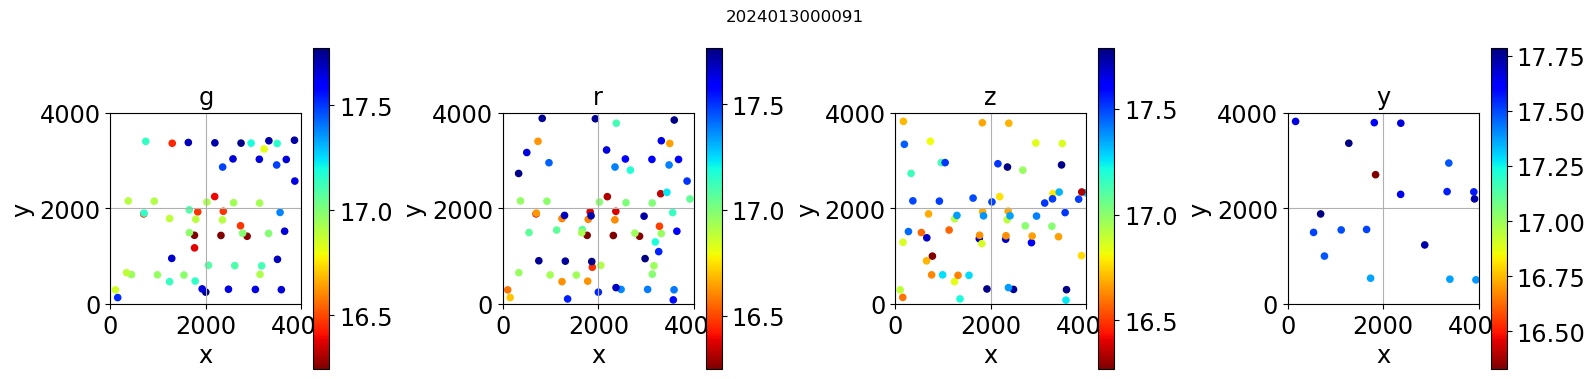

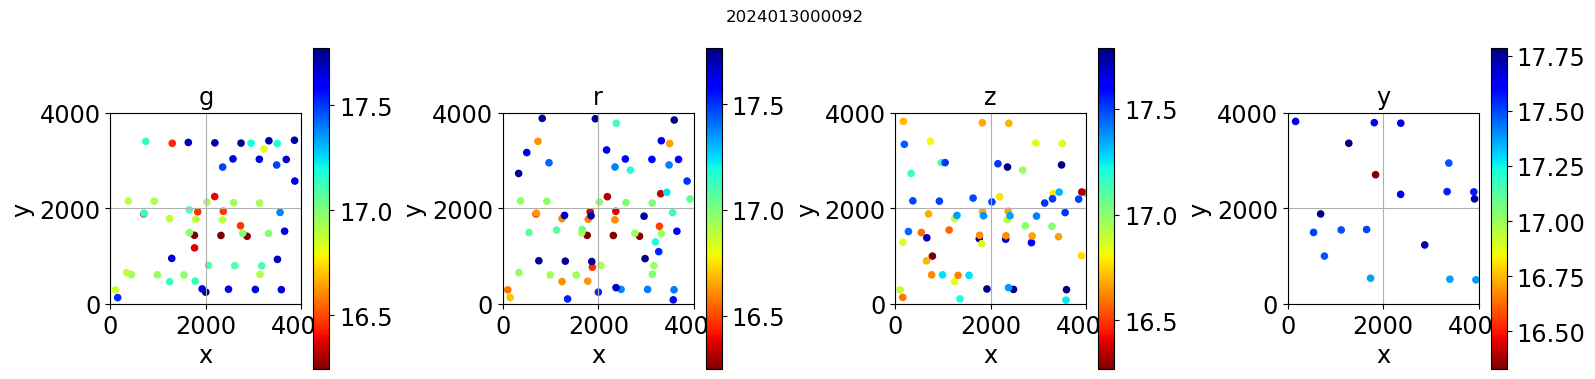

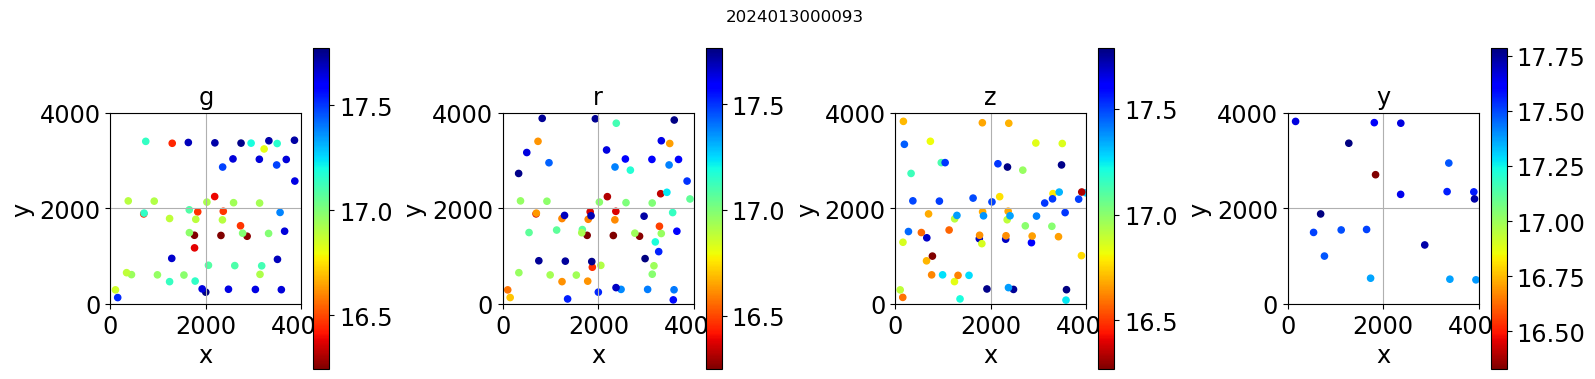

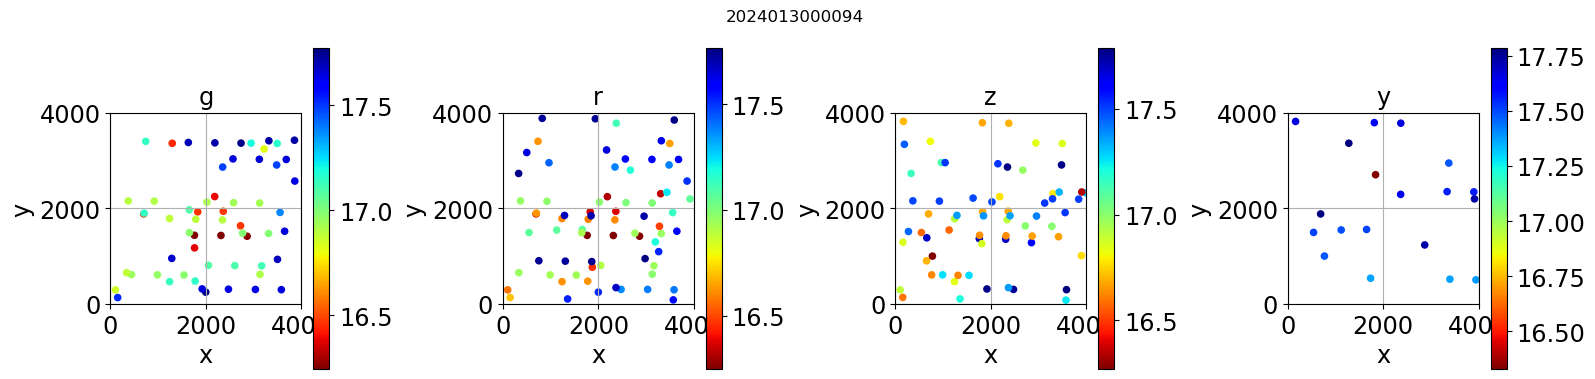

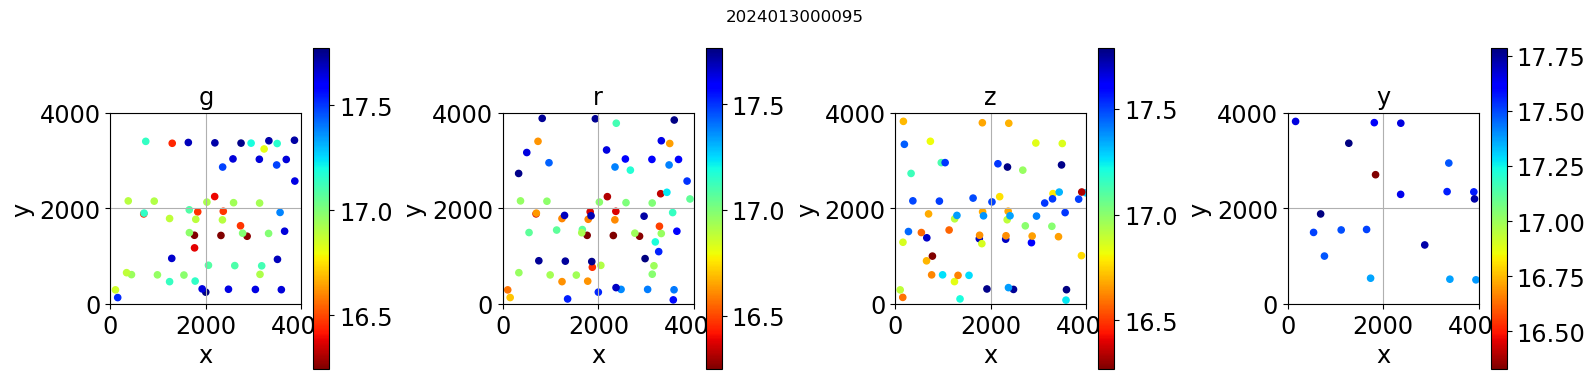

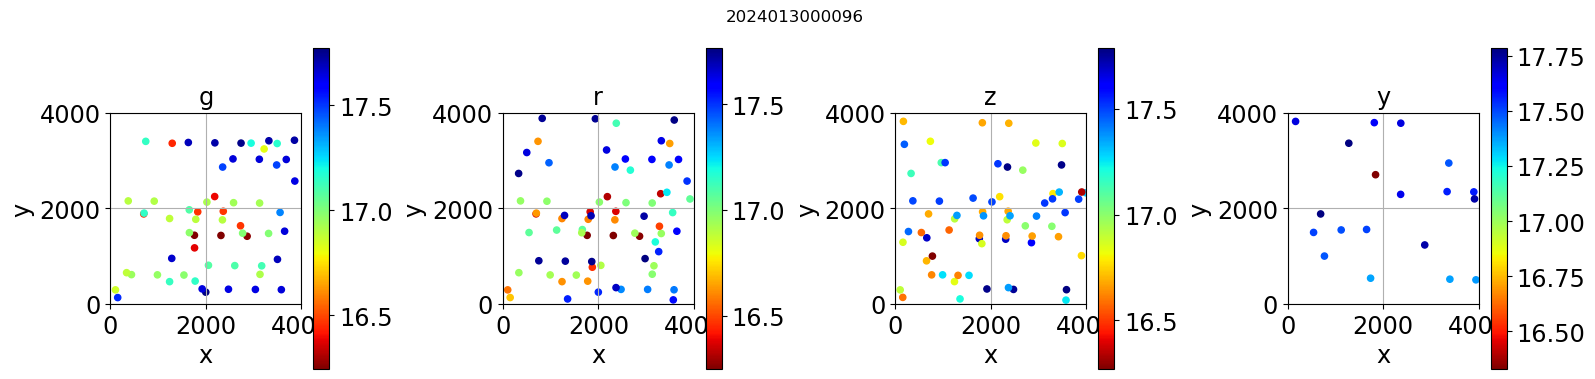

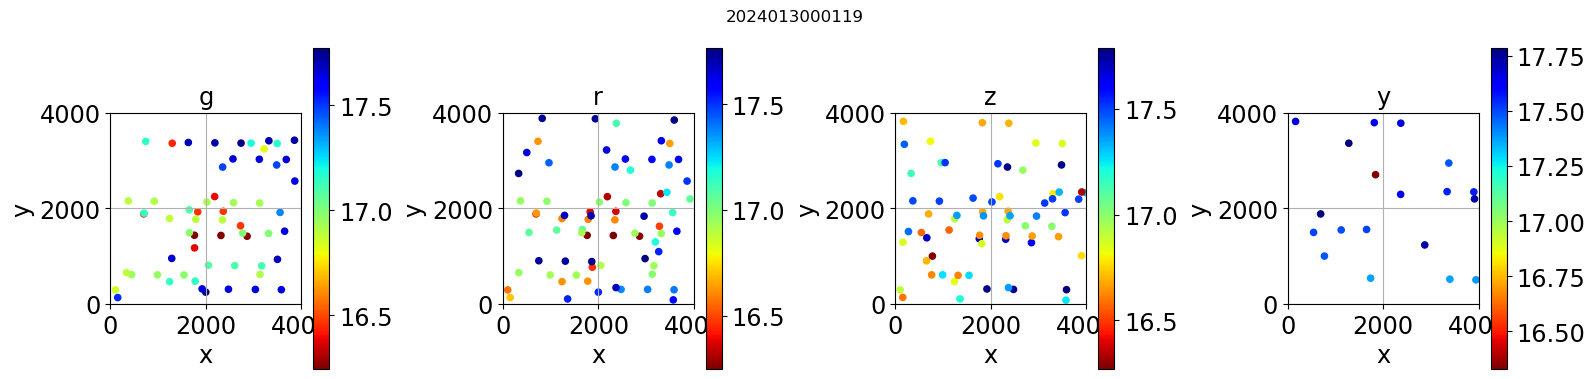

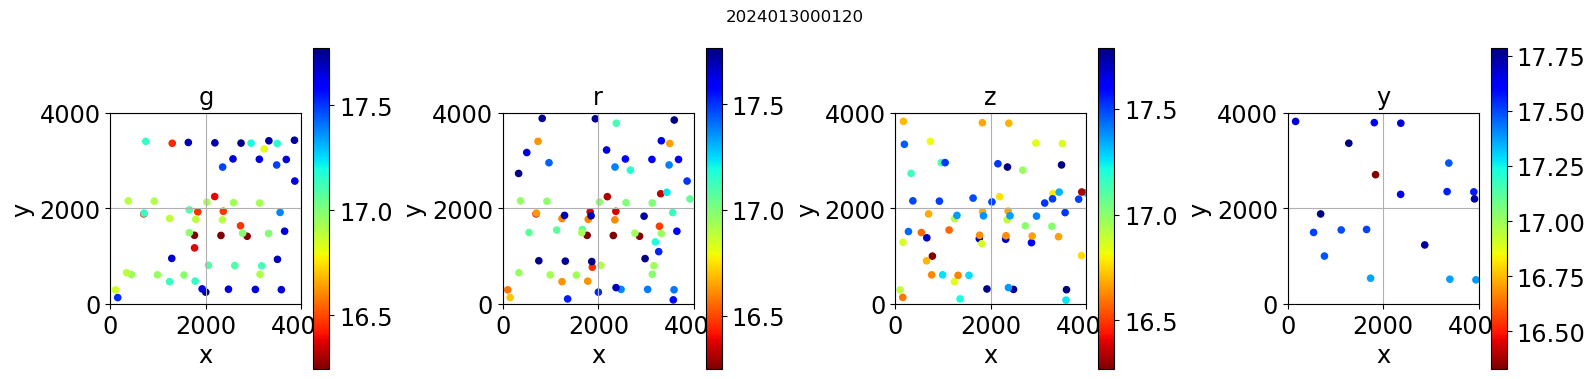

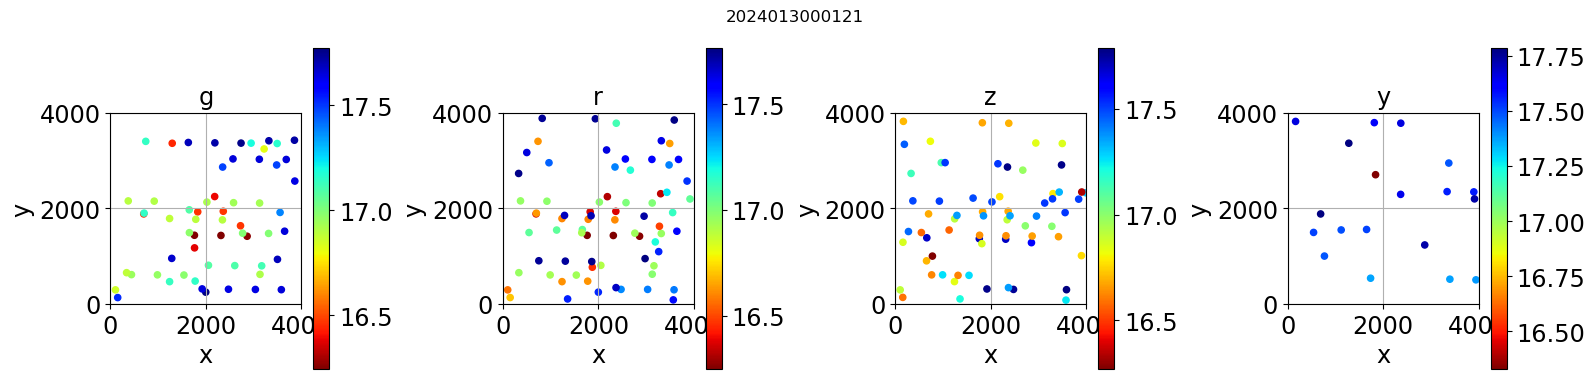

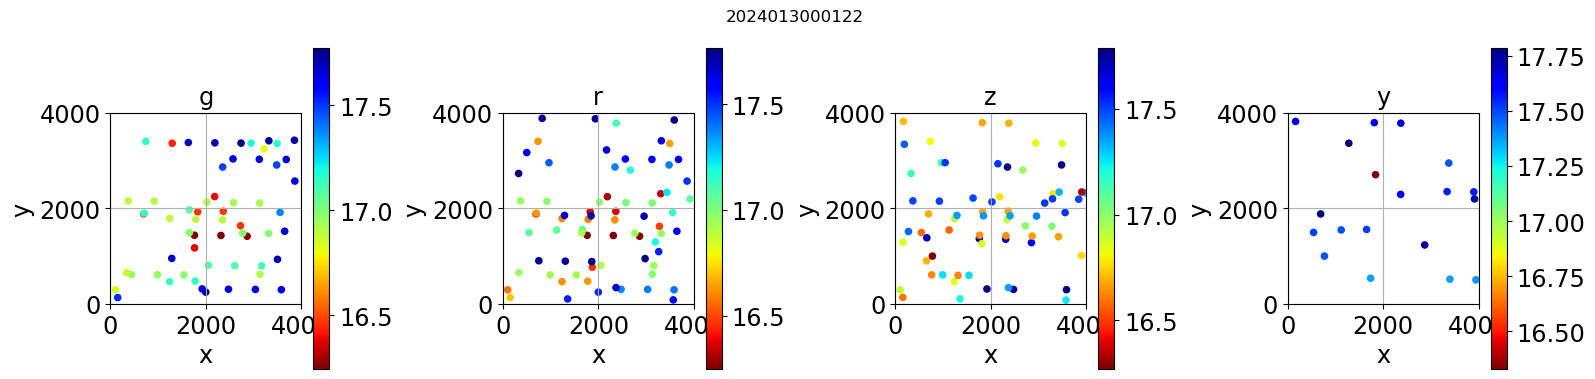

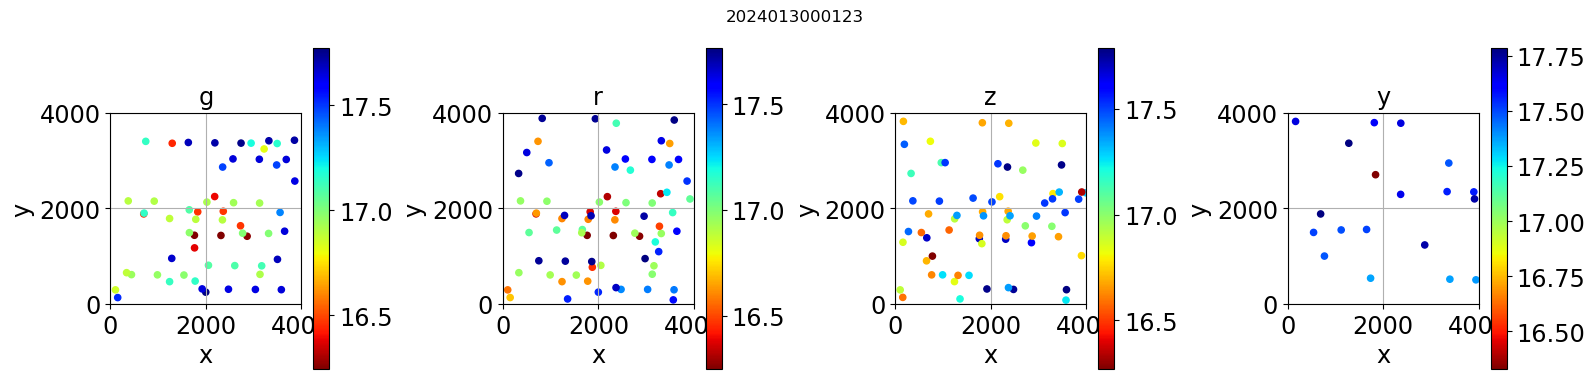

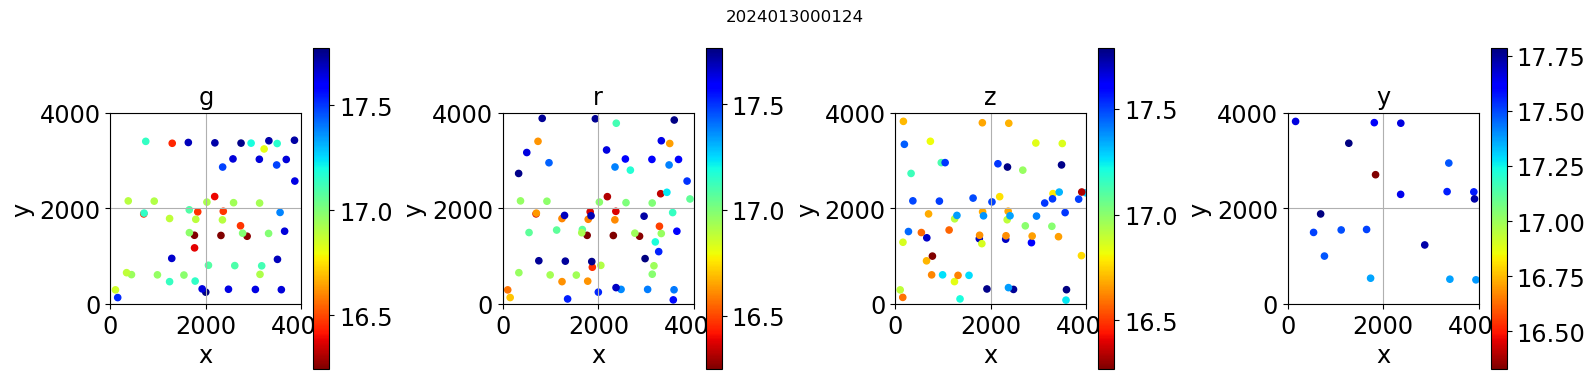

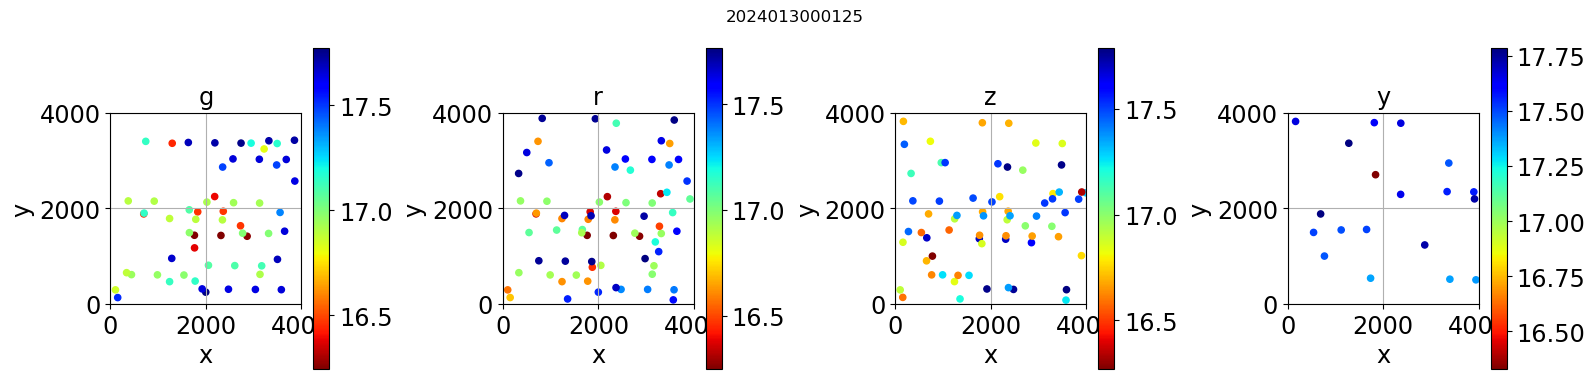

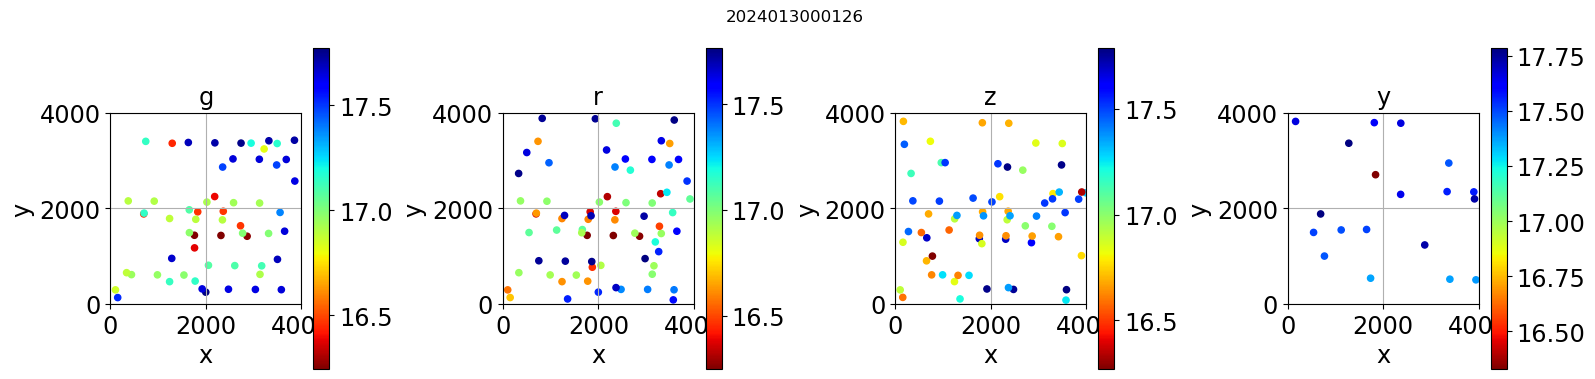

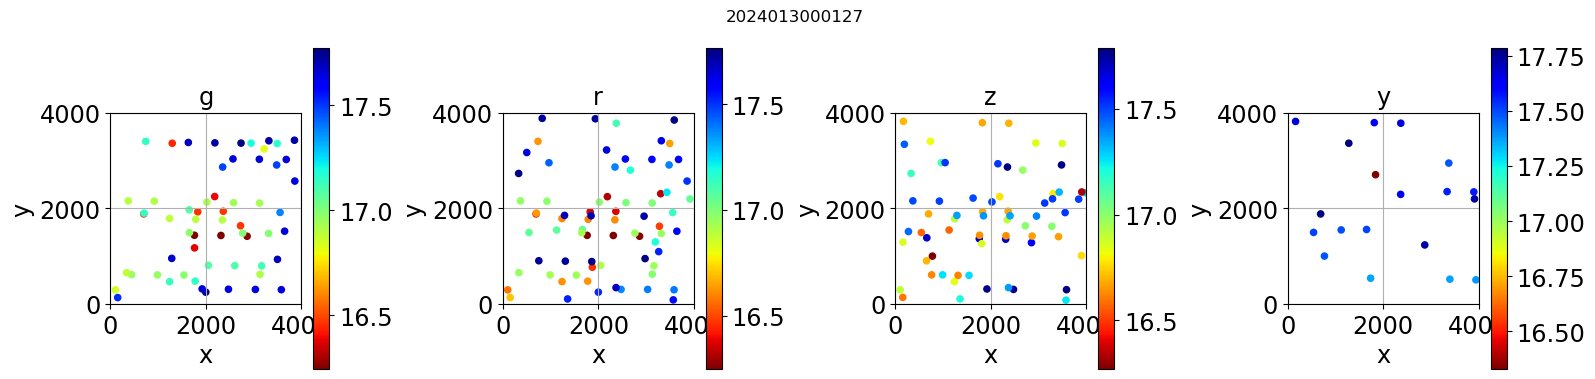

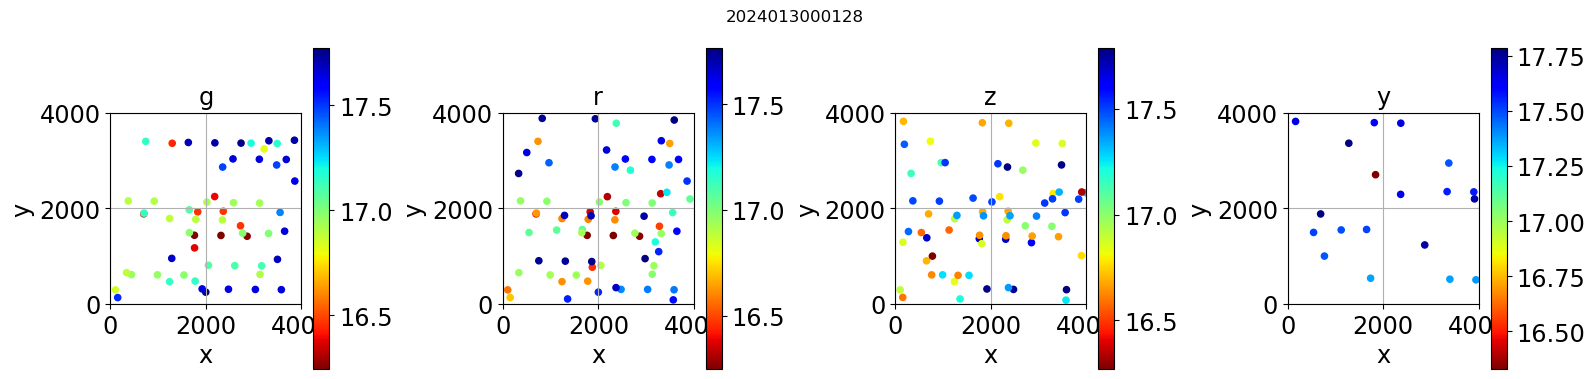

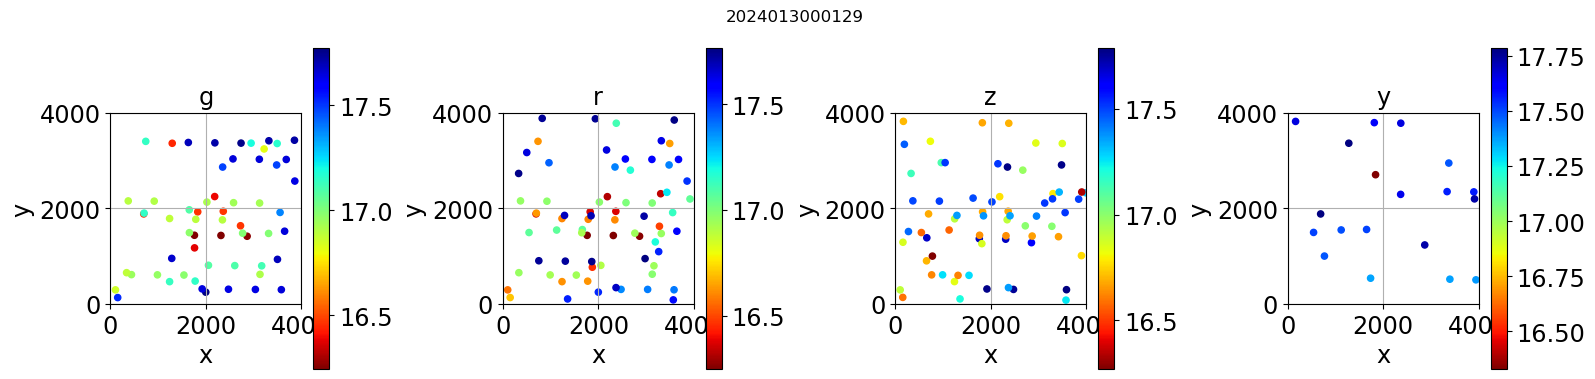

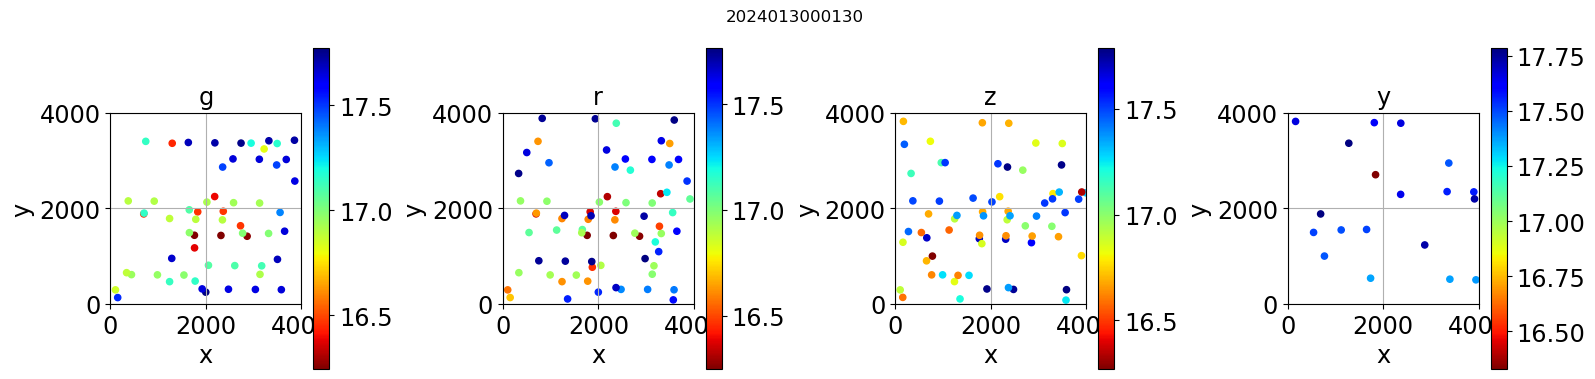

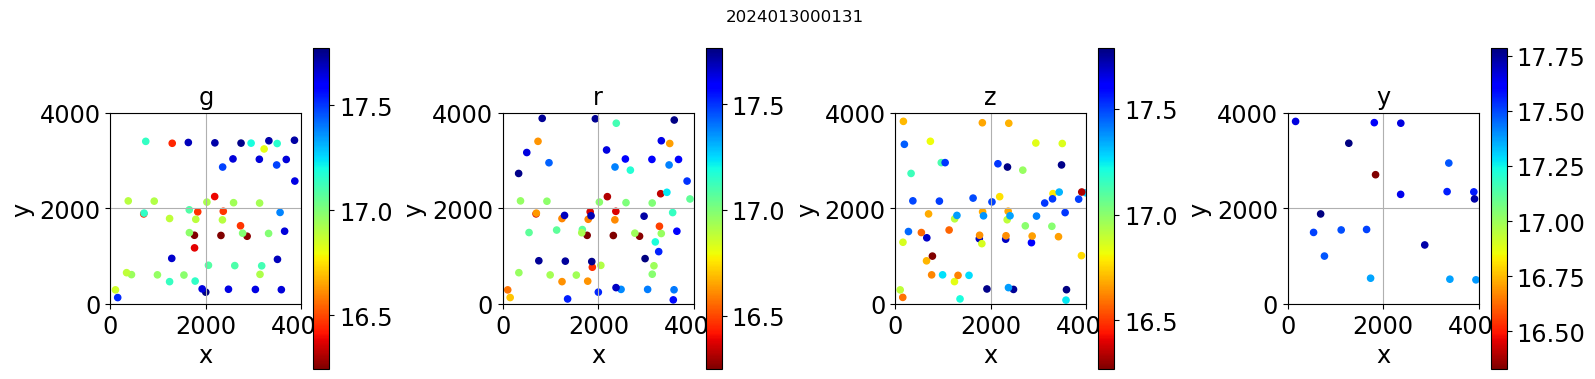

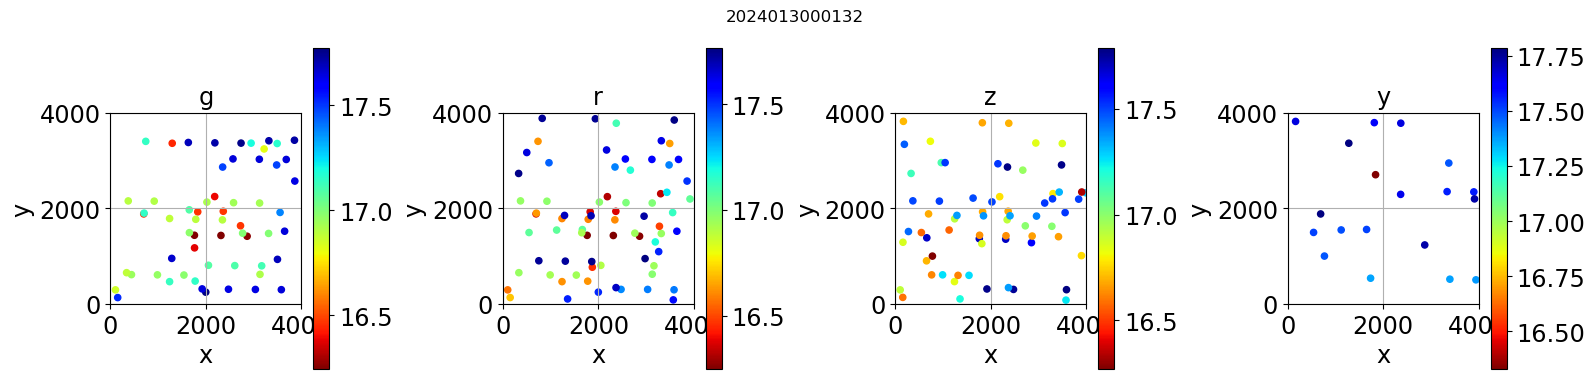

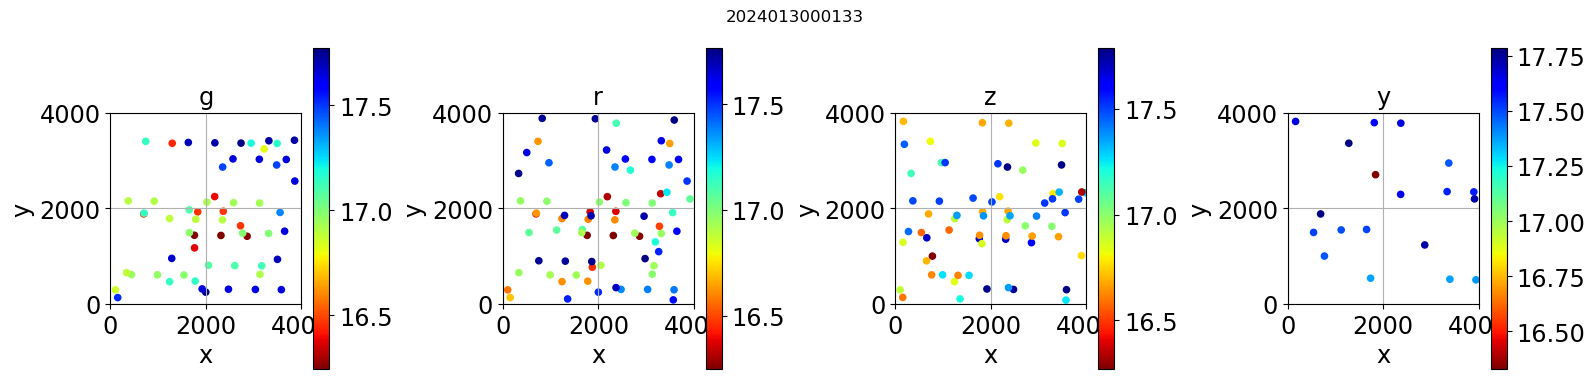

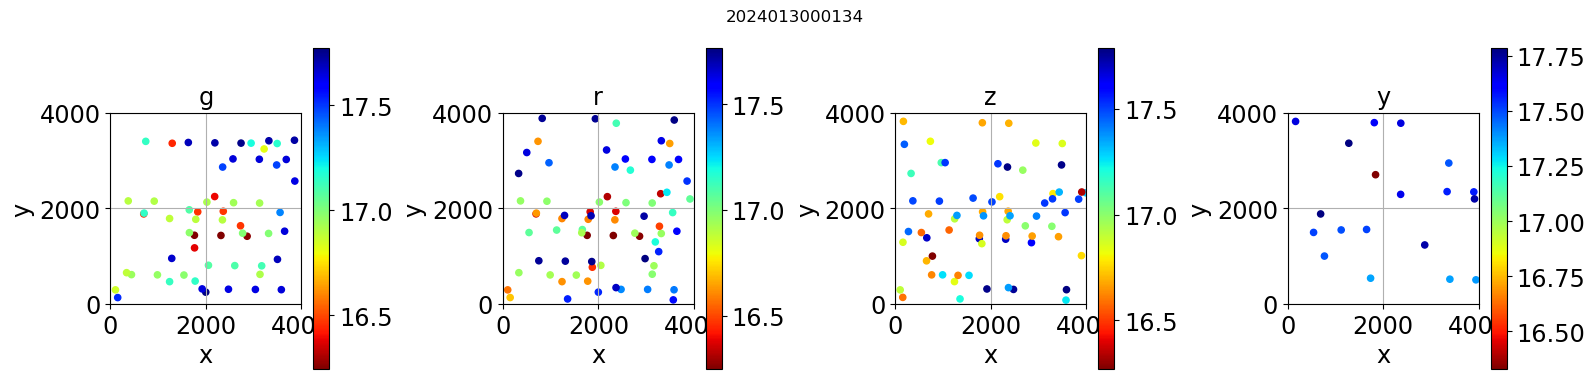

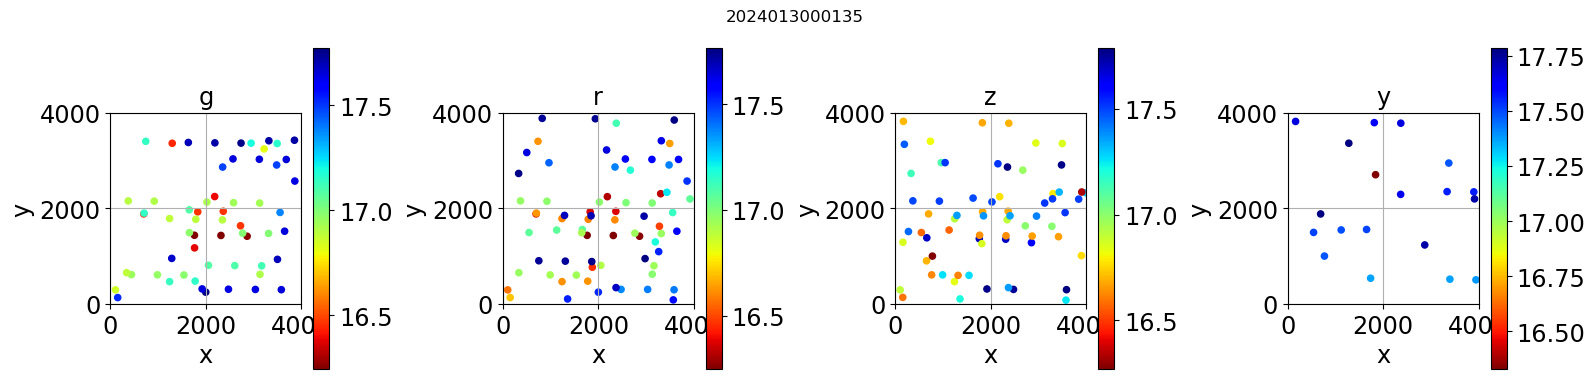

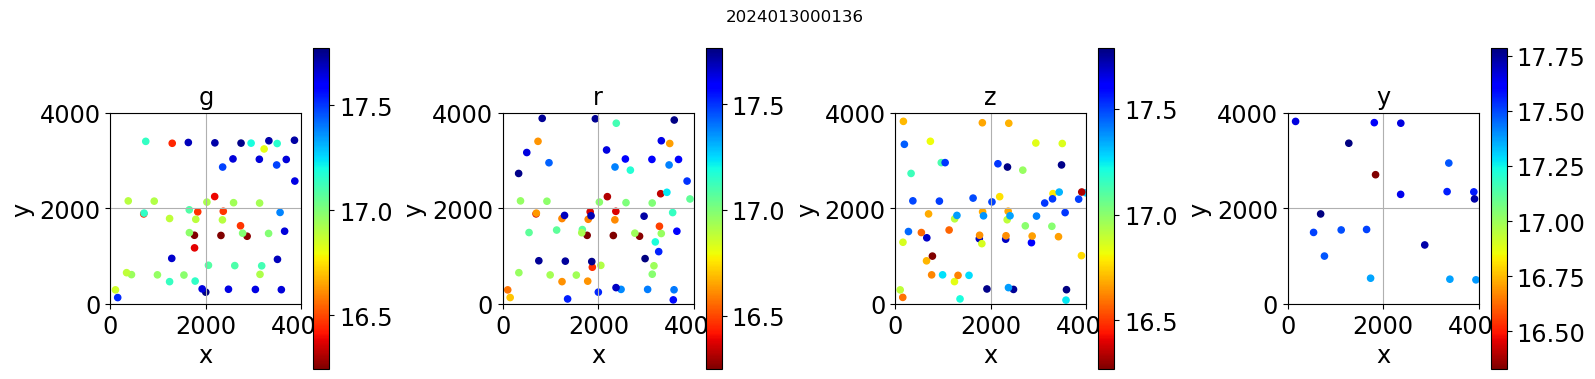

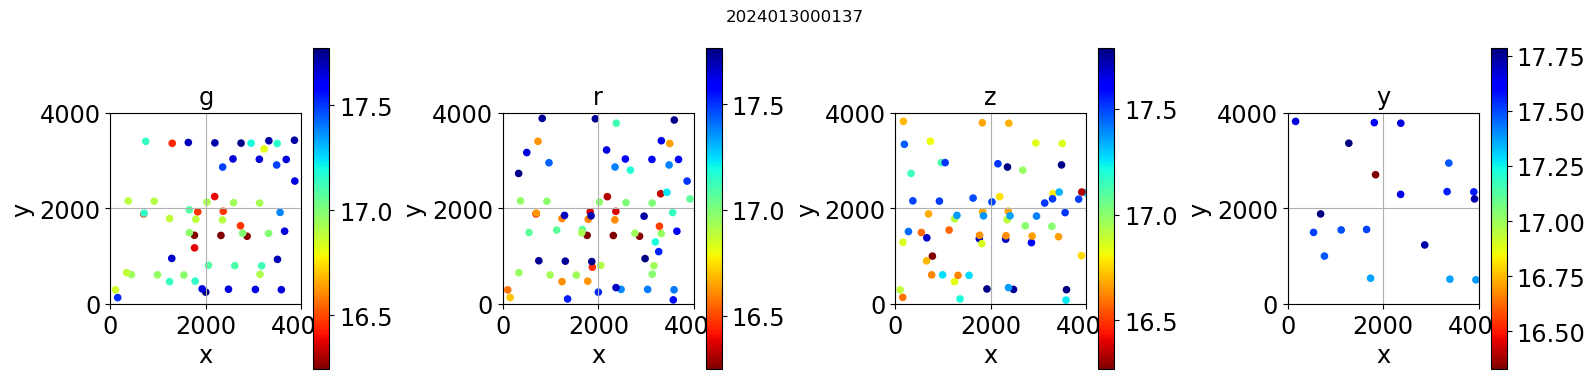

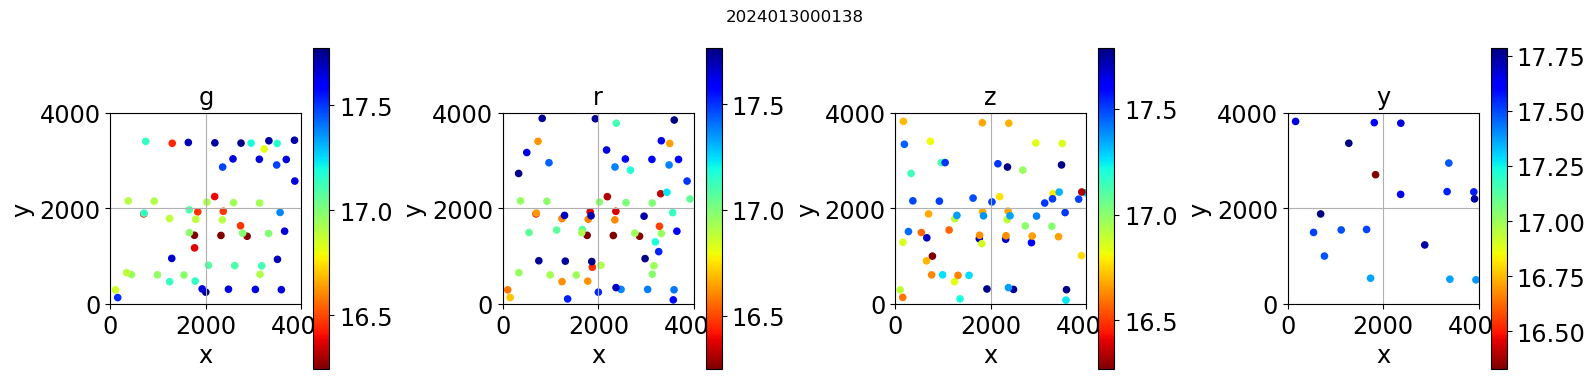

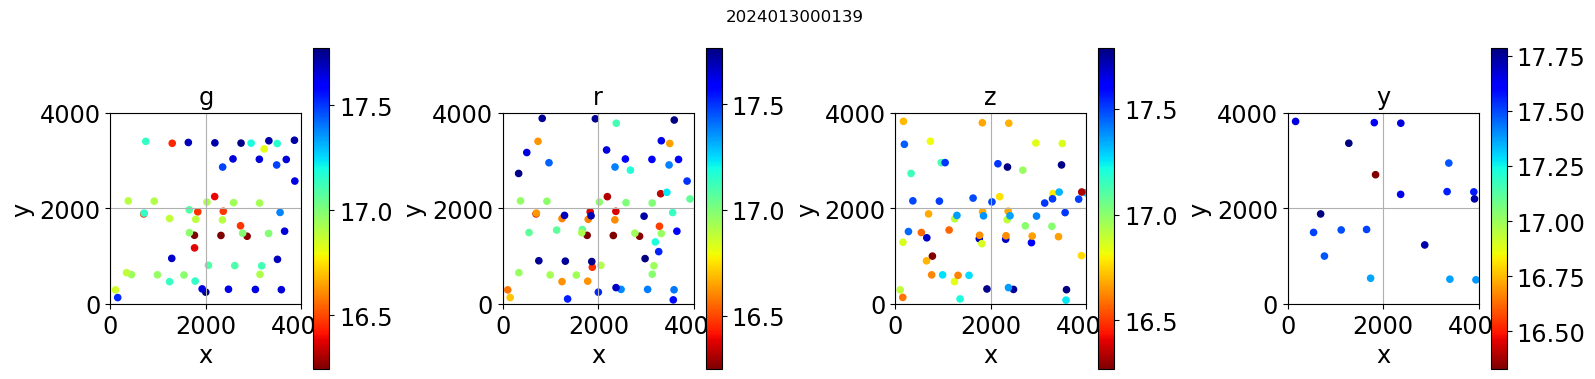

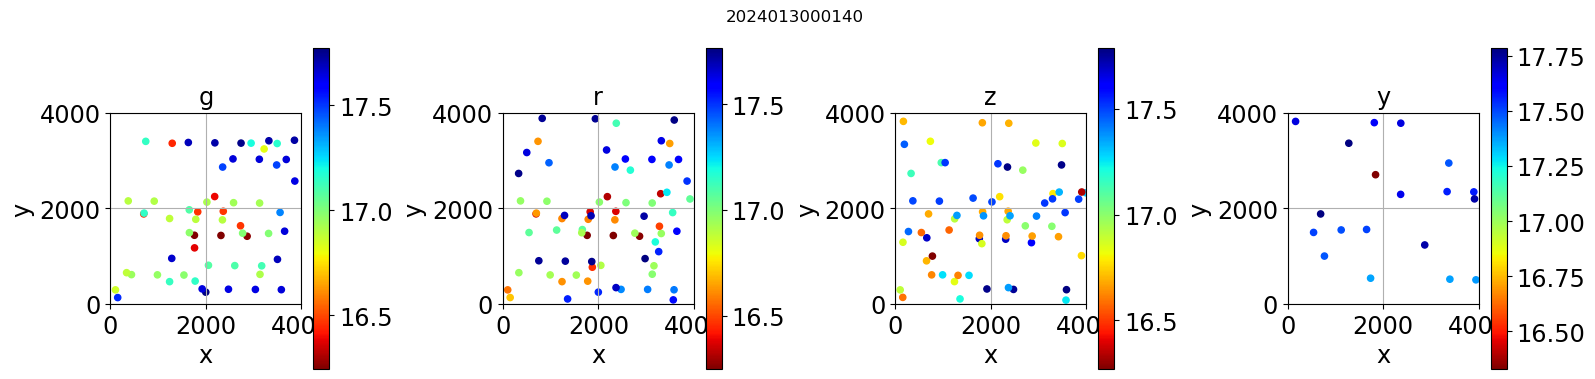

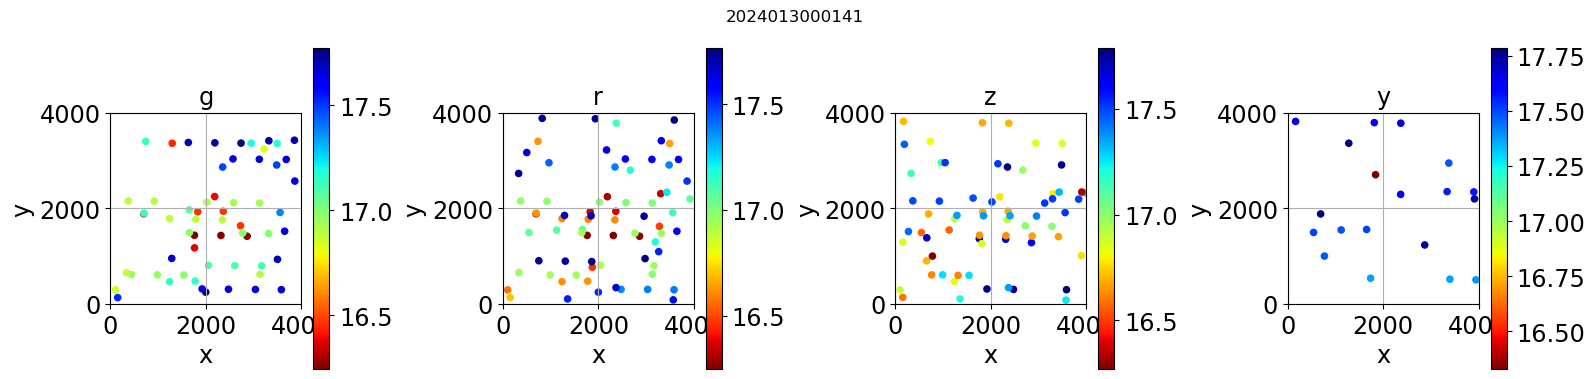

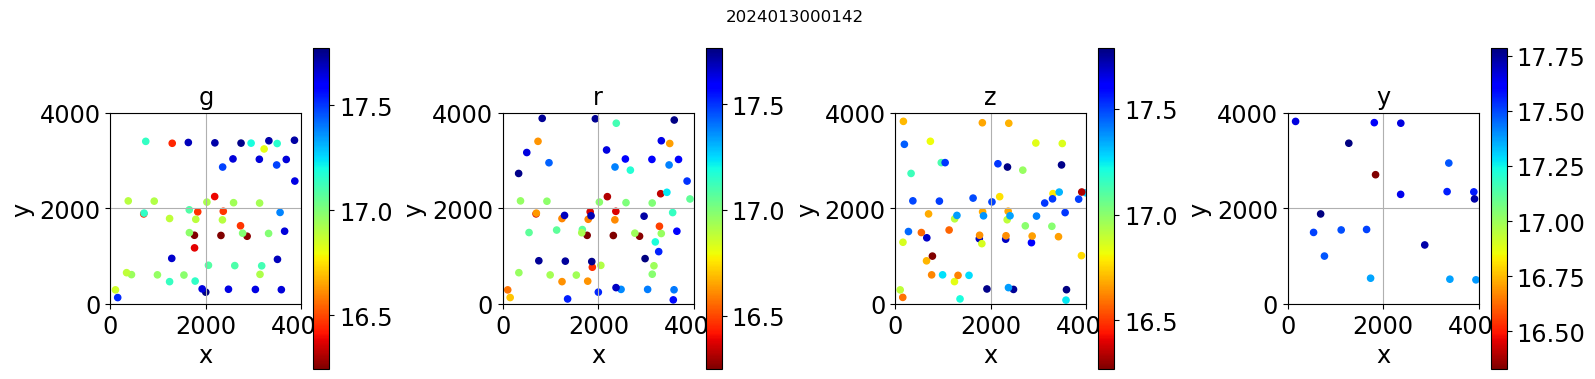

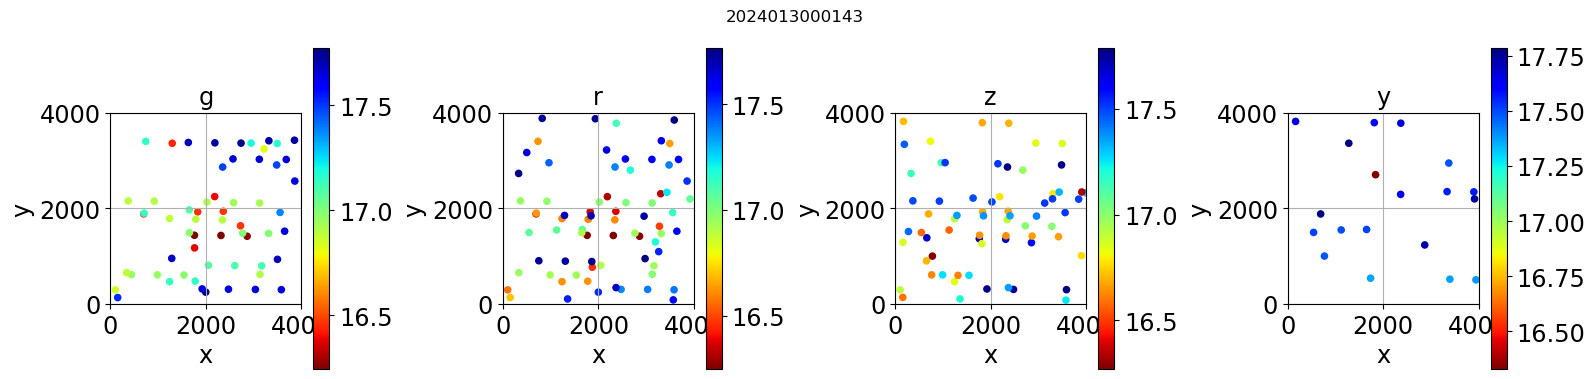

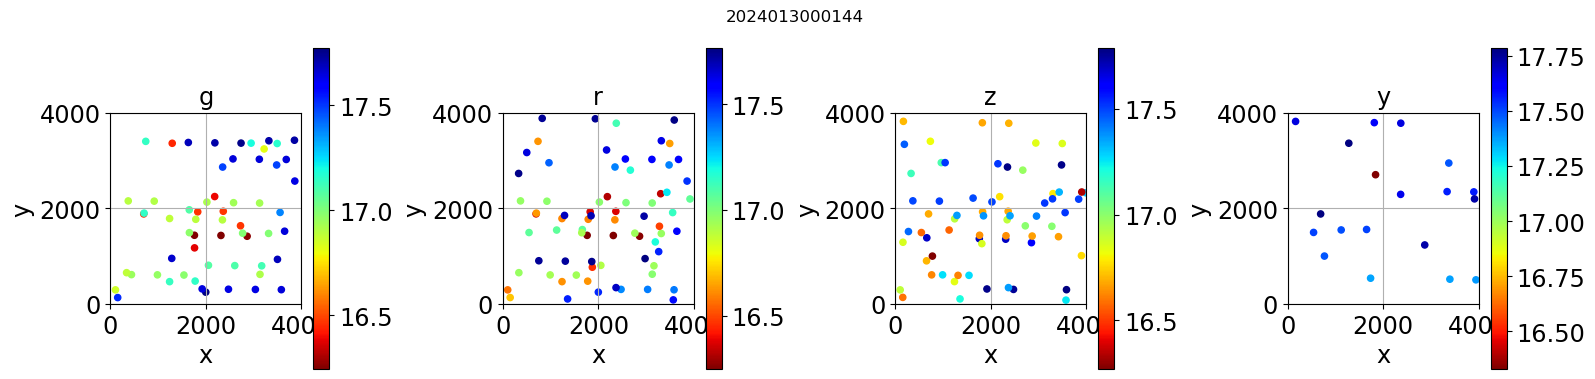

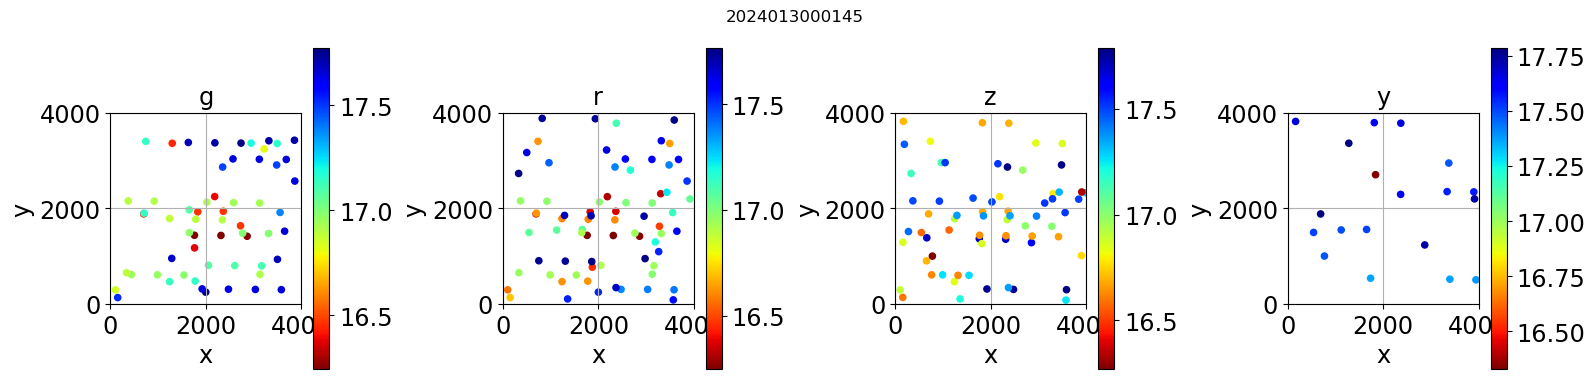

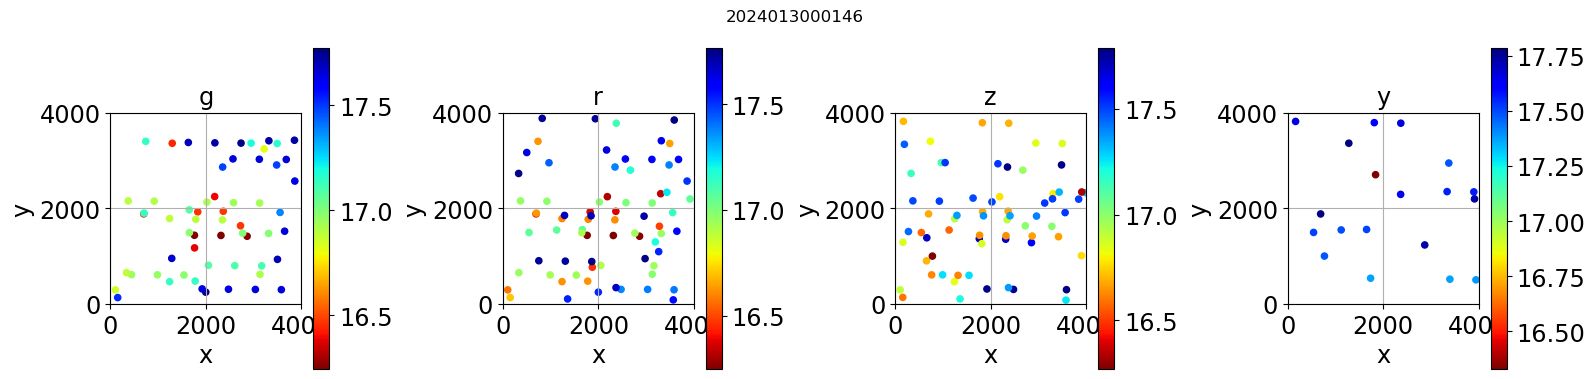

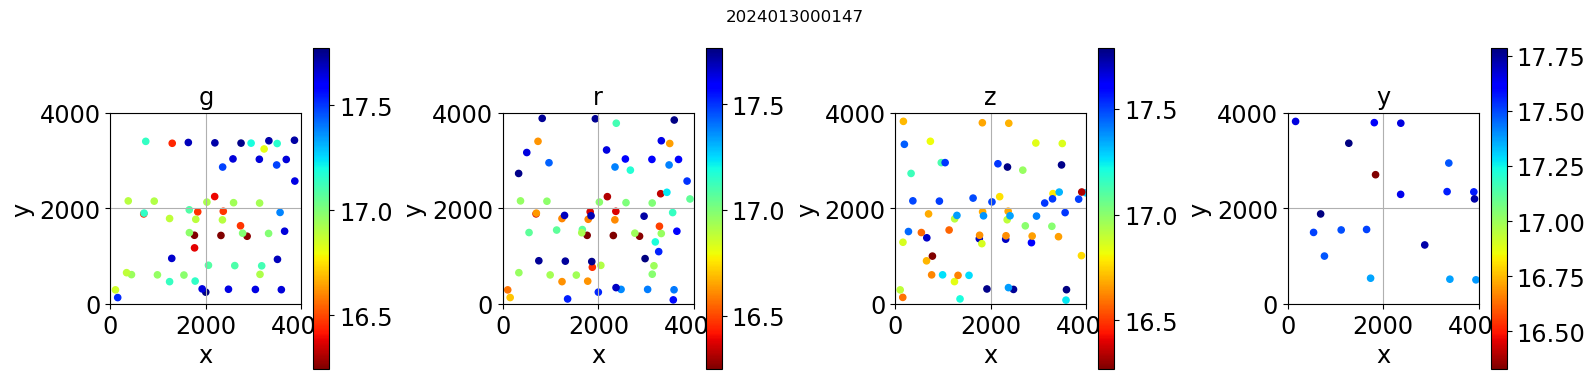

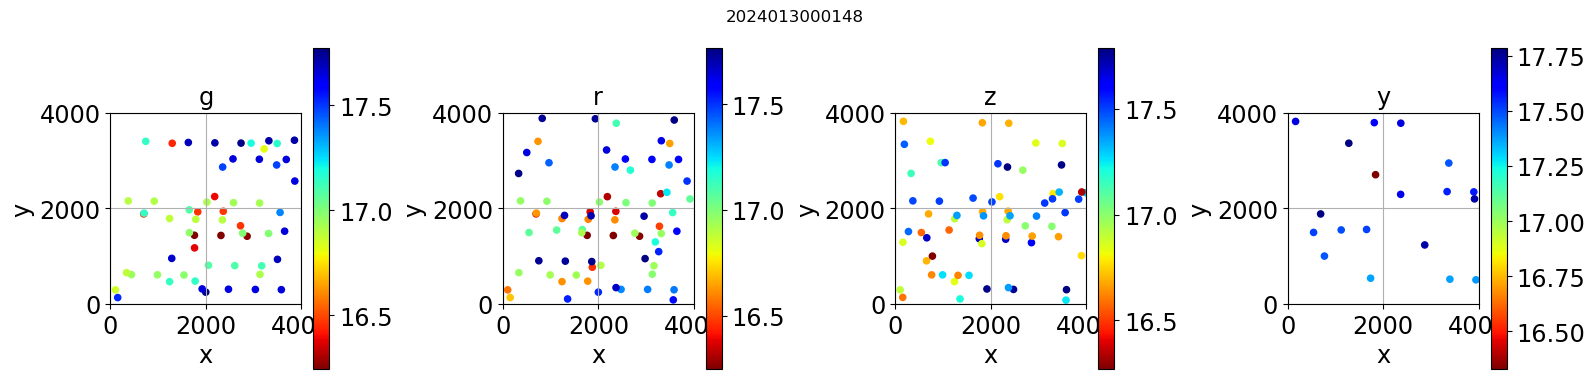

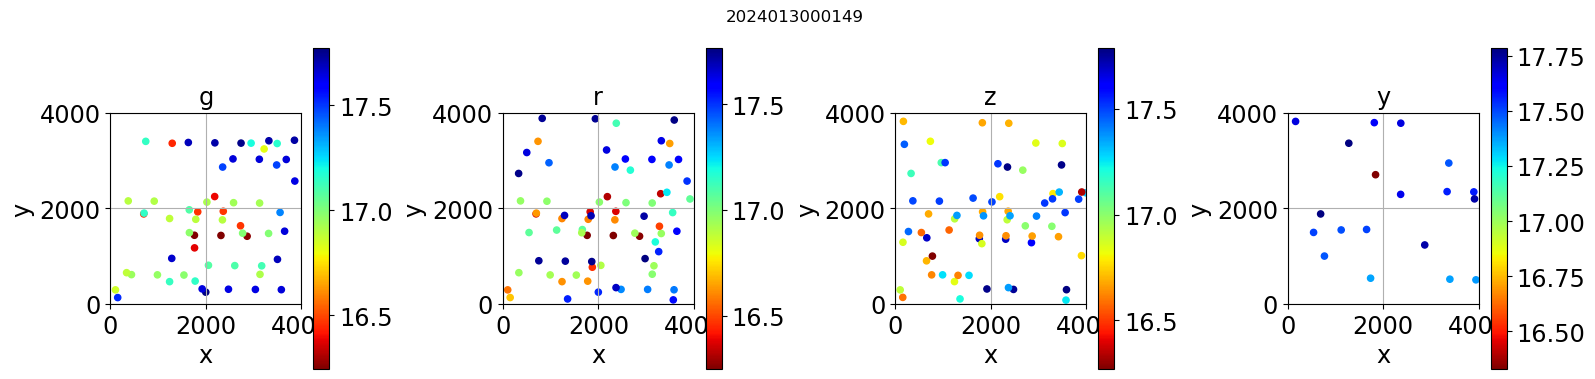

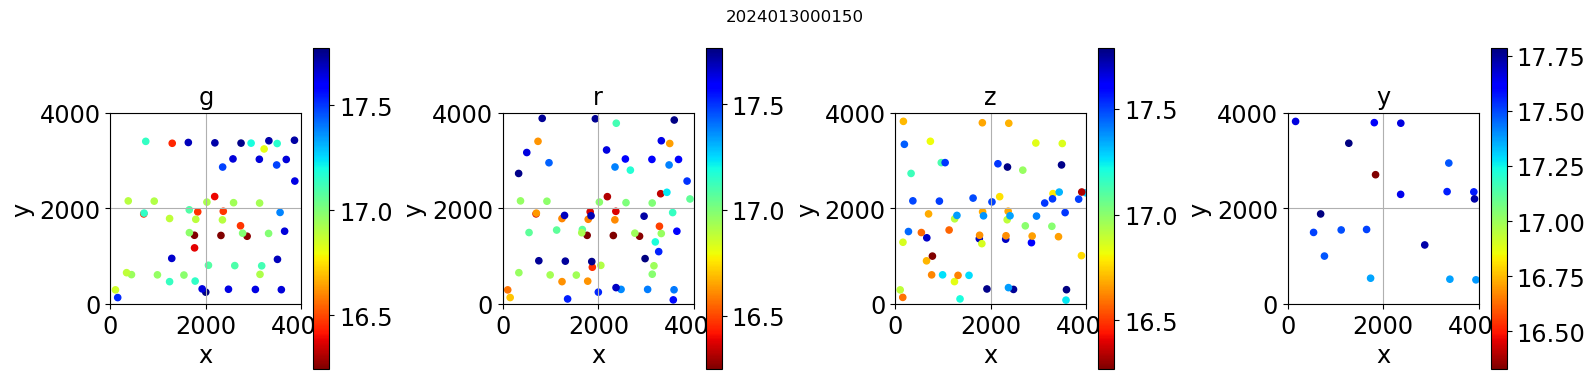

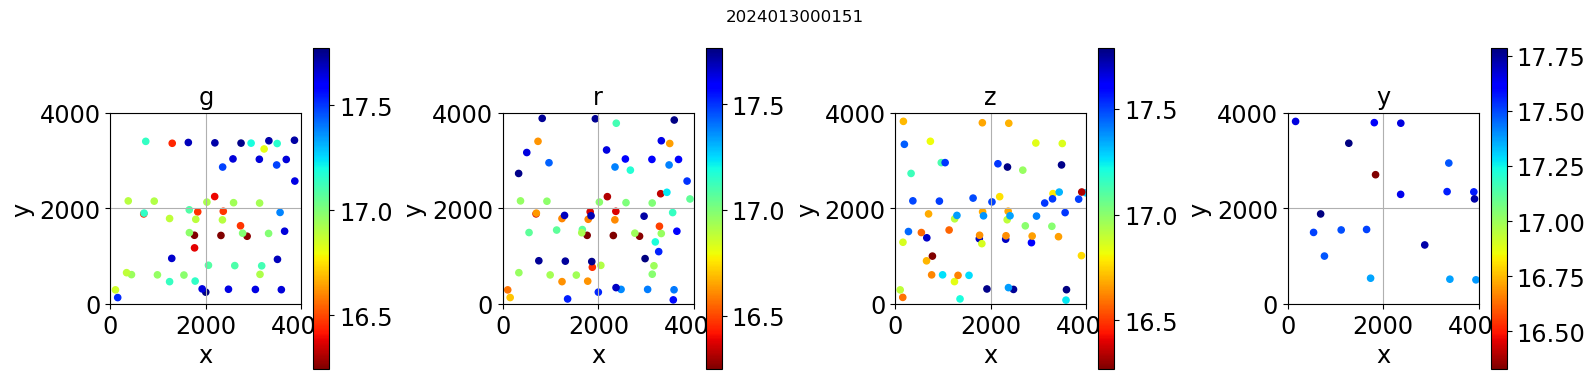

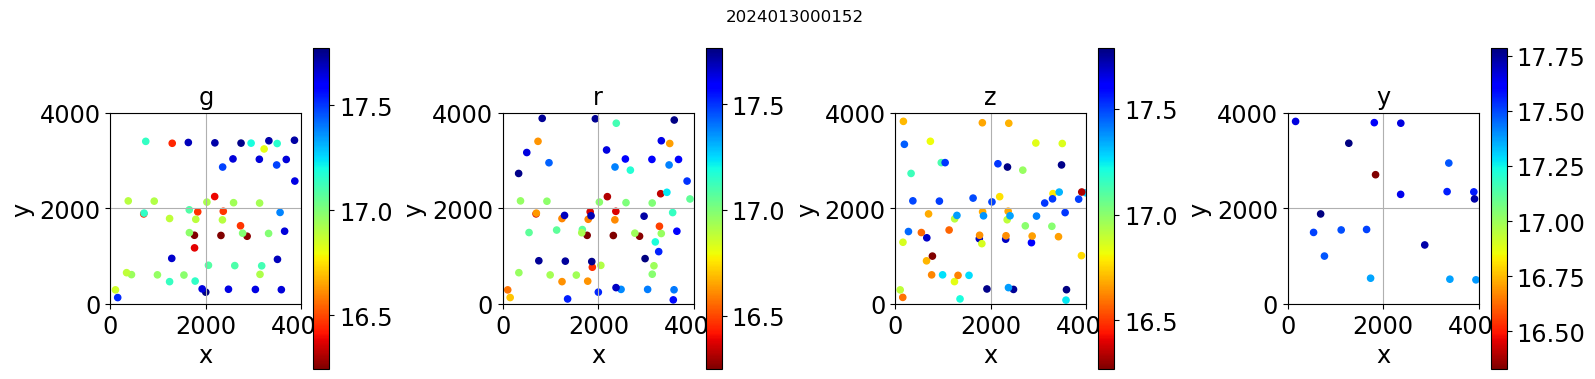

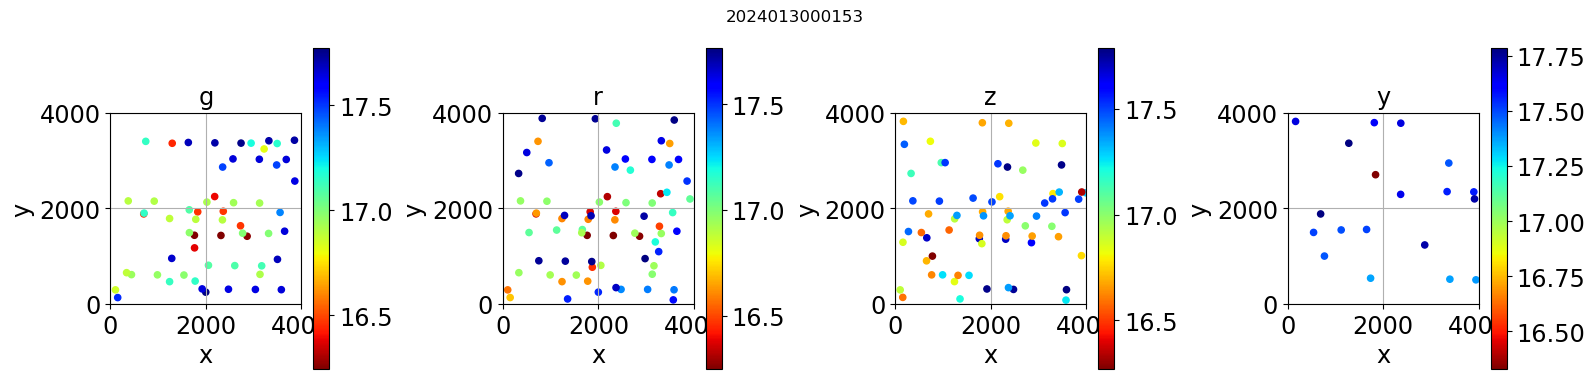

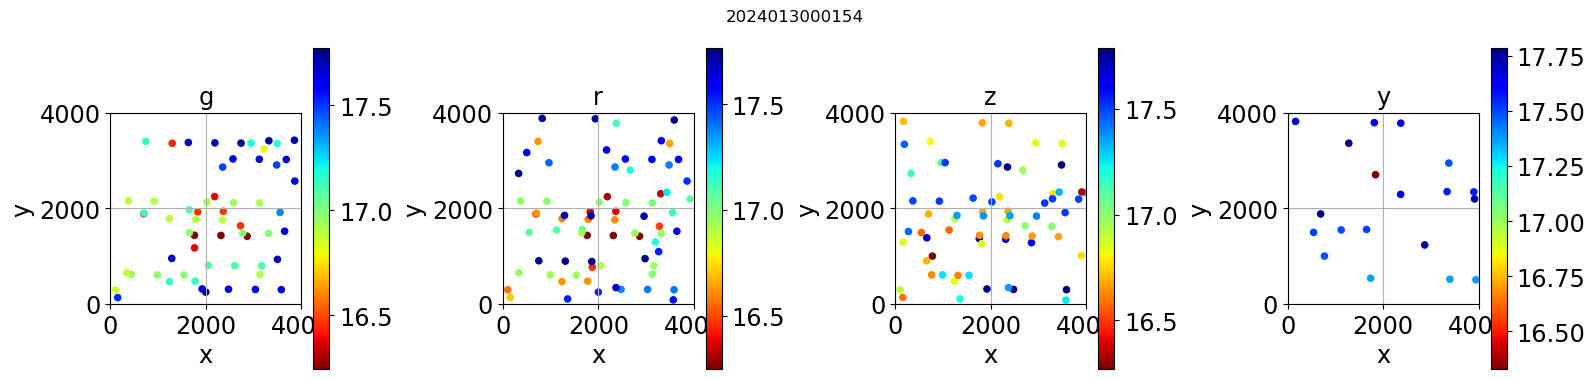

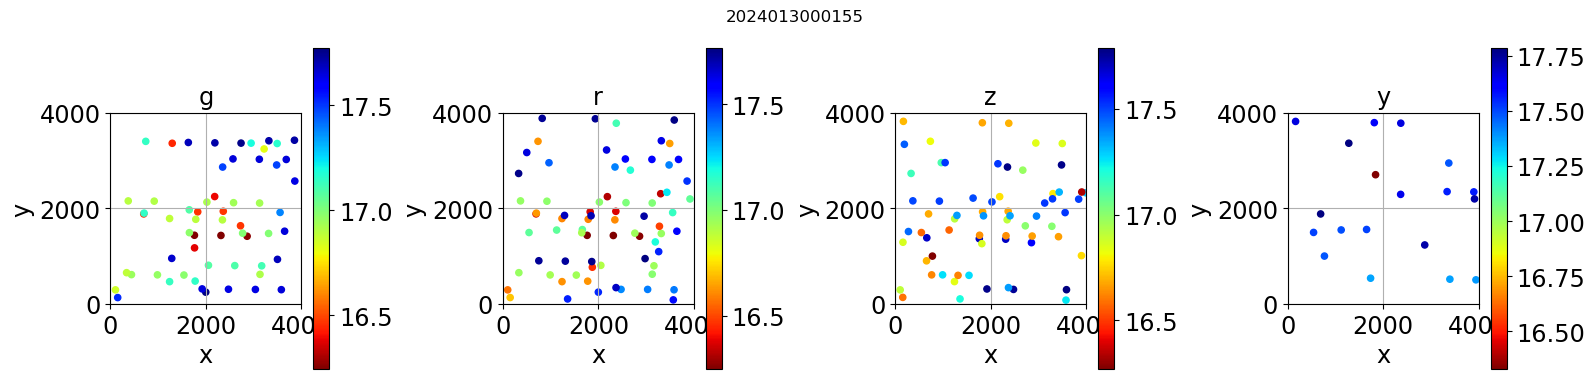

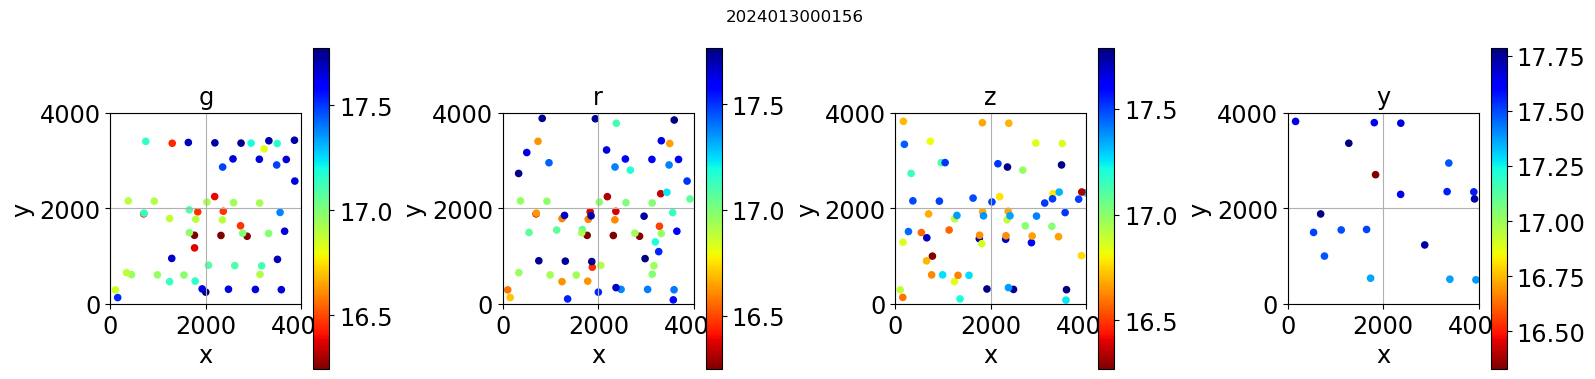

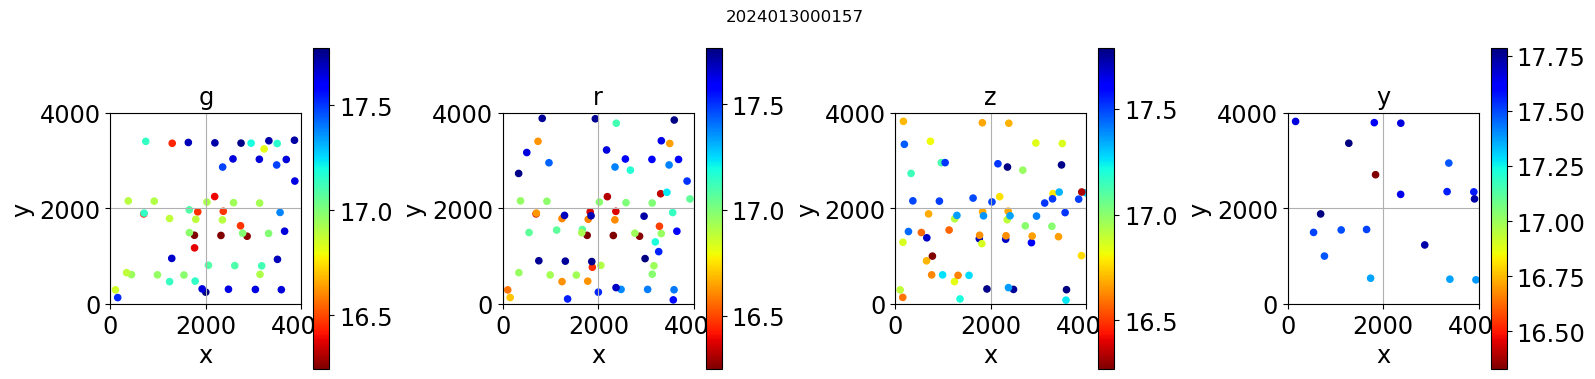

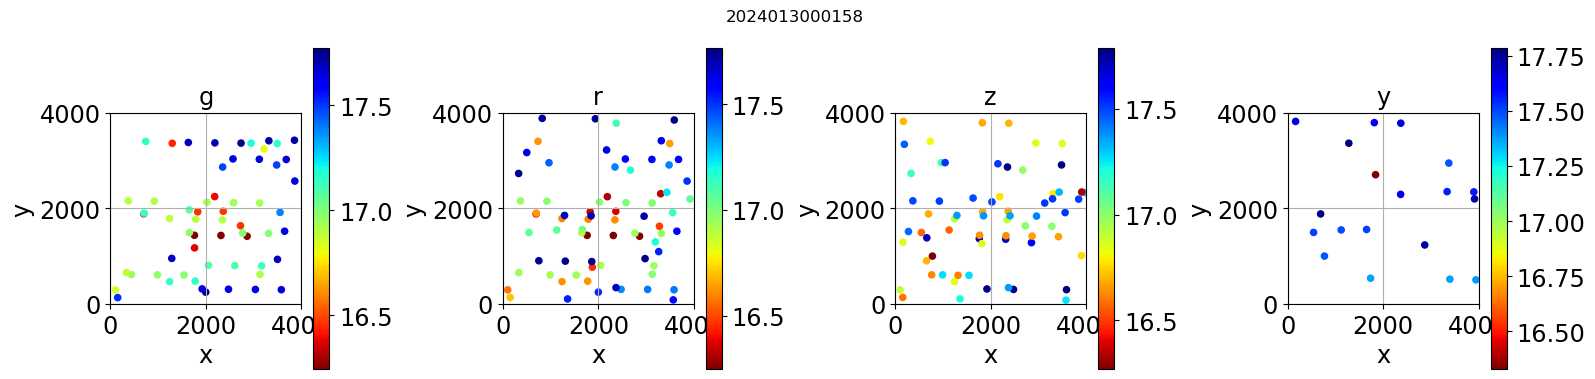

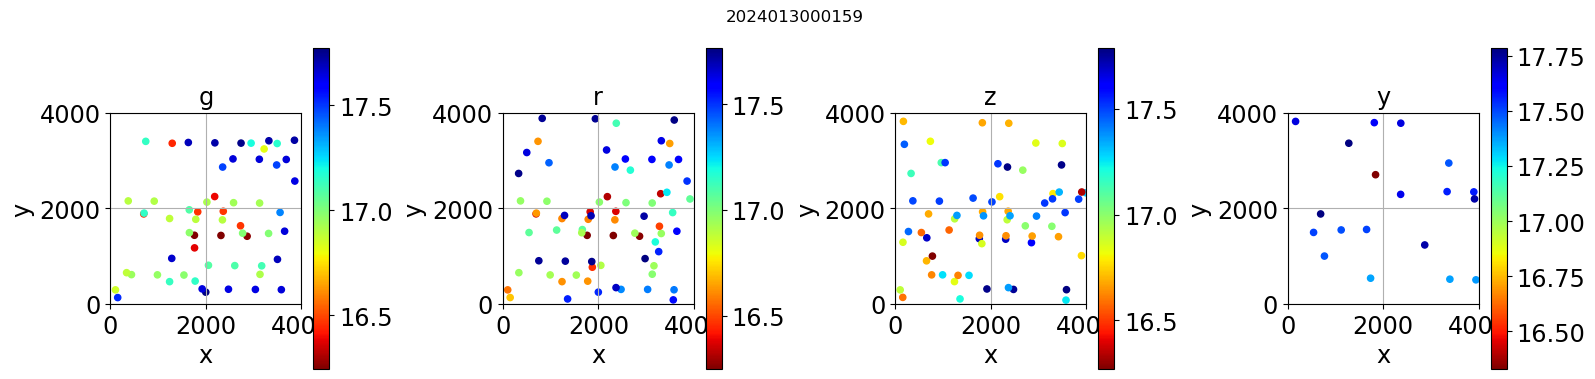

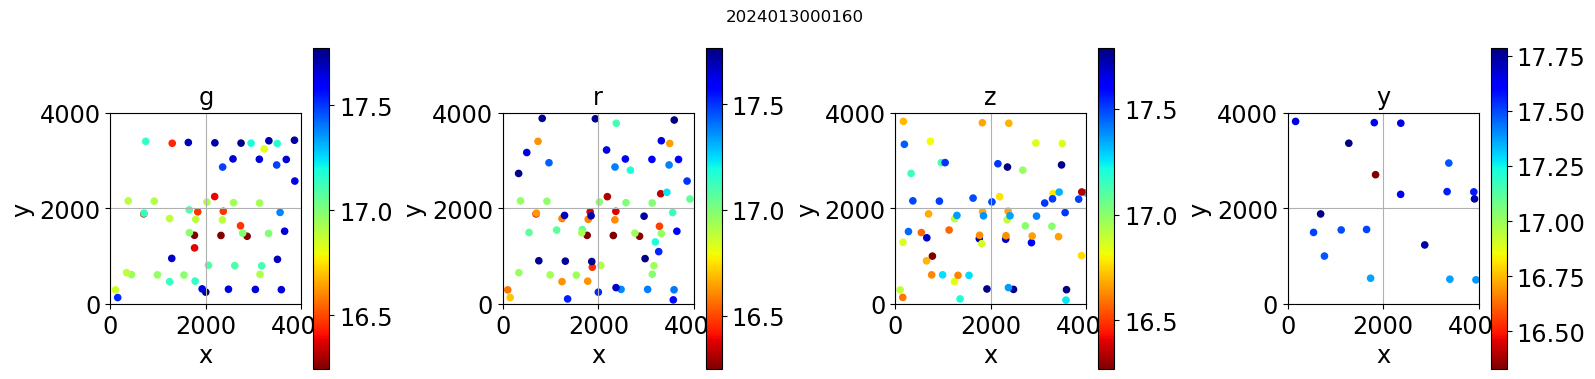

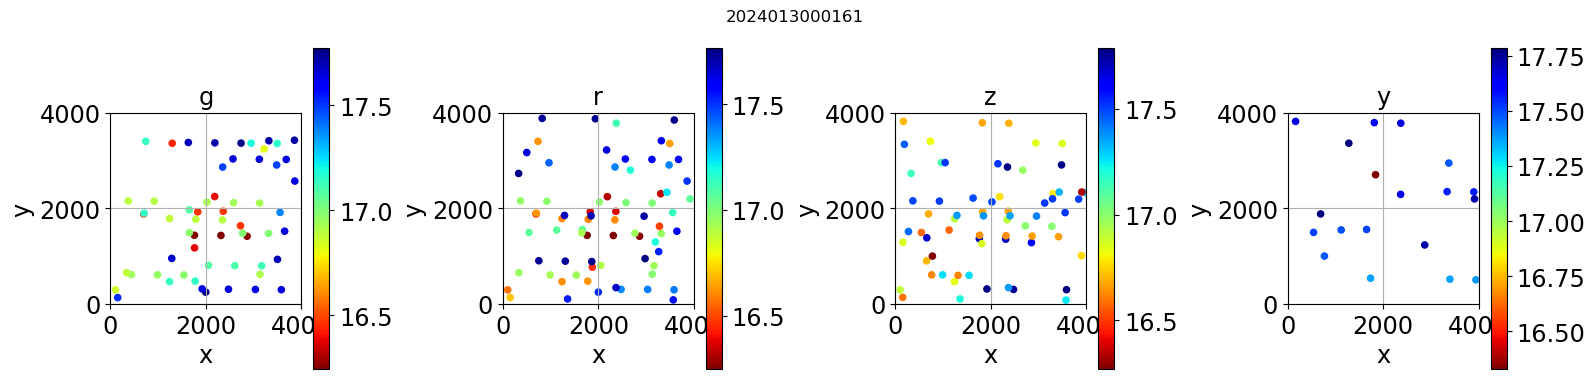

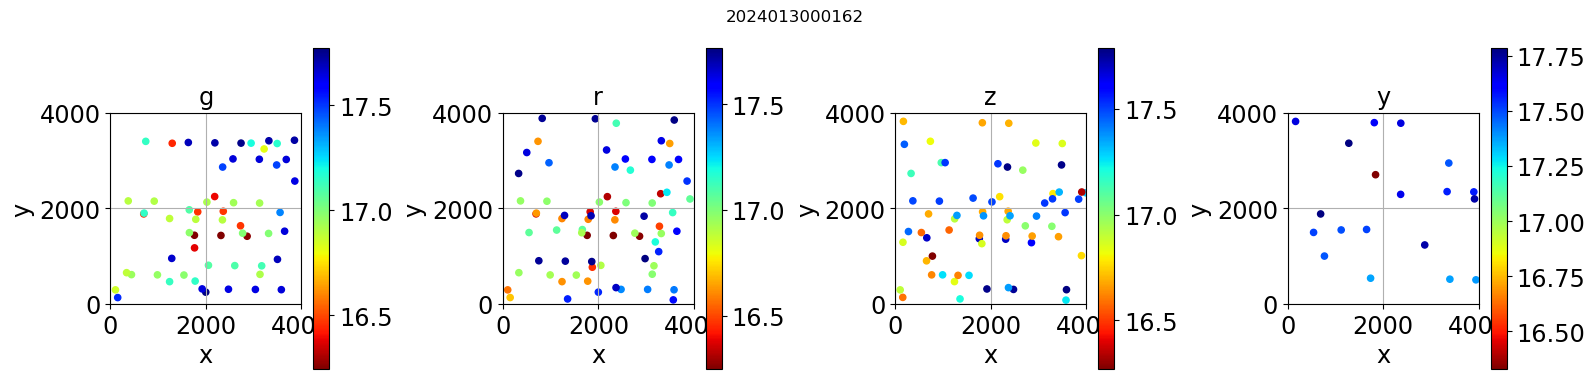

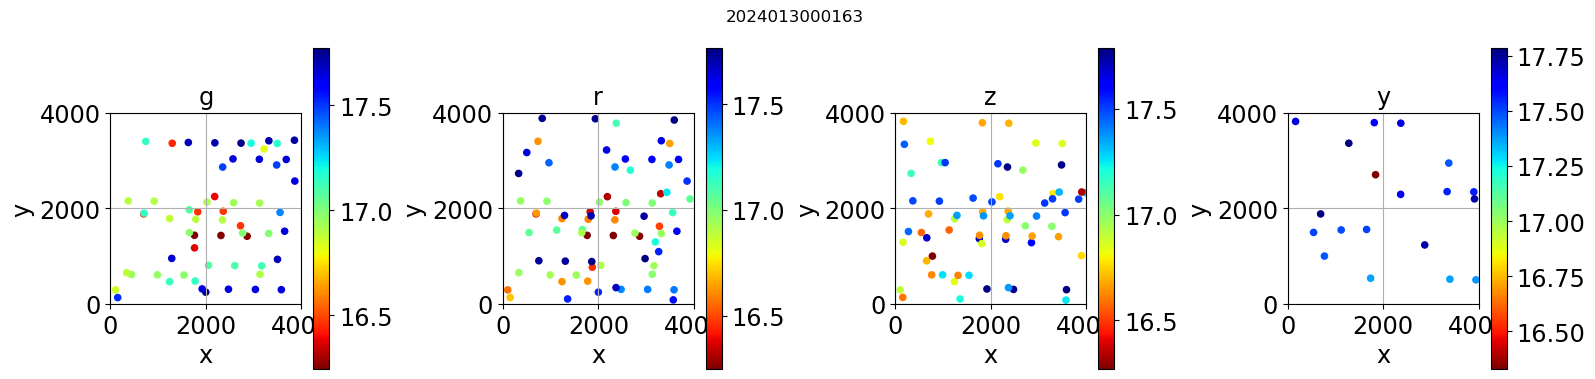

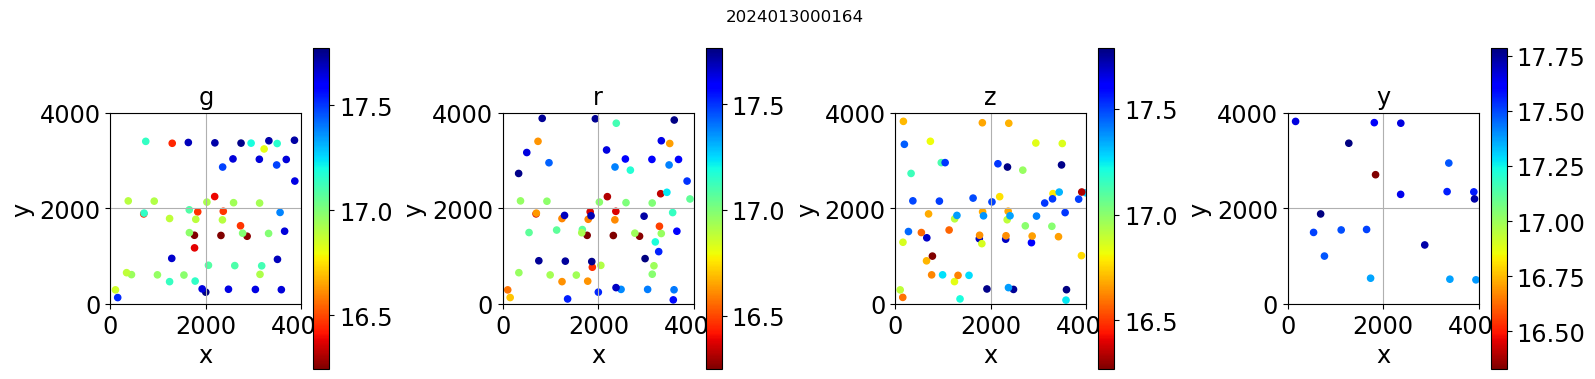

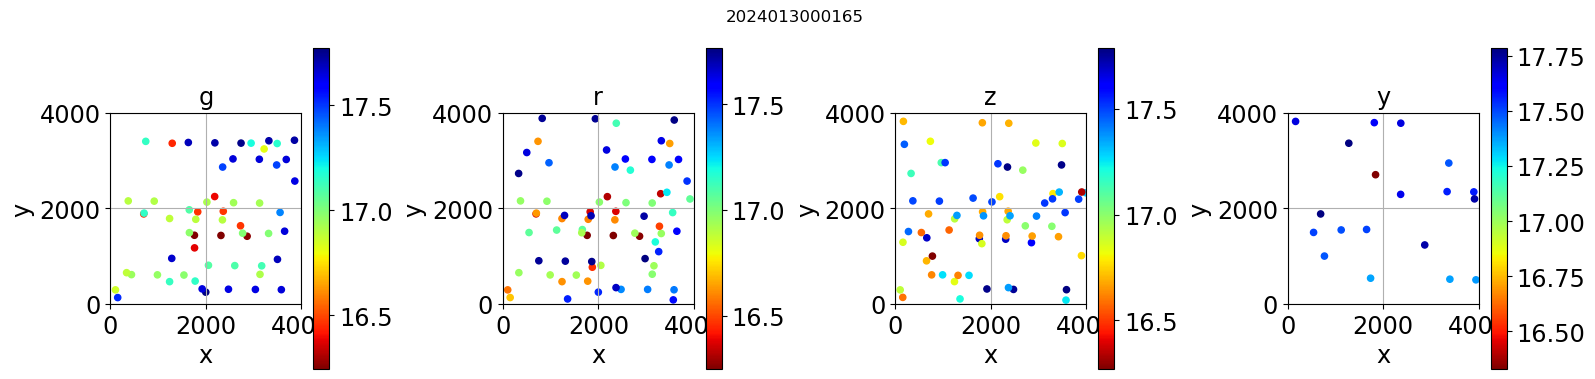

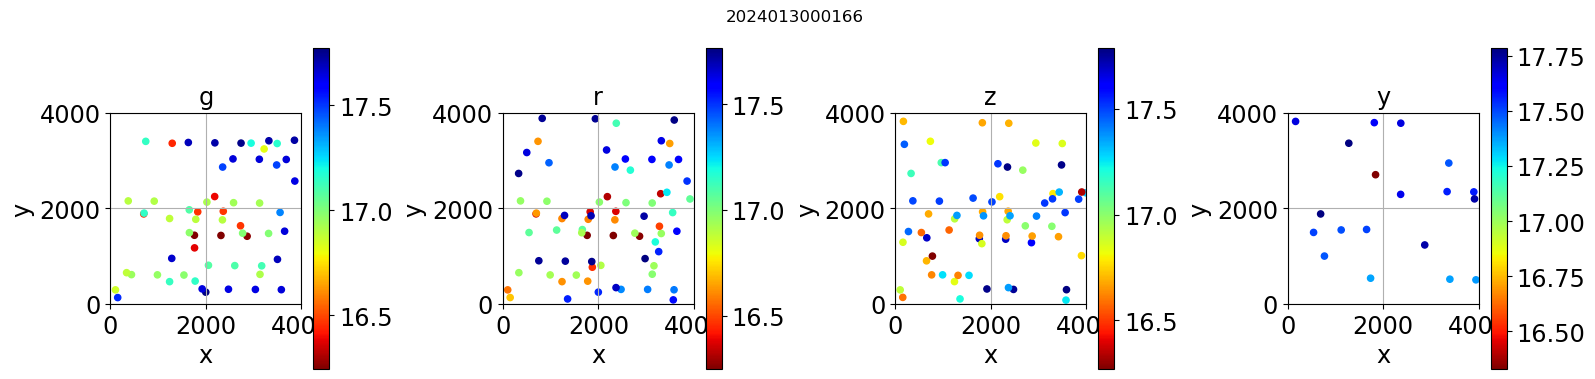

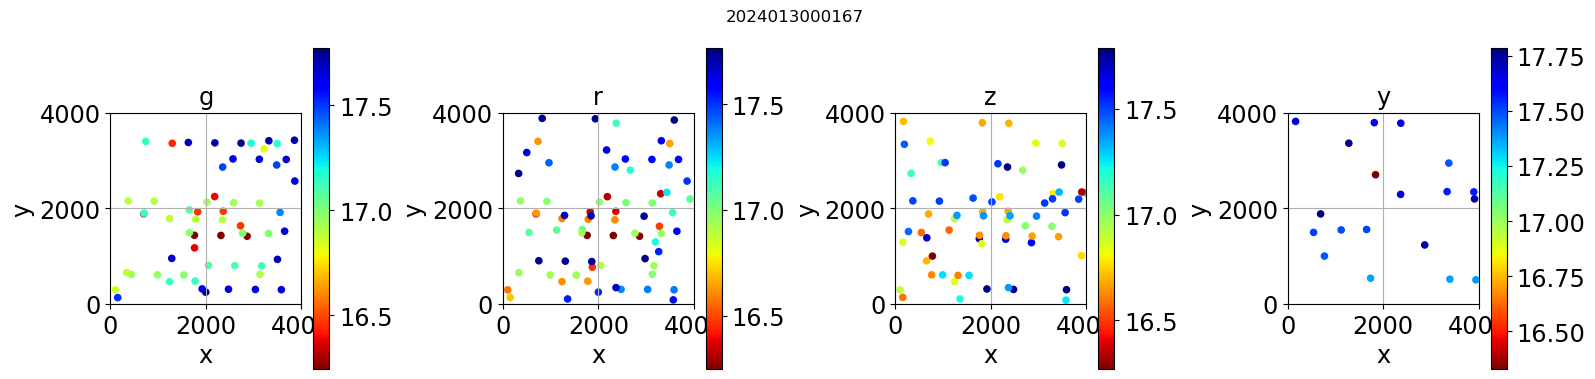

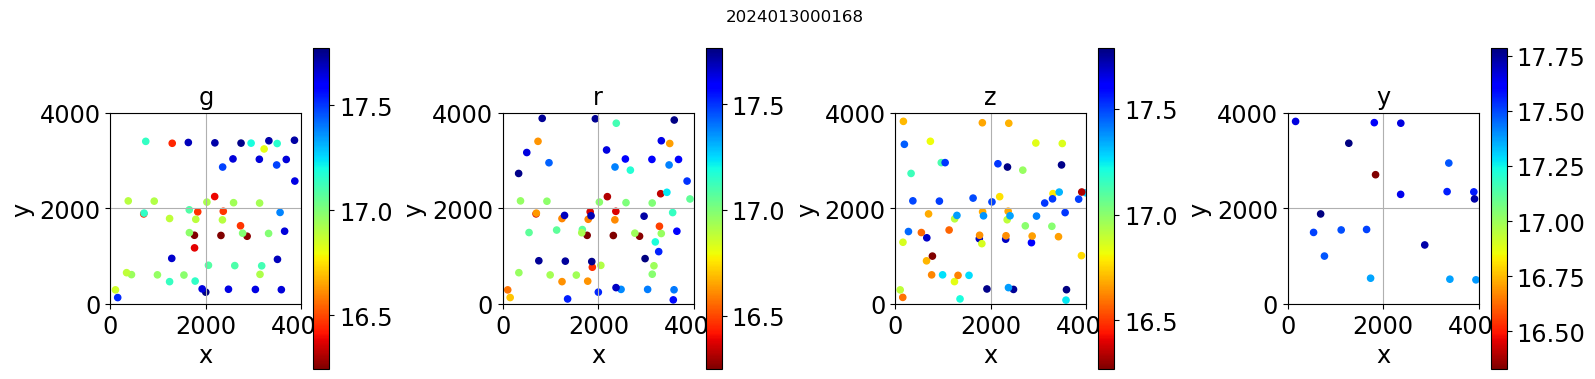

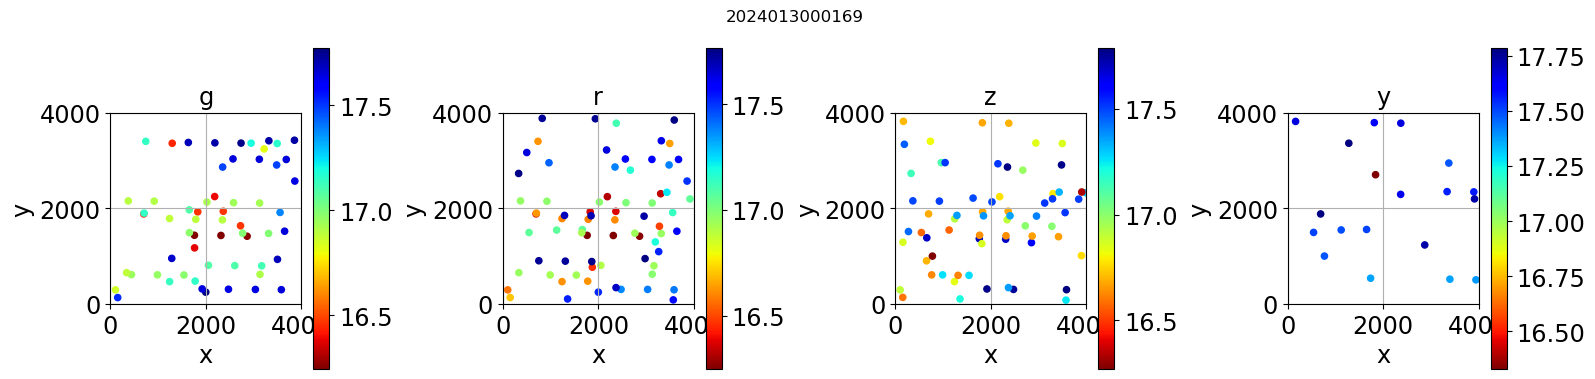

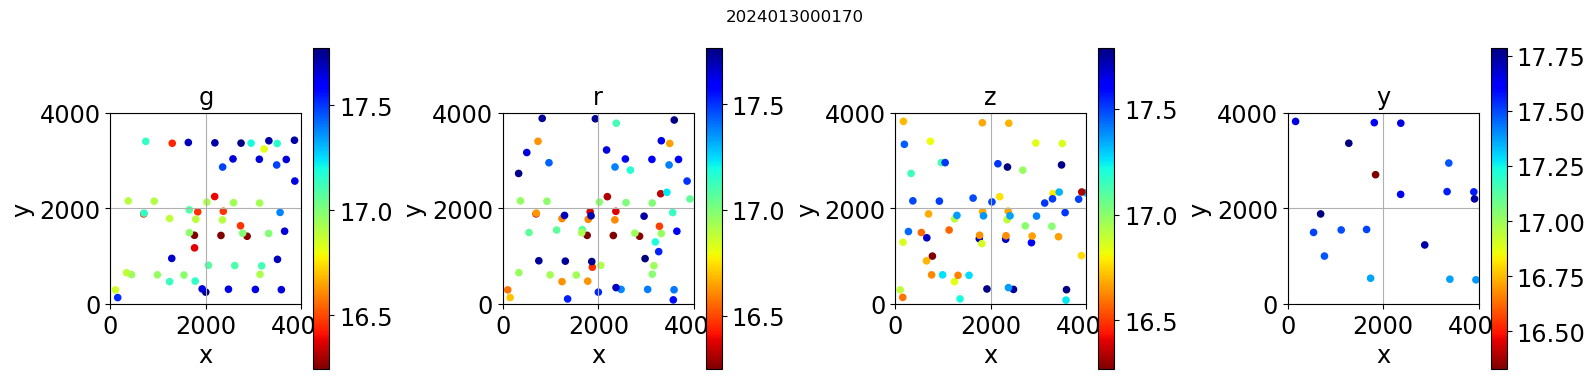

In [31]:
MAGCUT = 17.8
cuts = [ (df["band"] == "g") & (df["apFlux_50_0_instMag"] < MAGCUT), 
         (df["band"] == "r") & (df["apFlux_50_0_instMag"] < MAGCUT),
         (df["band"] == "z") & (df["apFlux_50_0_instMag"] < MAGCUT),
         (df["band"] == "y") & (df["apFlux_50_0_instMag"] < MAGCUT) ]
all_bands = ["g","r","z","y"]
NB = len(all_bands)
all_df_cuts_inbands = [ df[cuts[idx]] for idx in range(NB)]
for visit in all_visits:
    fig, axs = plt.subplots(ncols=4,nrows=1,figsize=(16,4))
    for ib in range(NB):     
        my_colors = all_df_cuts_inbands[ib]["apFlux_50_0_instMag"].values
        if len(my_colors) > 0:
            all_df_cuts_inbands[ib].plot.scatter('x','y',c=my_colors,colormap='jet_r',grid=True,ax = axs[ib])
            axs[ib].set_title(all_bands[ib])
            axs[ib].axes.set_aspect('equal')
            axs[ib].axes.set_xlim(0.,4000.)
            axs[ib].axes.set_ylim(0.,4000.)
    #axs[0].scatter(data=all_df_cuts_inbands[0], x='x', y='y', c='apFlux_35_0_instMag', cmap="viridis")
    plt.suptitle(str(visit))
    plt.tight_layout()

/tmp/ipykernel_41933/3396553859.py:2: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  fig, axs = plt.subplots(ncols=4,nrows=1,figsize=(16,4))


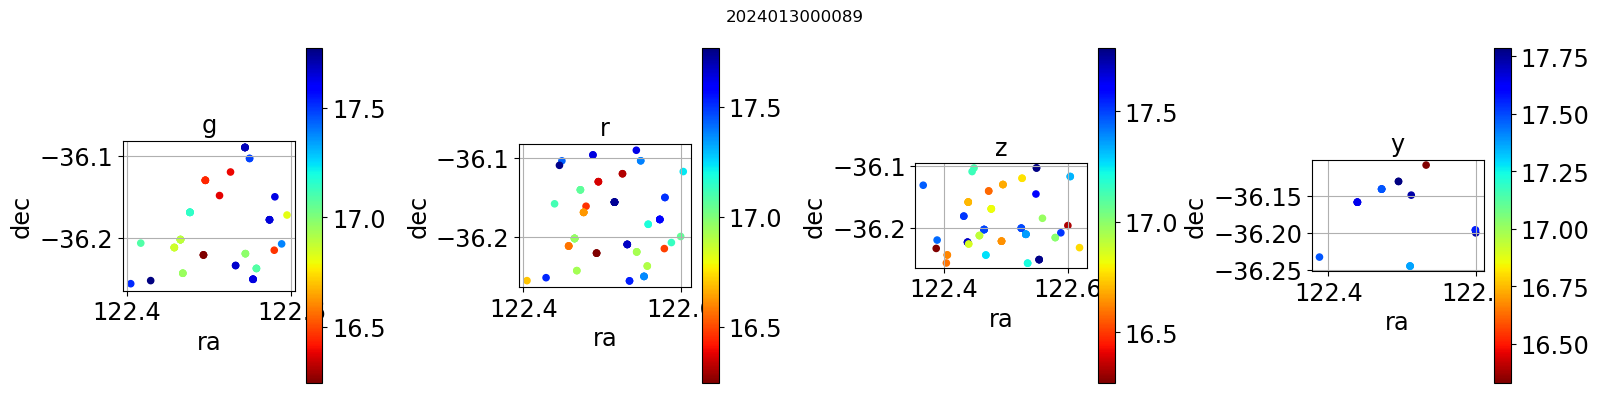

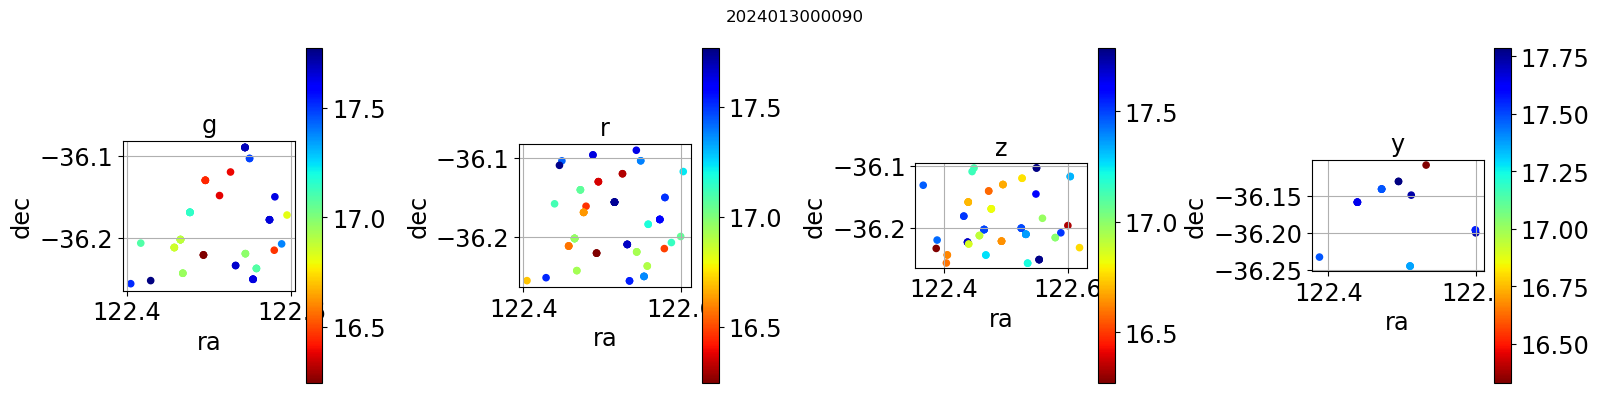

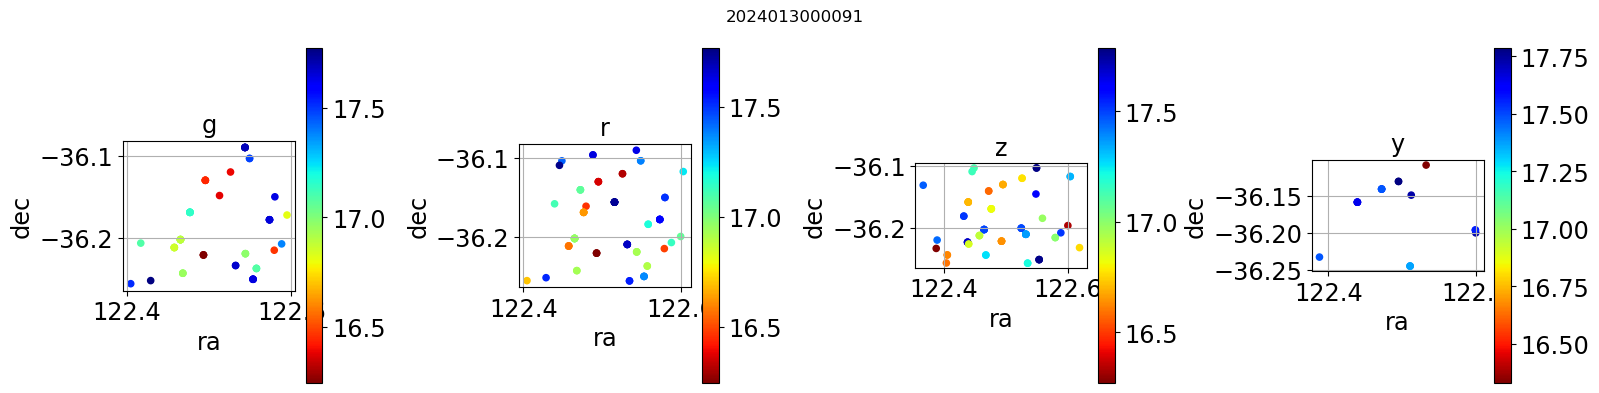

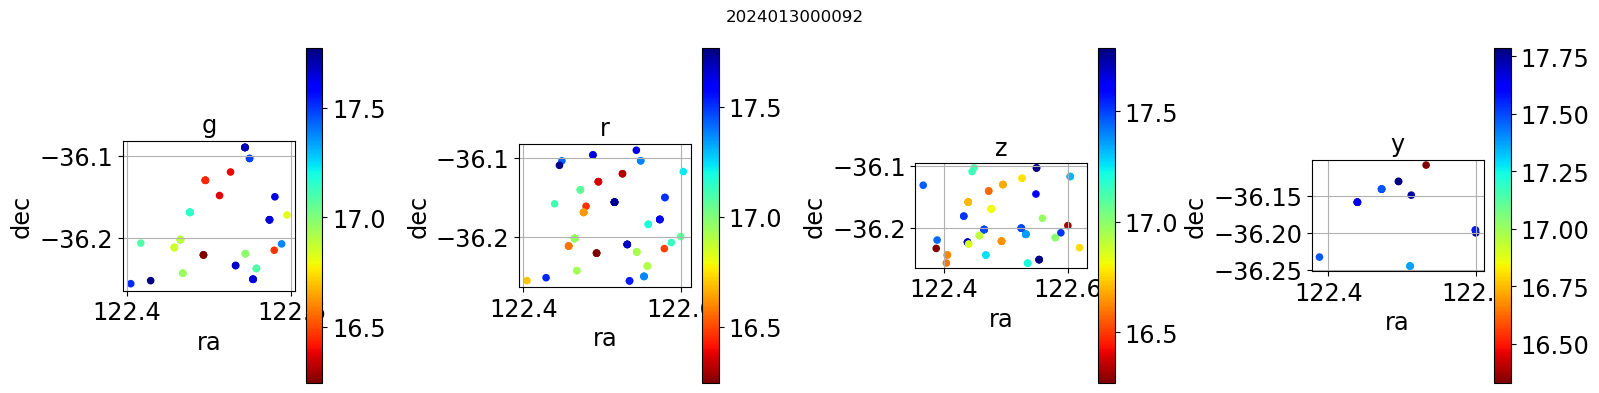

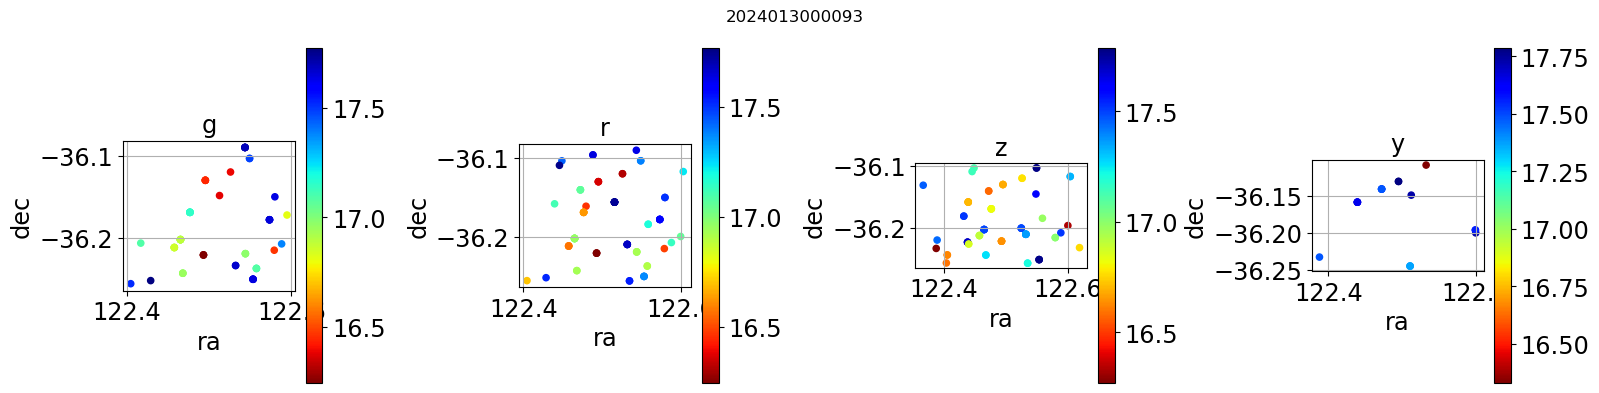

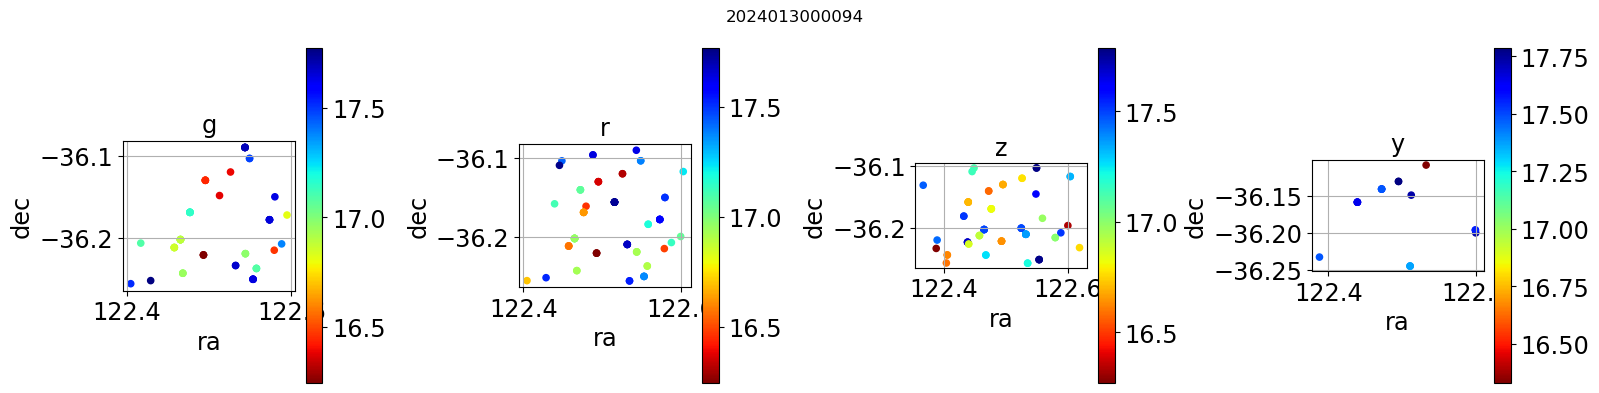

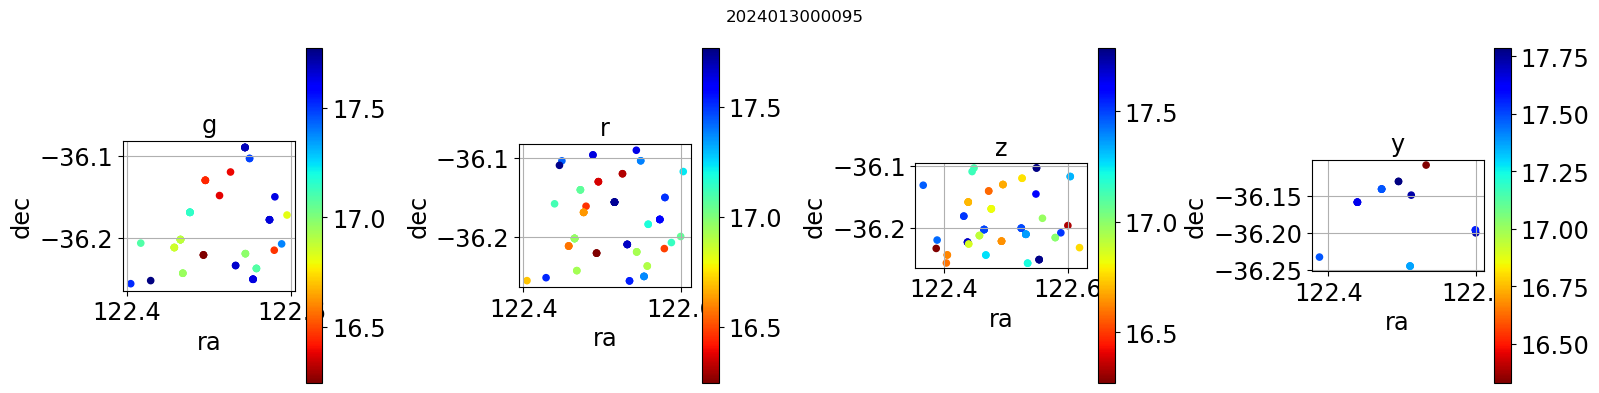

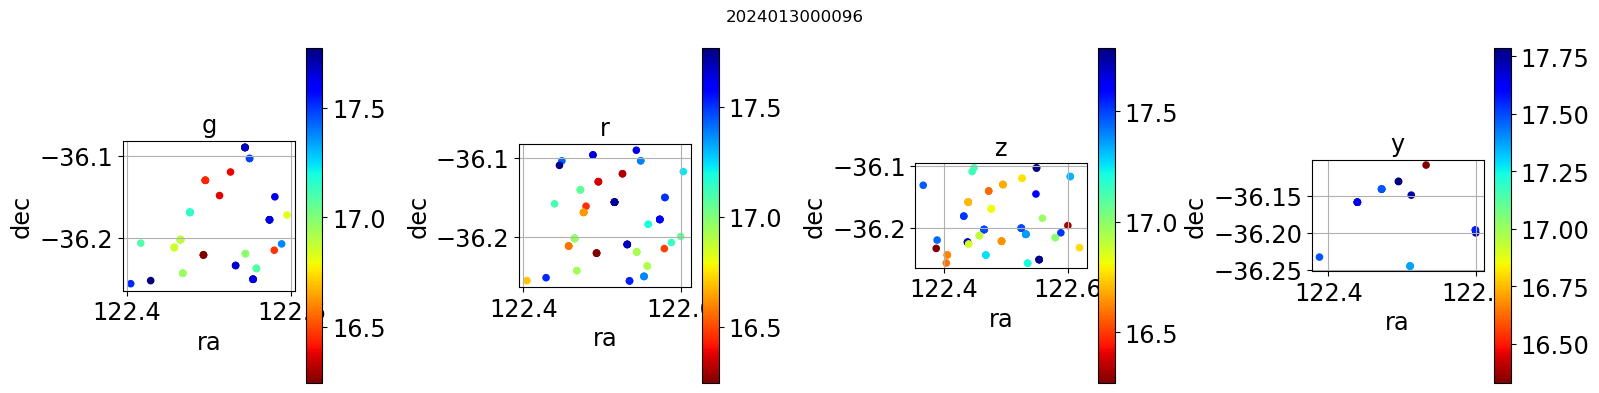

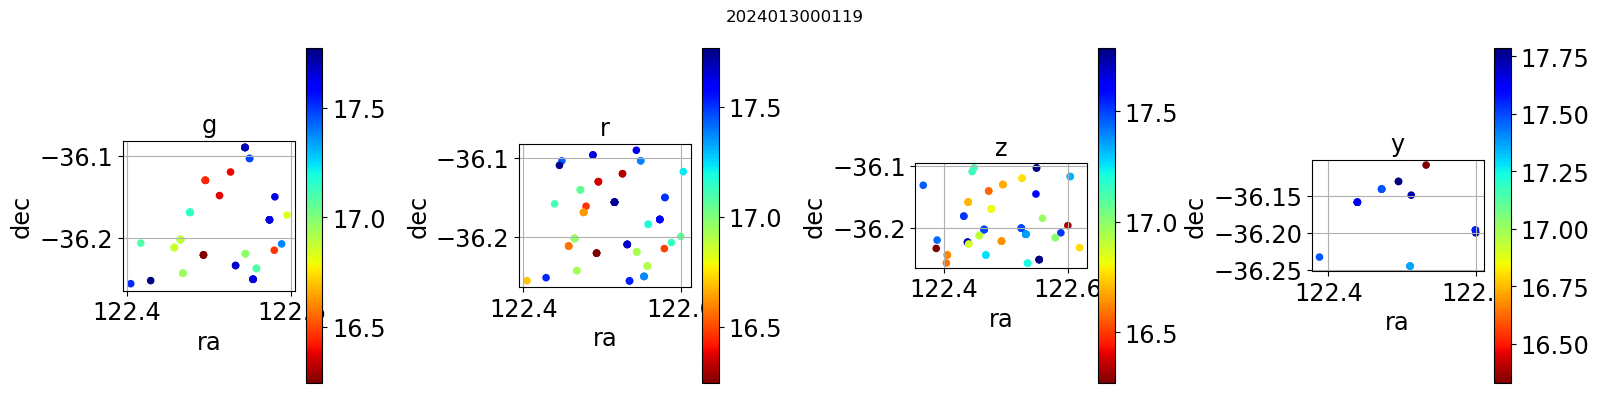

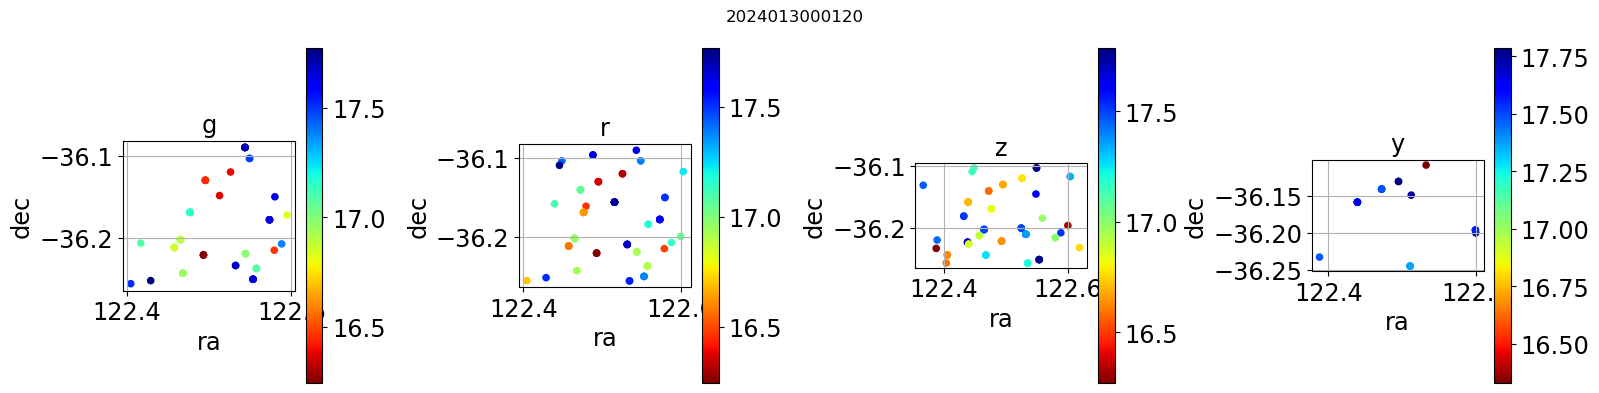

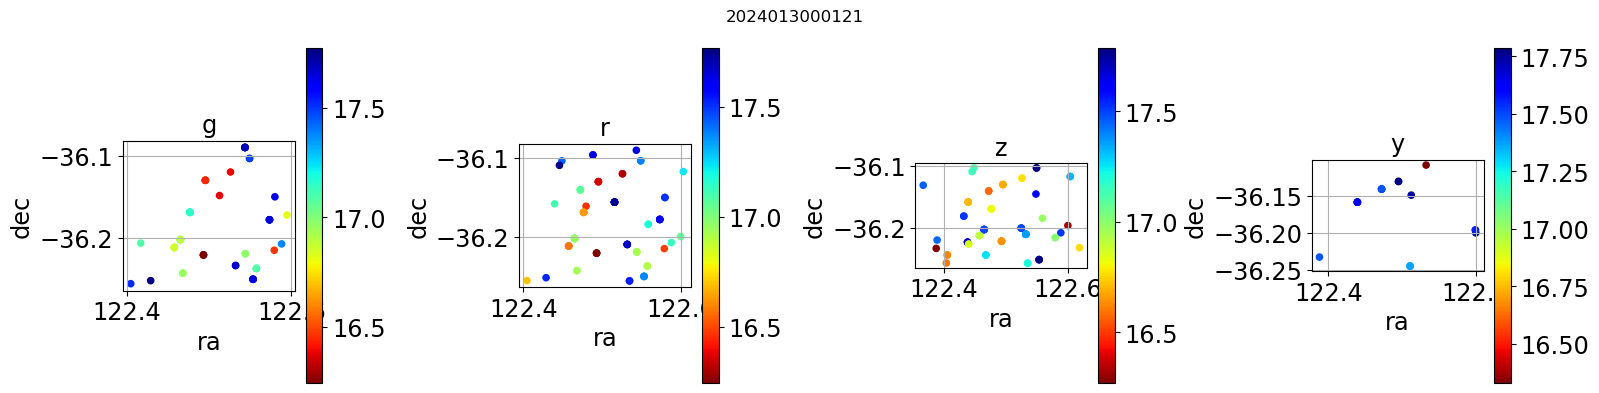

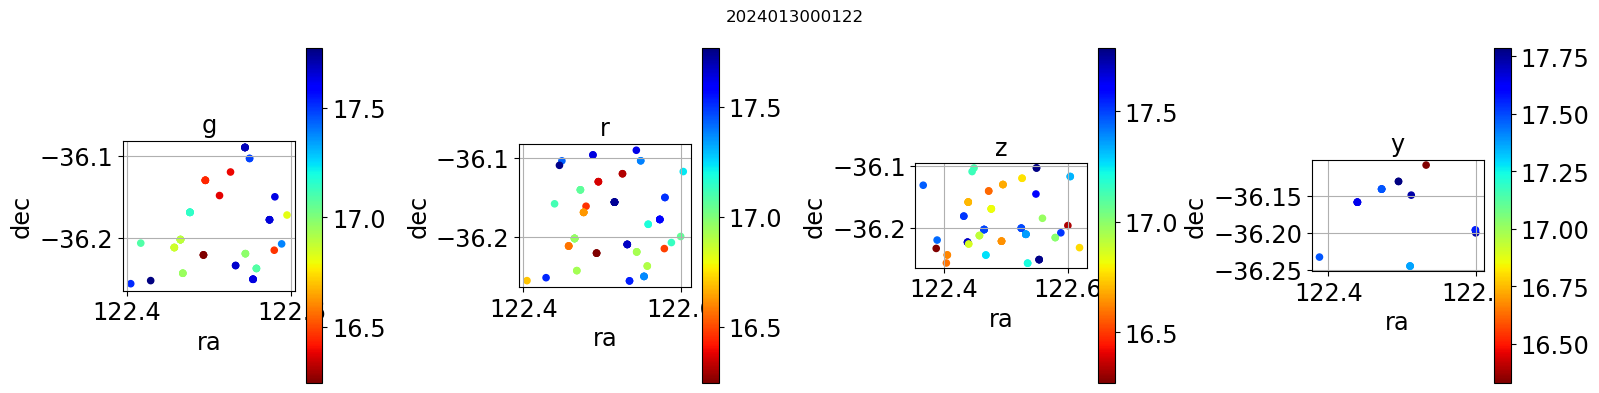

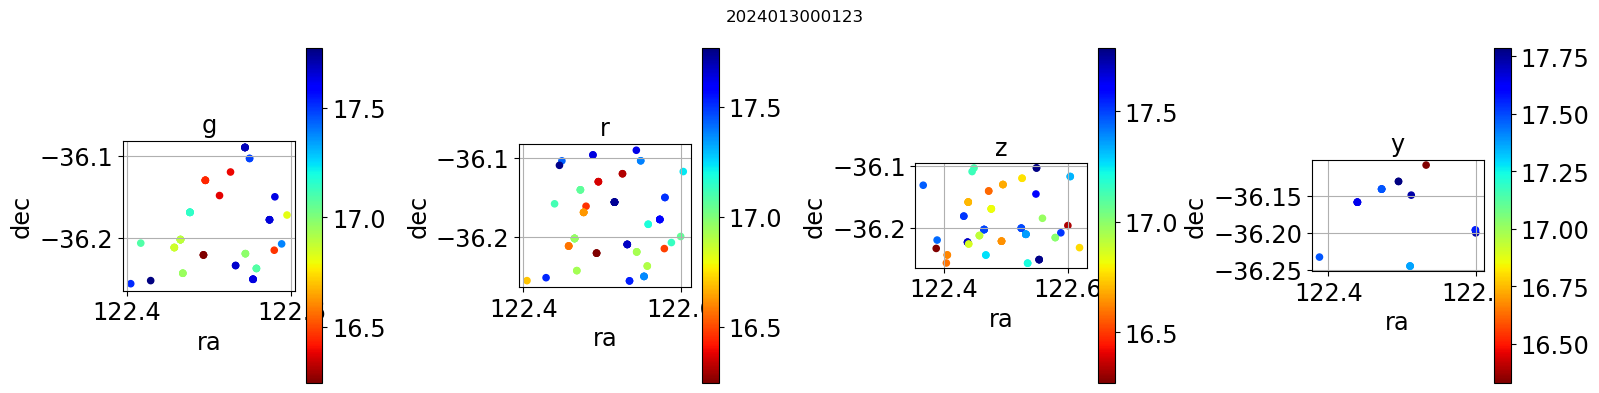

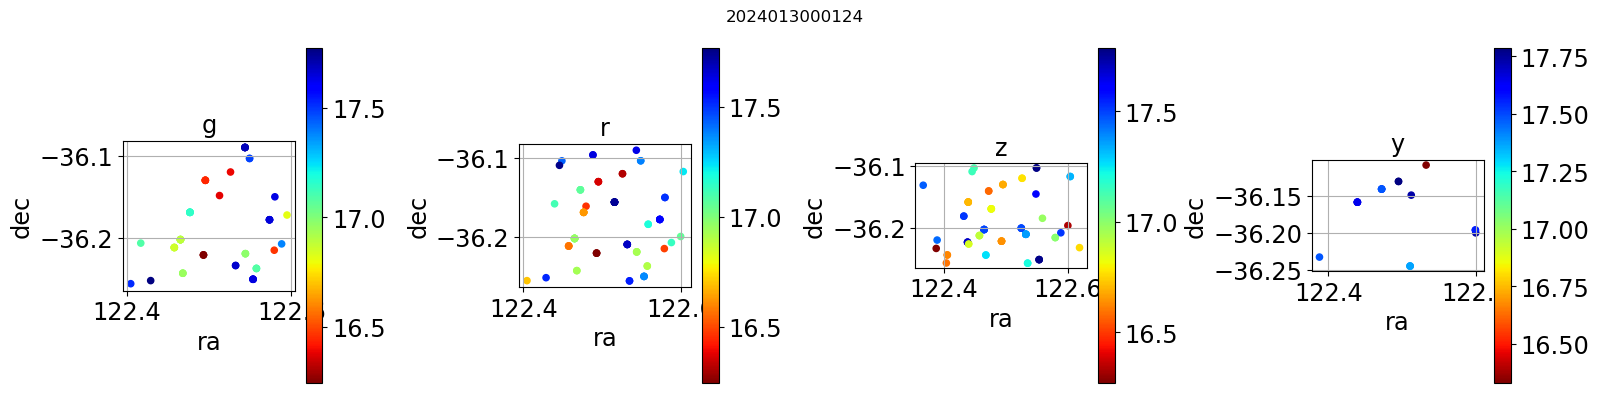

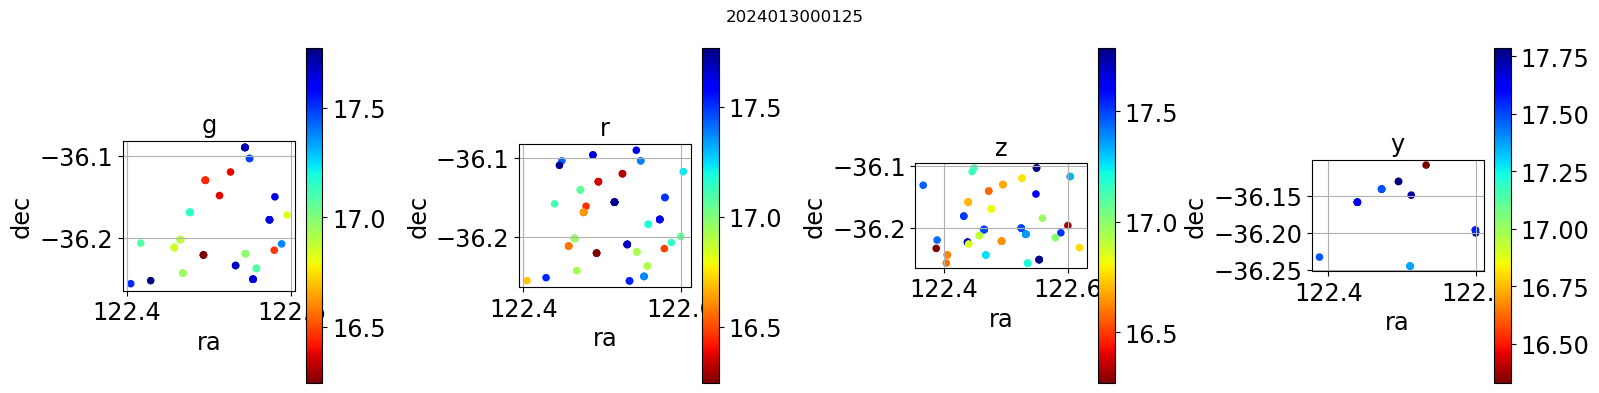

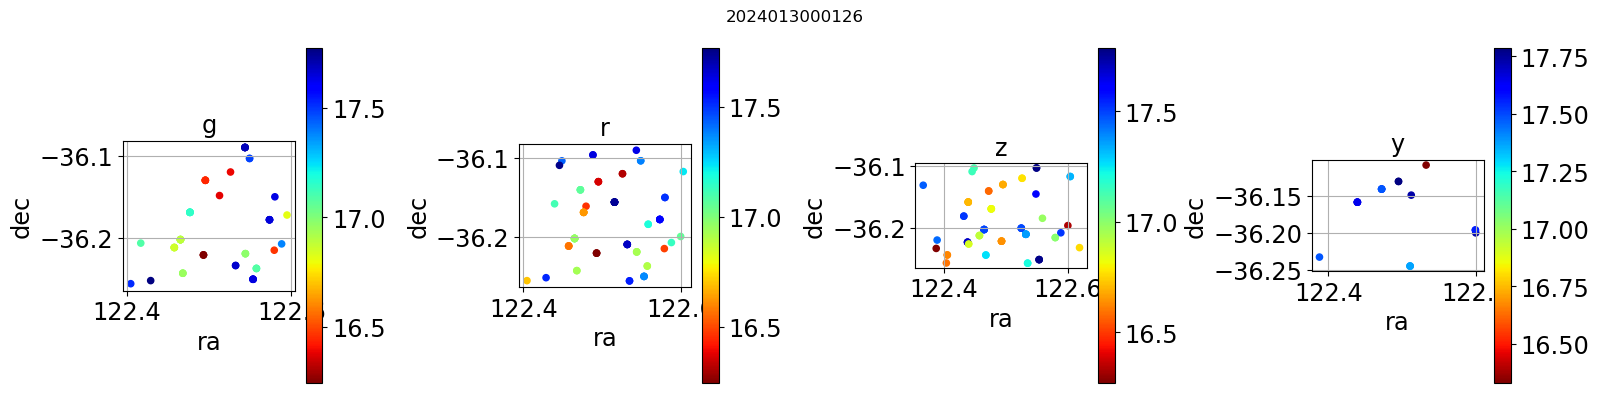

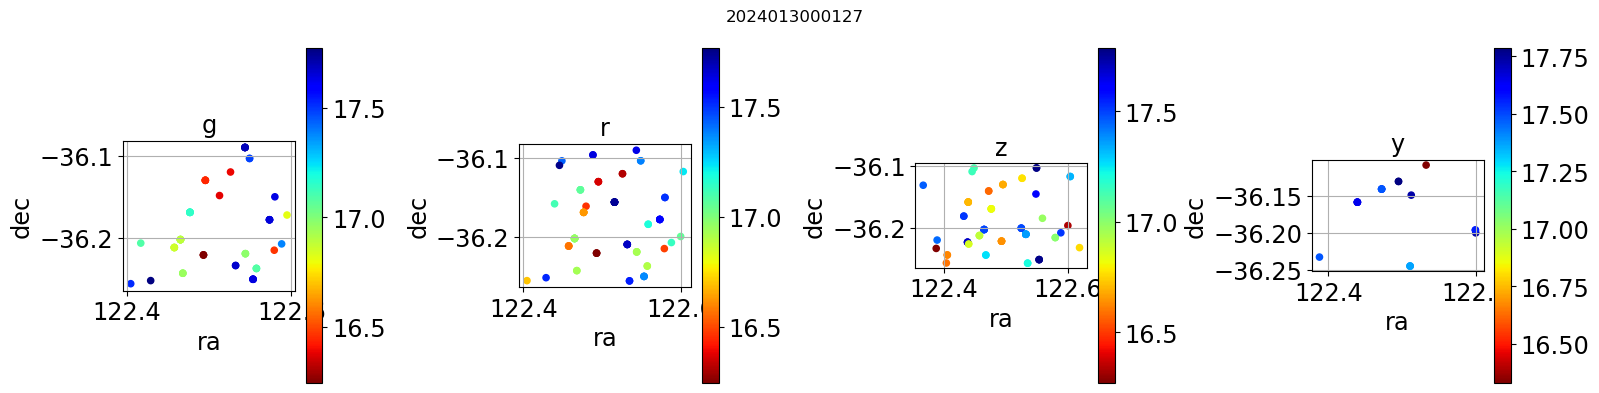

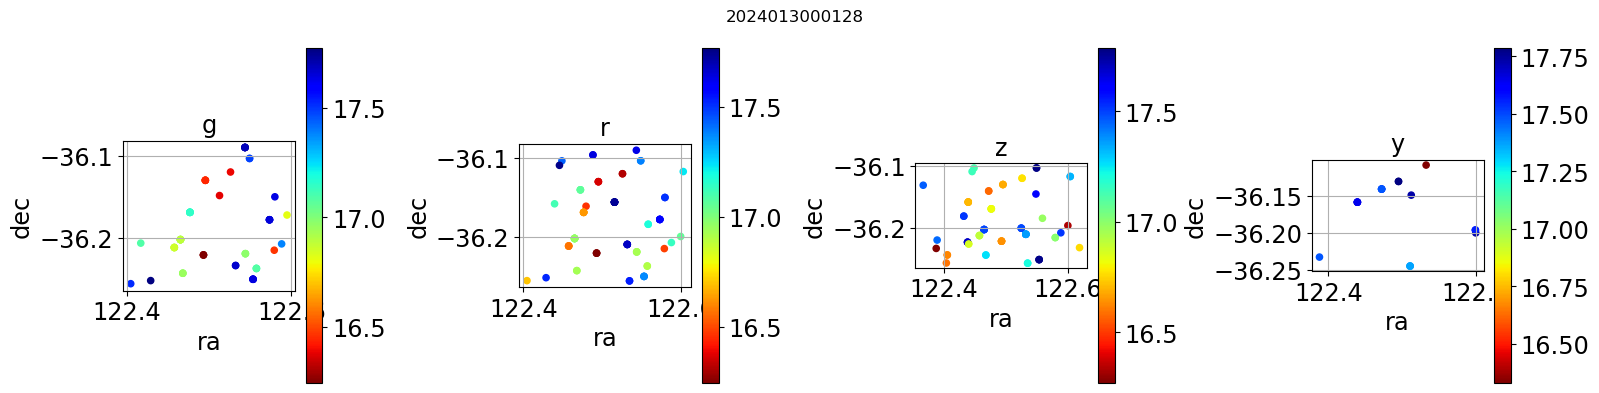

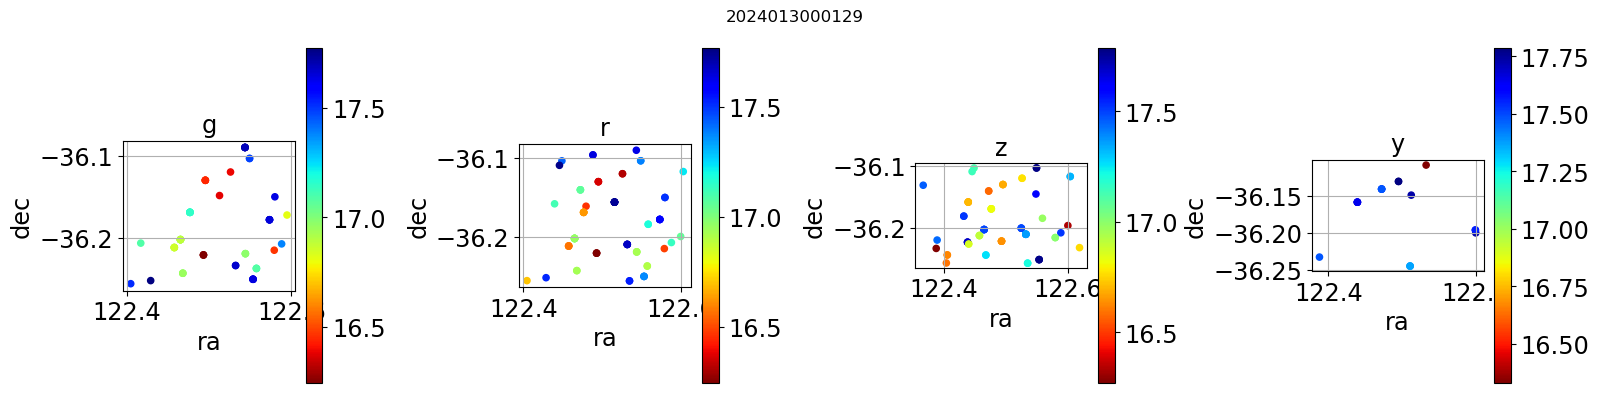

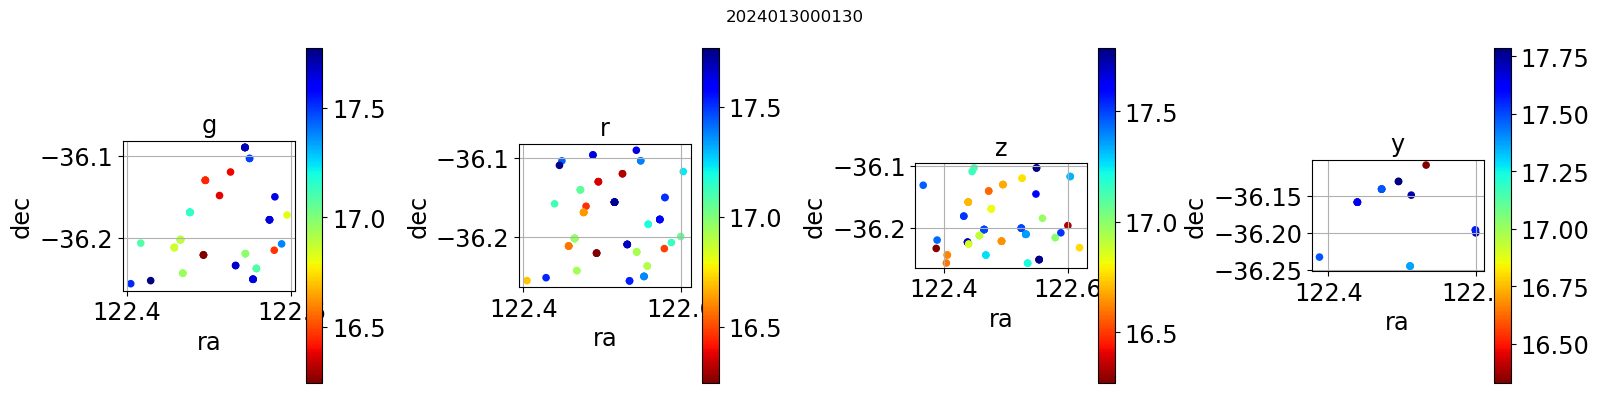

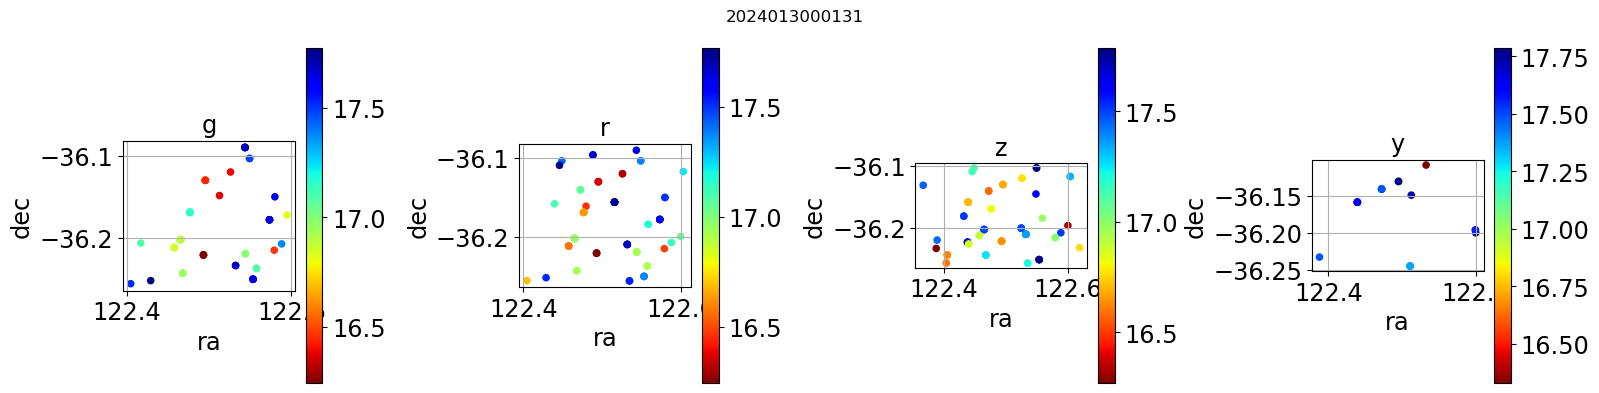

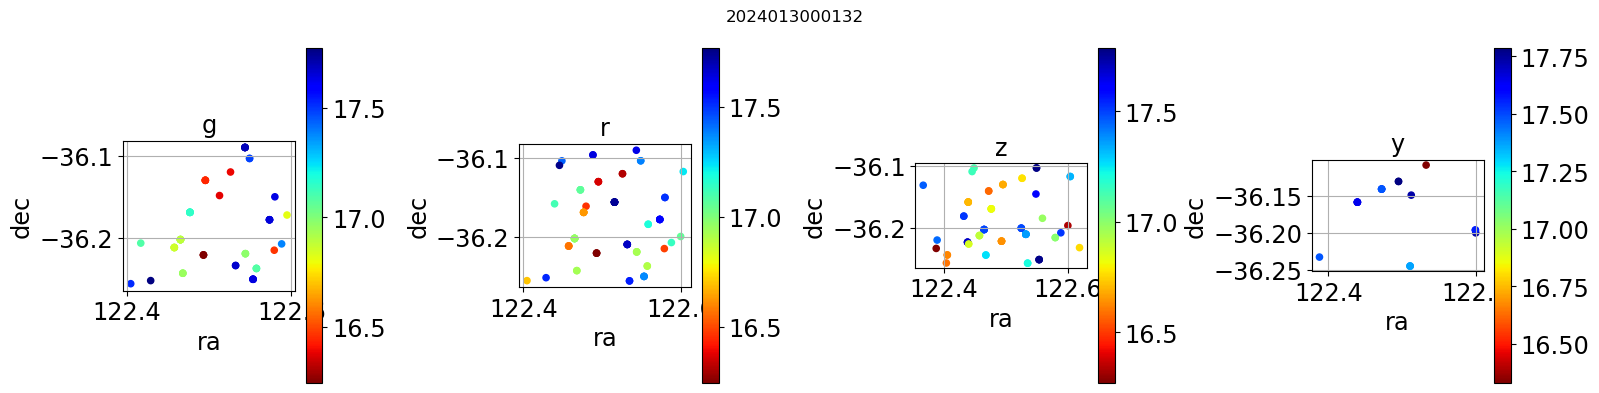

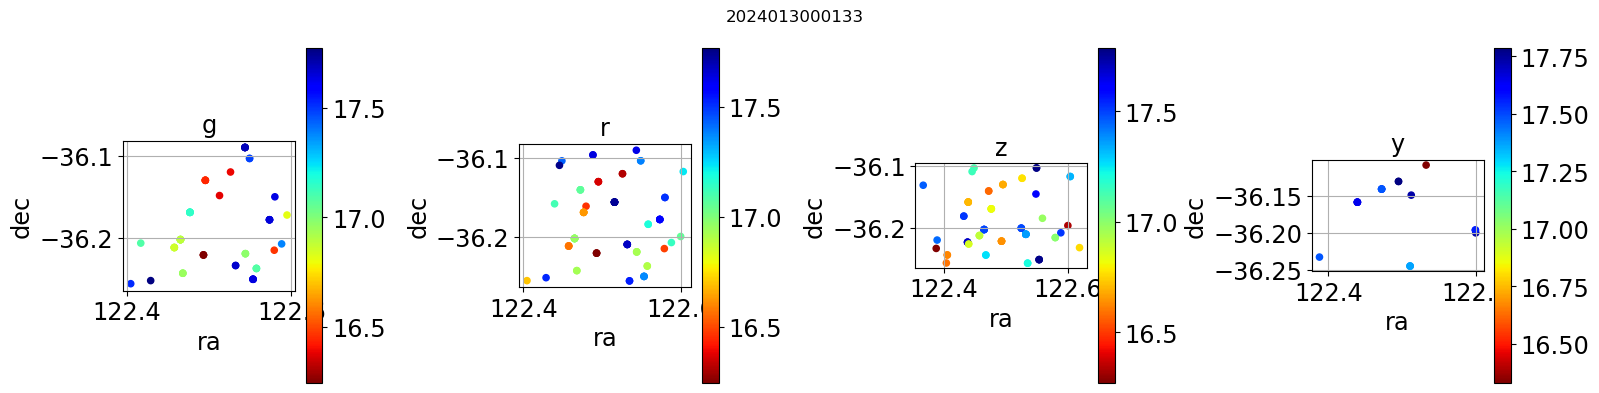

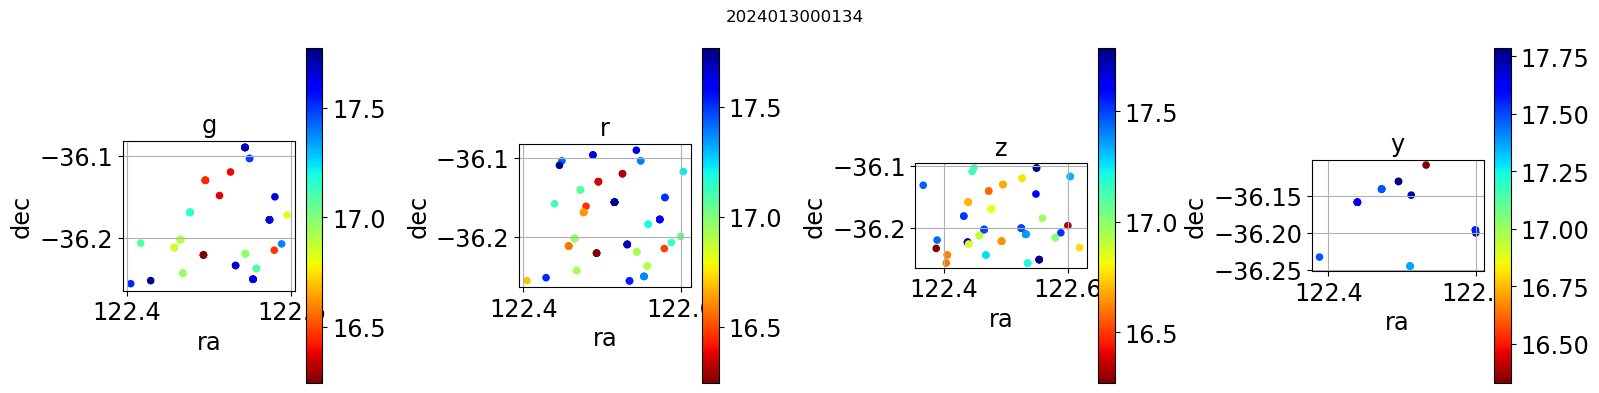

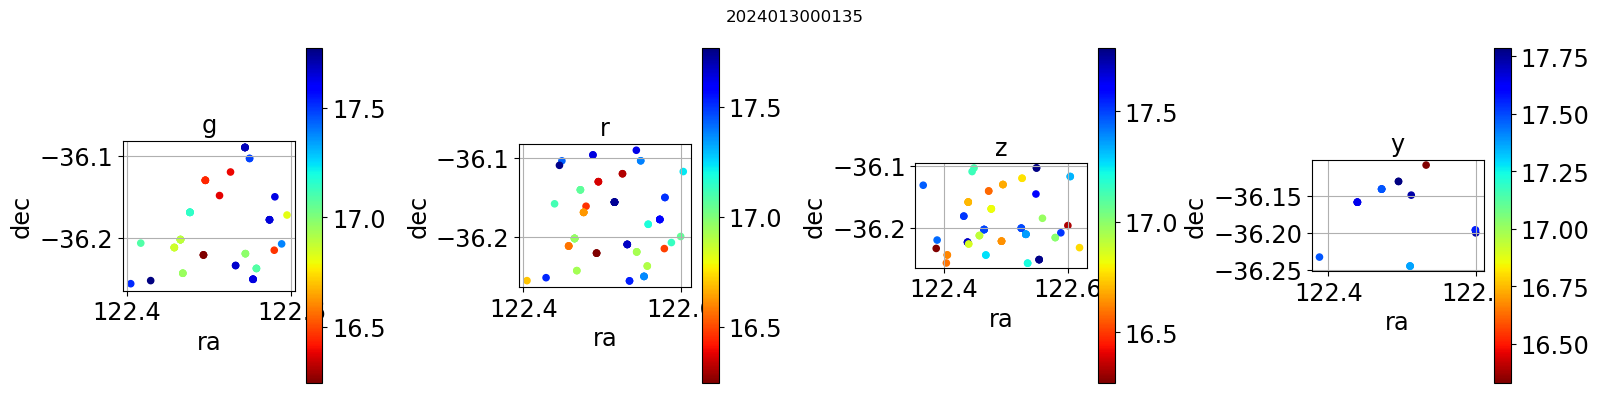

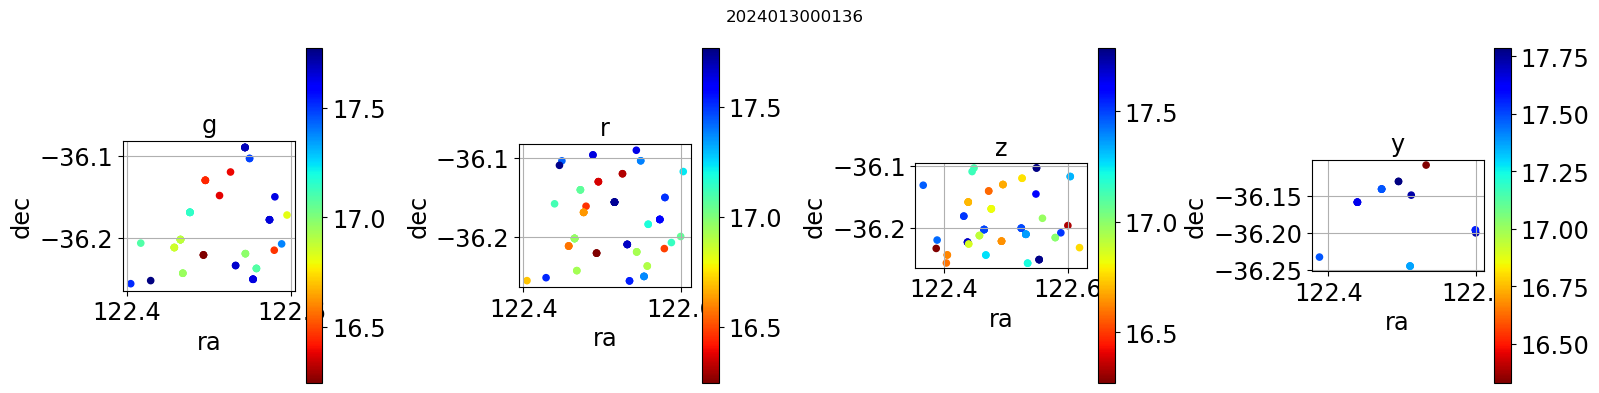

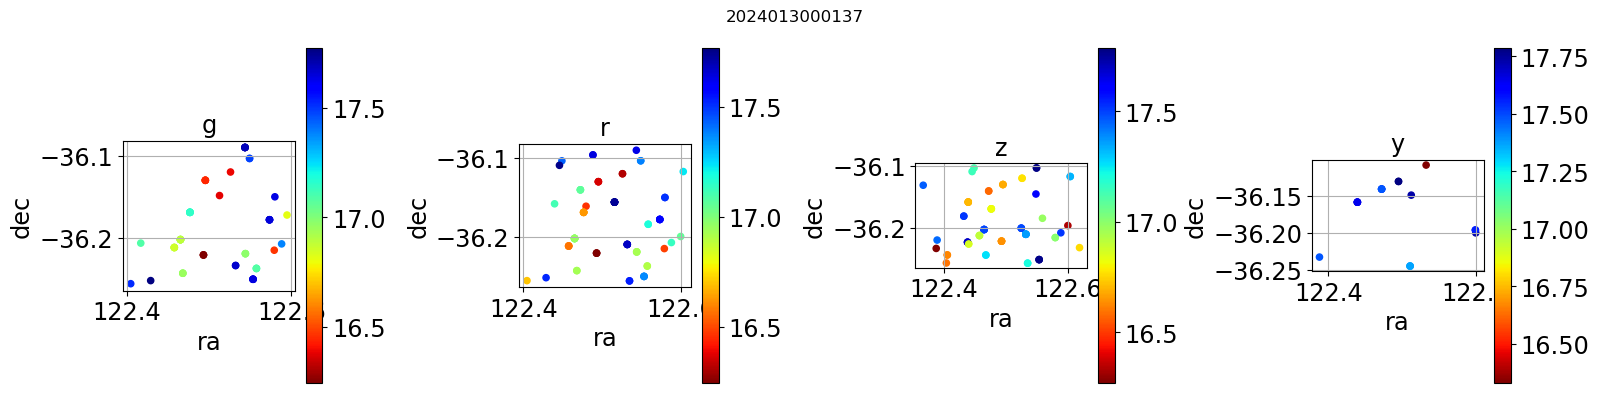

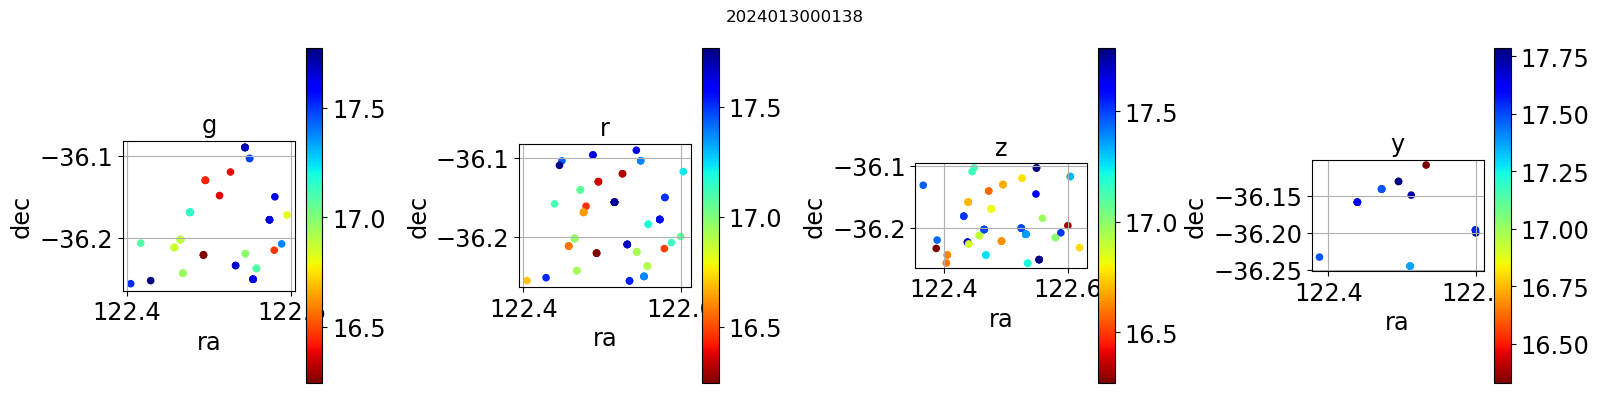

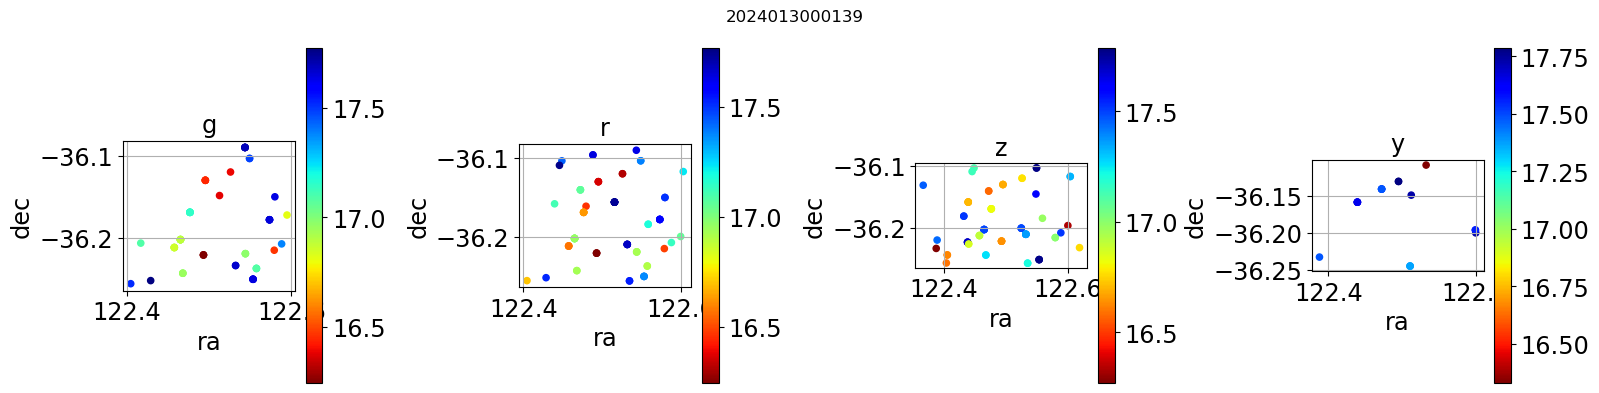

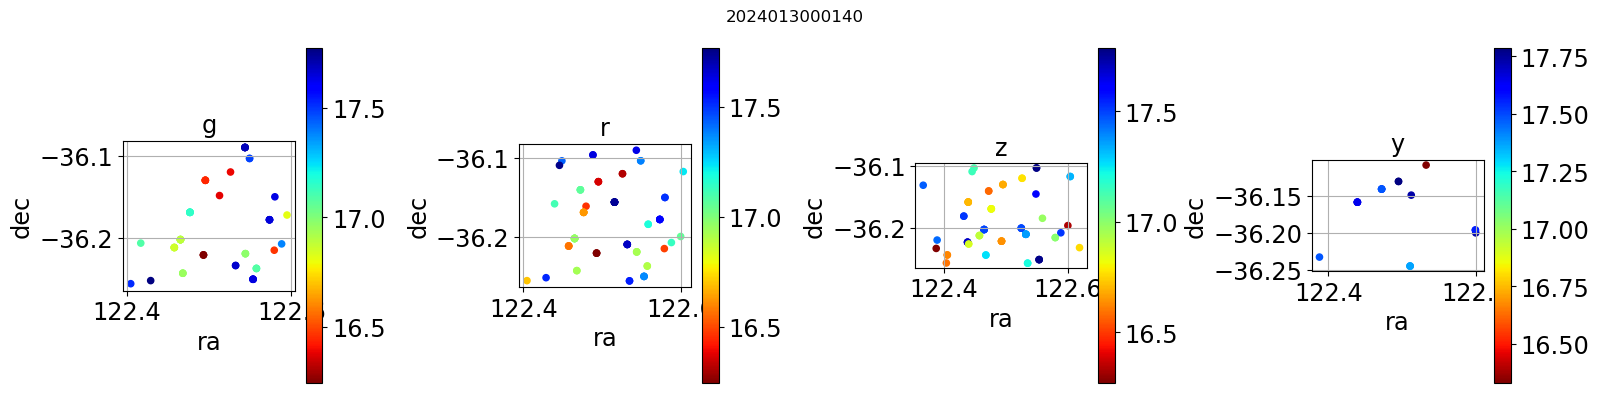

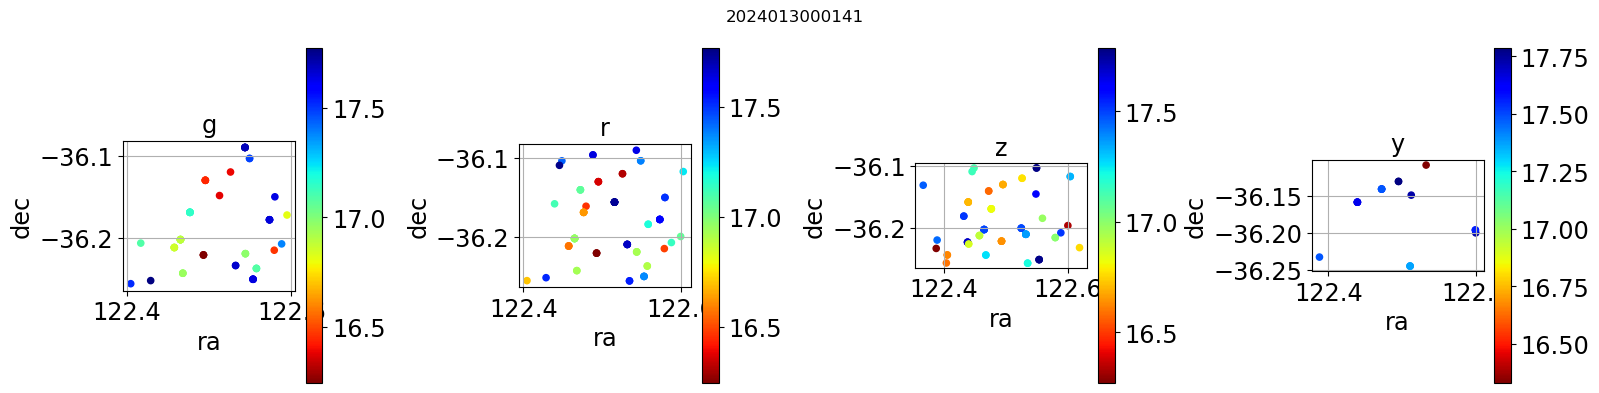

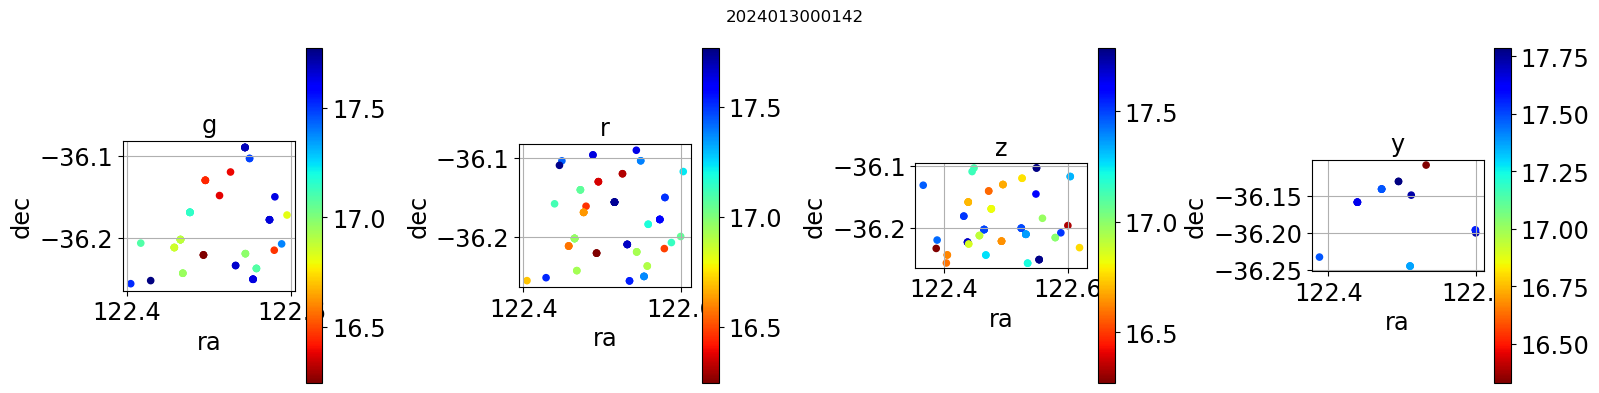

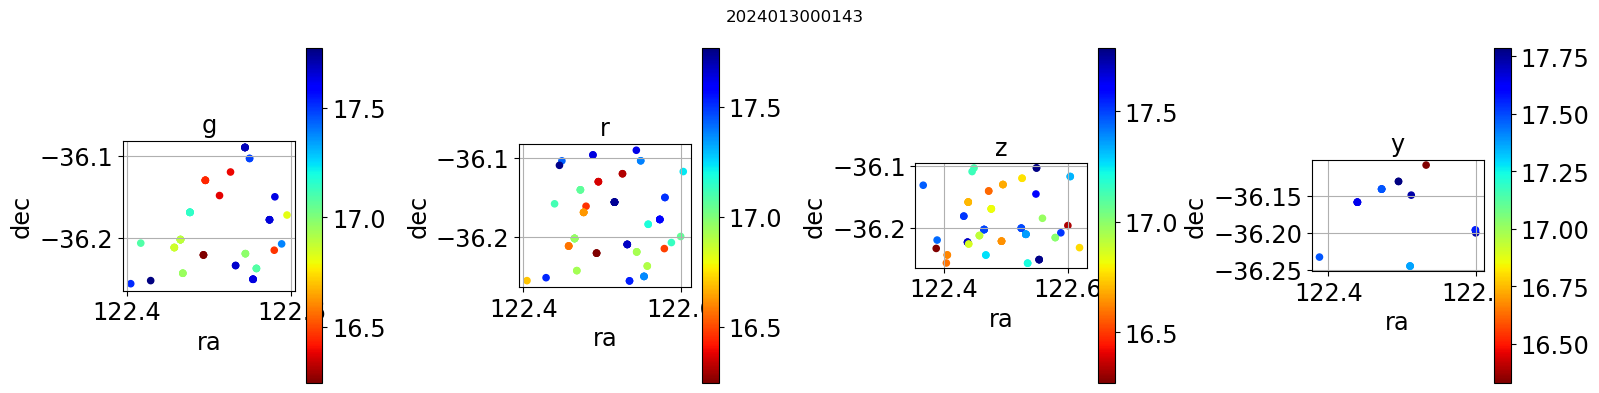

In [ ]:
for visit in all_visits:
    fig, axs = plt.subplots(ncols=4,nrows=1,figsize=(16,4))
    for ib in range(NB):     
        my_colors = all_df_cuts_inbands[ib]["apFlux_50_0_instMag"].values
        if len(my_colors) > 0:
            all_df_cuts_inbands[ib].plot.scatter('ra','dec',c=my_colors,colormap='jet_r',grid=True,ax = axs[ib])
            axs[ib].set_title(all_bands[ib])
            axs[ib].axes.set_aspect('equal')
            
    #axs[0].scatter(data=all_df_cuts_inbands[0], x='x', y='y', c='apFlux_35_0_instMag', cmap="viridis")
    plt.suptitle(str(visit))
    plt.tight_layout()